# UE Computer Vision | Lab Session 2 - Image interpretation

pierre-henri.conze@imt-atlantique.fr

Student names = Jules Decaestecker

***
This lab session is dedicated to **image interpretation** with deep learning. Two topics will be studied and discussed:

1. **semantic segmentation**
2. **object detection** (single-object localization)

For these purposes, we exploit an annotated dataset of pets, called **Oxford-IIIT-Pet** and covering 37 different breeds of cats and dogs. In particular, we focus on 200 images obtained for the *samoyed* category. [Click here](https://www.robots.ox.ac.uk/~vgg/data/pets/) to visualize the whole dataset !

<div id="image">
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e0/1926_Samoyed_CHPolarLight.jpg" WIDTH=280 HEIGHT=240>
</div>
<div id="subject">
</br>

Each image is annotated with a breed label (*samoyed* in our case), a pixel level segmentation marking the body, and a tight bounding box around the dog head.


Beforehand, let us import the data provided (498 files = source images in `.jpg`, segmentation masks in `.png` and XML files) into the **Colab** session !

This lab session uses `keras` as deep learning python library. Make sure you use the **GPU** of Colab to achieve (quite) fast learning !  



---



## I - Semantic segmentation

Our goal is to create an automatic **semantic segmentation model** with deep learning able to accurately delineate *samoyed* dogs in each image.

**Question 1 -** Read and display the three first images (`samoyed_i` with `i={1,2,3}`) with associated segmentation masks.

In [29]:
from skimage import io

img1 = io.imread('samoyed-1.jpg')
seg1 = io.imread('samoyed-1.png')
img2 = io.imread('samoyed-2.jpg')
seg2 = io.imread('samoyed-2.png')
img3 = io.imread('samoyed-3.jpg')
seg3 = io.imread('samoyed-3.png')

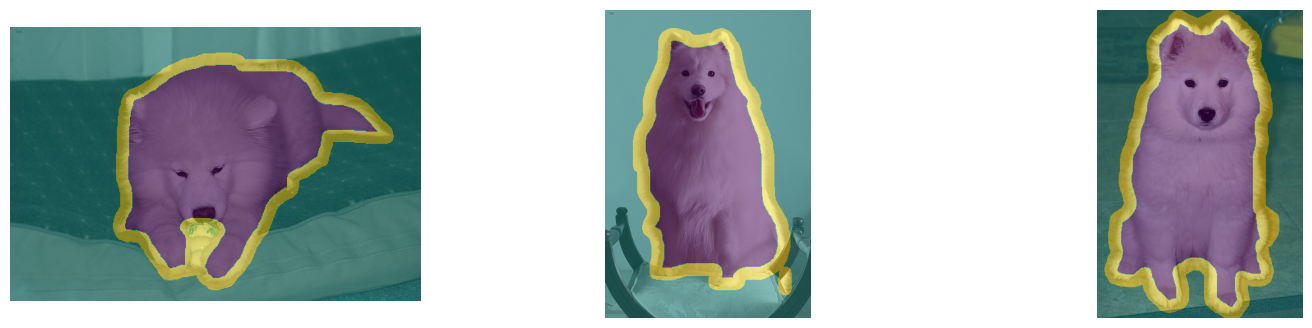

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 4))
# plot the three images with their segmentations
plt.subplot(131)
plt.imshow(img1)
plt.imshow(seg1, alpha=0.5)
plt.axis('off')
plt.subplot(132)
plt.imshow(img2)
plt.imshow(seg2, alpha=0.5)
plt.axis('off')
plt.subplot(133)
plt.imshow(img3)
plt.imshow(seg3, alpha=0.5)
plt.axis('off')

plt.show()

Groundtruth masks are **trimaps** with regions corresponding to : pet body (label `1`), background (label `2`) and ambiguous (pet body boundaries and/or any accessory such as collars) areas (label `3`).

**Question 2 -** Store images and associated masks in single array structures (`imgs` and `segs`) after `64x64` reshaping for further deep learning processing. Background and ambiguous areas will be labeled as `0`, pet body regions at `1`.

In [58]:
import numpy as np
from skimage.transform import resize

id_min, id_max = 1, 200
size_ = 64
imgs = np.ndarray((id_max, size_, size_, 3), dtype=np.float32)
segs = np.ndarray((id_max, size_, size_, 1), dtype=np.uint8)
idxs = []

for id_ in range(id_min, id_max+1):
    name = 'samoyed-'+str(id_)
    img = io.imread(name+'.jpg')
    seg = io.imread(name+'.png')
    imgs[id_-1,:,:,:] = resize(img, (size_, size_), preserve_range=True).astype(np.float32)
    segs[id_-1,:,:,0] = resize(seg, (size_, size_), preserve_range=True).astype(np.uint8)
    # background/ambiguous areas at 0, pet body regions at 1
    segs[id_-1,:,:,0] = (segs[id_-1,:,:,0] == 1).astype(np.uint8)
    idxs.append(name)

**Question 3 -** Implement and apply a function `normalization()` which standardizes the dataset (center to the mean and scale to unit variance).

In [59]:
def normalization(imgs):
    imgs = imgs.astype('float32', copy=False)
    for i in range(imgs.shape[0]):
        imgs[i] -= np.mean(imgs[i])
        imgs[i] /= np.std(imgs[i])
    return imgs

imgs = normalization(imgs)

Now, let us display the first four images with associated **binary** groundtruth masks.

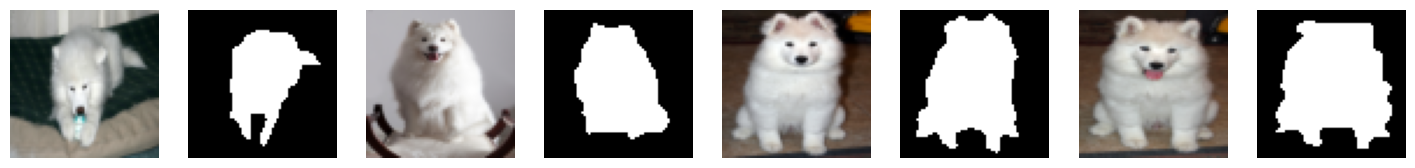

In [60]:
from skimage.exposure import rescale_intensity

plt.figure(figsize=(18, 4))
plt.subplot(181)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[0], in_range=(np.min(imgs[0]),np.max(imgs[0])), out_range=(0,1)))
plt.subplot(182)
plt.axis('off')
plt.imshow(segs[0,:,:,0], cmap='gray')
plt.subplot(183)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[1], in_range=(np.min(imgs[1]),np.max(imgs[1])), out_range=(0,1)))
plt.subplot(184)
plt.axis('off')
plt.imshow(segs[1,:,:,0], cmap='gray')
plt.subplot(185)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[2], in_range=(np.min(imgs[2]),np.max(imgs[2])), out_range=(0,1)))
plt.subplot(186)
plt.axis('off')
plt.imshow(segs[2,:,:,0], cmap='gray')
plt.subplot(187)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[3], in_range=(np.min(imgs[3]),np.max(imgs[3])), out_range=(0,1)))
plt.subplot(188)
plt.axis('off')
plt.imshow(segs[3,:,:,0], cmap='gray')
plt.show()

**Question 4 -** Divide the dataset into 2 subsets. The first `80%` will belong to the training set, the last `20%` to the test set.

In [61]:
ratio = 0.8
split = int(len(imgs)*ratio)
print('dataset size =', len(imgs), '; first', split, 'images for training, remaining for test')
train_imgs = imgs[:split] # training images
train_segs = segs[:split] # training segmentation masks
test_imgs  = imgs[split:] # test images
test_segs  = segs[split:] # test segmentation masks
train_idxs = idxs[:split] # training image ids
test_idxs  = idxs[split:] # test image ids

dataset size = 200 ; first 160 images for training, remaining for test


The functions provided below aims at computing the dice score which will be used as **loss function** in our deep learning networks.

In [62]:
import tensorflow
from tensorflow.keras import backend

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = tensorflow.cast(backend.flatten(y_true), dtype='float32')
    y_pred_f = backend.flatten(y_pred)
    intersection = backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Rather than extracting individual patches from the image and classifying these patches independently, we will first employ a stack of convolutional layers preserving the spatial size of the input : **Fully Convolutional Networks** (FCN).

**Question 5 -** Implement a FCN network with `7` convolutional layers: `2` with `32` `3x3` filters and Rectified Linear Unit (ReLU) activation, `2` with `64` `3x3` filters and ReLU activation, `2` with `128` `3x3` filters and ReLU activation as well as a final `1x1` convolutional layer with sigmoid activation to achieve pixel-wise segmentation.

In [63]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def get_model_1(img_rows, img_cols):

    inputs = Input((img_rows, img_cols, 3))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)

    conv7 = Conv2D(1, (1, 1), activation='sigmoid')(conv6)

    model = Model(inputs=[inputs], outputs=[conv7])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

Let us now display the network architecture with `model.summary()`, define the batch size and the number of epochs, define the model checkpoint (https://keras.io/callbacks/), run the training with `model.fit()` and display how the dice score evolves during training for both training and test datasets.

In [64]:
model_1 = get_model_1(size_, size_)
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_31 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 conv2d_32 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_33 (Conv2D)          (None, 64, 64, 128)       1475

In [65]:
batch_size = 10
epochs = 200

In [66]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('./weights.hdf5', monitor='val_dice_coef', verbose=0, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')

By using the option `save_best_only=True`, the latest best model according to the quantity monitored (`val_dice_coef`) will not be overwritten.

In [67]:
hist_1 = model_1.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])

Epoch 1/200
16/16 [==============================] - 2s 38ms/step - loss: -0.5078 - dice_coef: 0.5078 - val_loss: -0.4147 - val_dice_coef: 0.4147
Epoch 2/200
16/16 [==============================] - 0s 19ms/step - loss: -0.6252 - dice_coef: 0.6252 - val_loss: -0.5325 - val_dice_coef: 0.5325
Epoch 3/200
16/16 [==============================] - 0s 18ms/step - loss: -0.6569 - dice_coef: 0.6569 - val_loss: -0.5344 - val_dice_coef: 0.5344
Epoch 4/200
16/16 [==============================] - 0s 18ms/step - loss: -0.6623 - dice_coef: 0.6623 - val_loss: -0.5498 - val_dice_coef: 0.5498
Epoch 5/200
16/16 [==============================] - 0s 18ms/step - loss: -0.6718 - dice_coef: 0.6718 - val_loss: -0.5675 - val_dice_coef: 0.5675
Epoch 6/200
16/16 [==============================] - 0s 17ms/step - loss: -0.6764 - dice_coef: 0.6764 - val_loss: -0.5597 - val_dice_coef: 0.5597
Epoch 7/200
16/16 [==============================] - 0s 18ms/step - loss: -0.6825 - dice_coef: 0.6825 - val_loss: -0.5852 - 

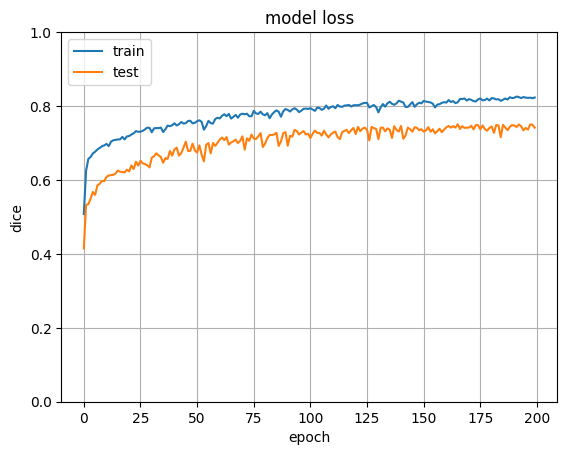

In [68]:
def display_history(hist):
    plt.plot(hist.history['dice_coef'])
    plt.plot(hist.history['val_dice_coef'])
    plt.title('model loss')
    plt.grid()
    plt.ylabel('dice')
    plt.ylim([0,1])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

display_history(hist_1)

**Question 6 -** Using the provided `dice_assessment()` and `visualize_predicted_boundary()` functions to be read and understood, implement and apply `make_prediction()` to provide for each test image the predicted segmentation mask as well as the dice score. Dice scores will be stored in the array `dices`. What is the average dice score obtained for the test set?

In [69]:
def dice_assessment(result, GT, label=1):
    A = GT == label
    B = result == label
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    TN = len(np.nonzero((~A)*(~B))[0])
    dice = 0
    if (FP+2*TP+FN) != 0 :
        dice = float(2)*TP/(FP+2*TP+FN)
    return dice

In [70]:
from skimage.segmentation import mark_boundaries

def visualize_predicted_boundary(img, pred, groundtruth):
    img = rescale_intensity(img, in_range=(np.min(img),np.max(img)), out_range=(0,1))
    out = mark_boundaries(img, groundtruth, color=(0, 1, 0), background_label=4)
    out = mark_boundaries(out, pred, color=(1, 0, 0), background_label=2)
    return out

In [71]:
def make_prediction(model, test_idxs, test_imgs, test_segs):
    dices = []
    for idx, id_ in enumerate(test_idxs):
        pred = (model.predict(test_imgs[idx:idx+1], verbose=0)[0,:,:,0] > 0.5).astype(np.uint8)
        groundtruth = test_segs[idx,:,:,0]
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.axis('off')
        plt.imshow(rescale_intensity(test_imgs[idx], in_range=(np.min(test_imgs[idx]),np.max(test_imgs[idx])), out_range=(0,1)))
        plt.subplot(132)
        plt.axis('off')
        plt.imshow(pred, cmap='gray')
        plt.subplot(133)
        plt.axis('off')
         # image with super-imposed prediction and groundruth
        plt.imshow(visualize_predicted_boundary(test_imgs[idx], pred, groundtruth))
        plt.show()
        dice = dice_assessment(pred, groundtruth)
        print('dice for', id_, ': %02.3f'%(dice))
        dices.append(dice)
    return np.array(dices)

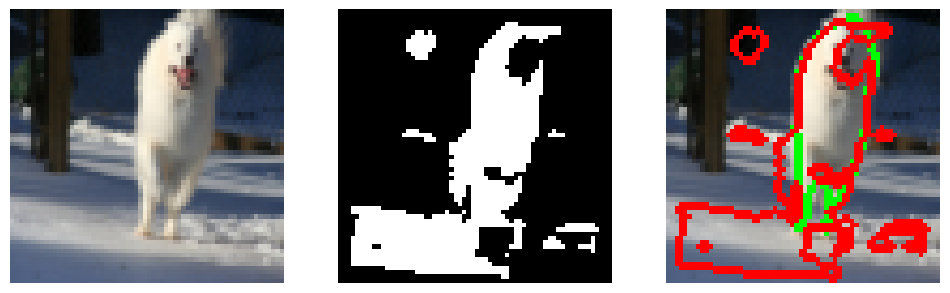

dice for samoyed-161 : 0.560


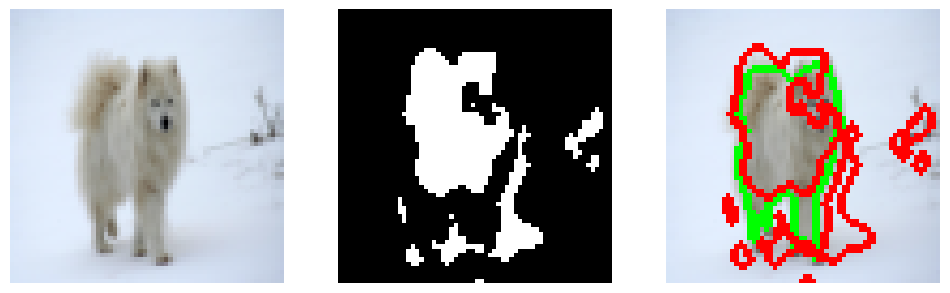

dice for samoyed-162 : 0.627


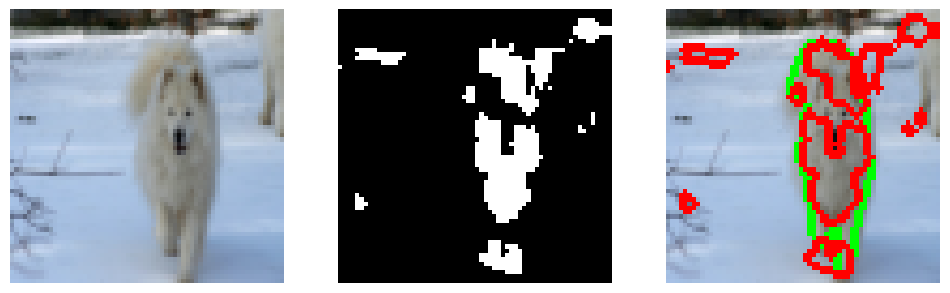

dice for samoyed-163 : 0.648


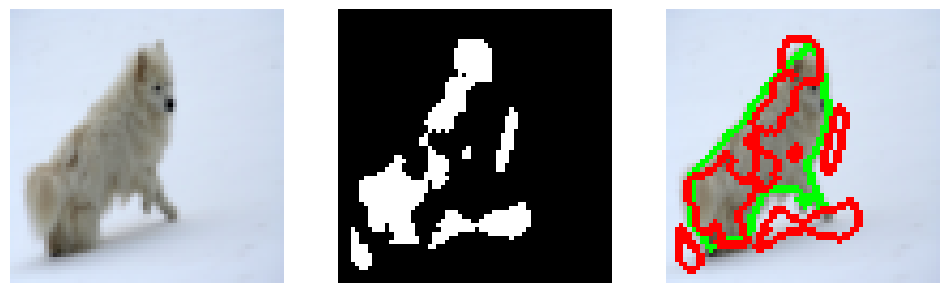

dice for samoyed-164 : 0.523


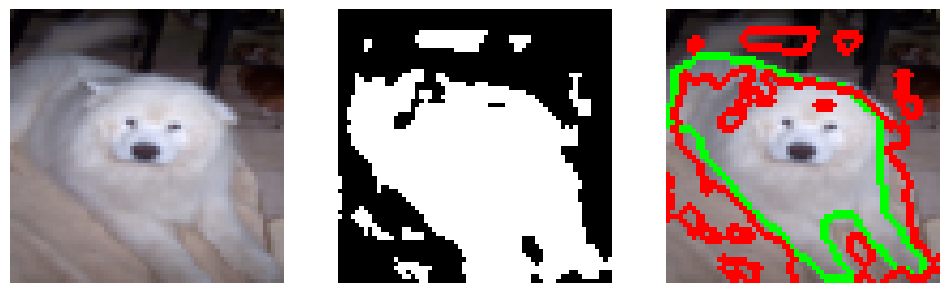

dice for samoyed-165 : 0.787


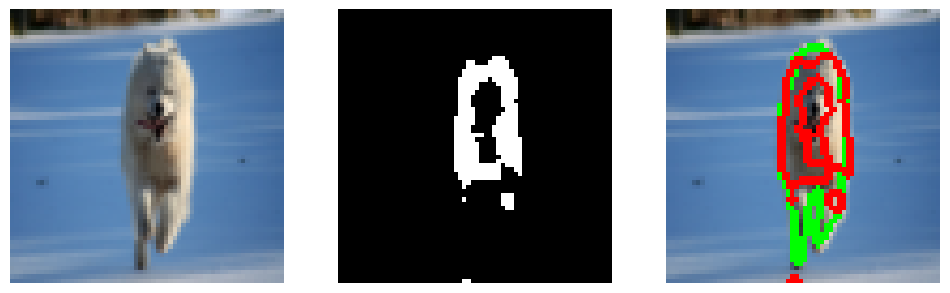

dice for samoyed-166 : 0.681


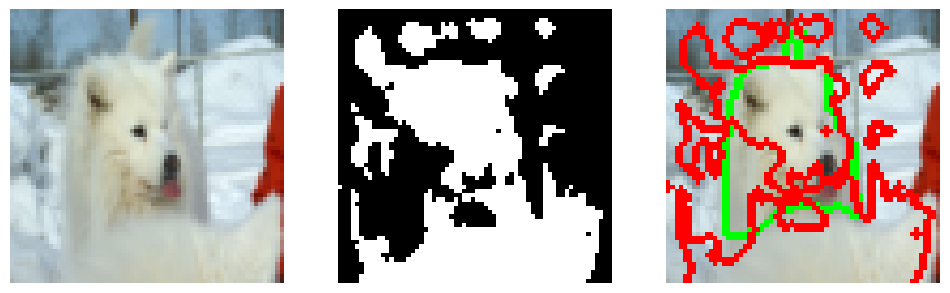

dice for samoyed-167 : 0.471


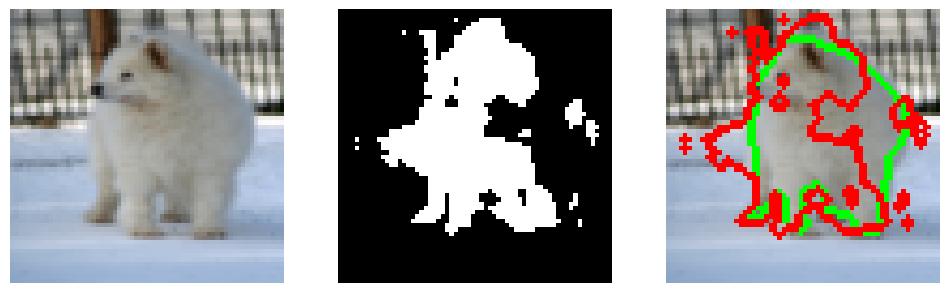

dice for samoyed-168 : 0.728


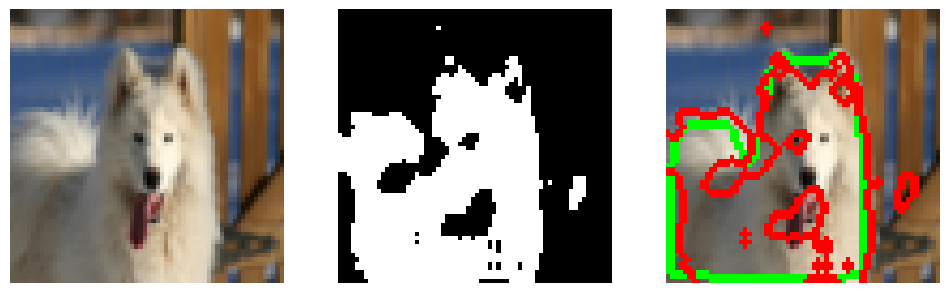

dice for samoyed-169 : 0.847


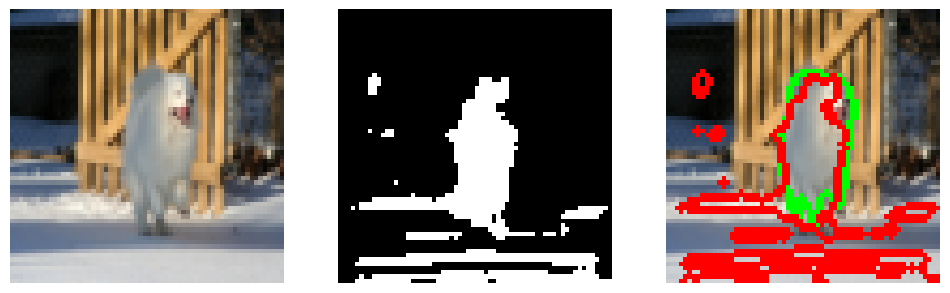

dice for samoyed-170 : 0.535


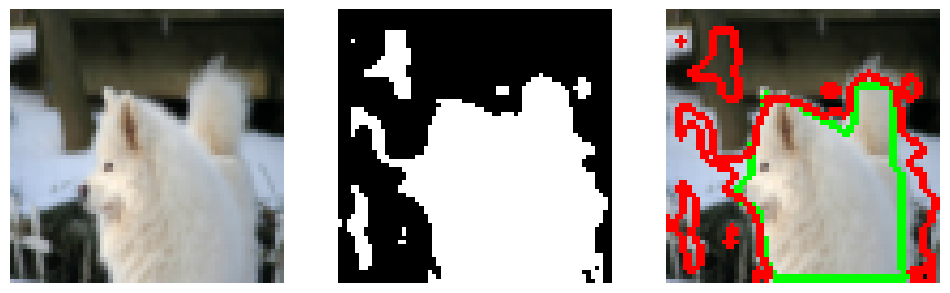

dice for samoyed-171 : 0.818


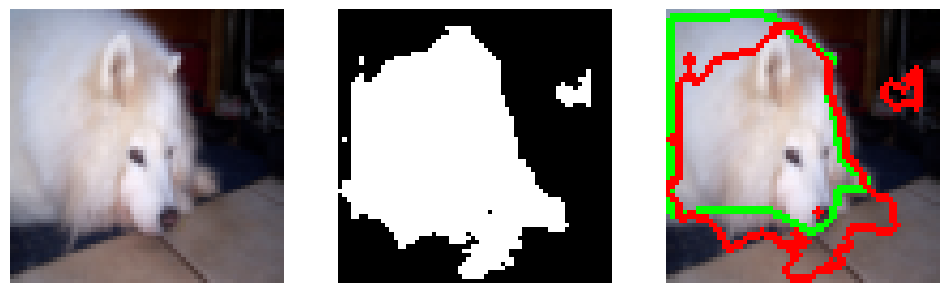

dice for samoyed-172 : 0.788


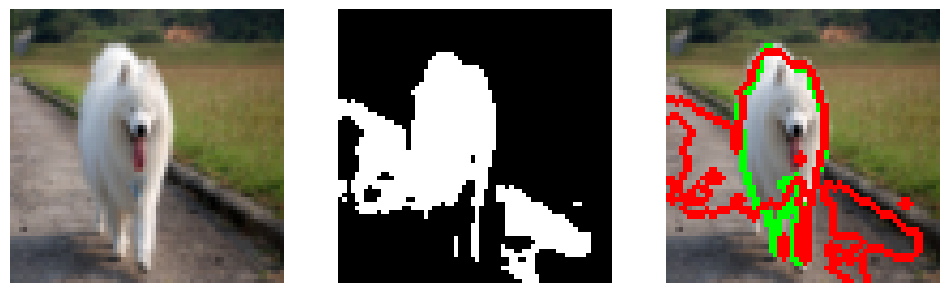

dice for samoyed-173 : 0.622


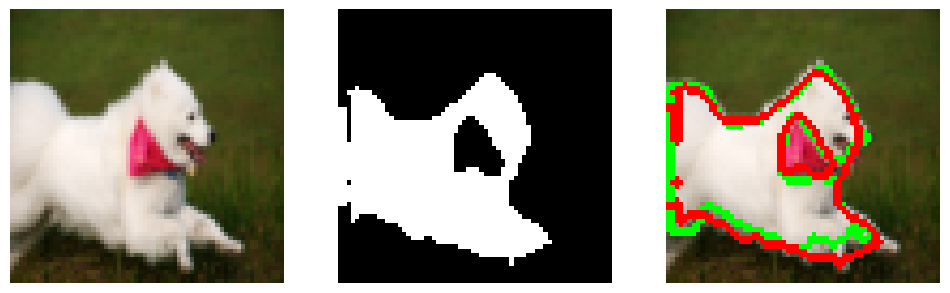

dice for samoyed-174 : 0.890


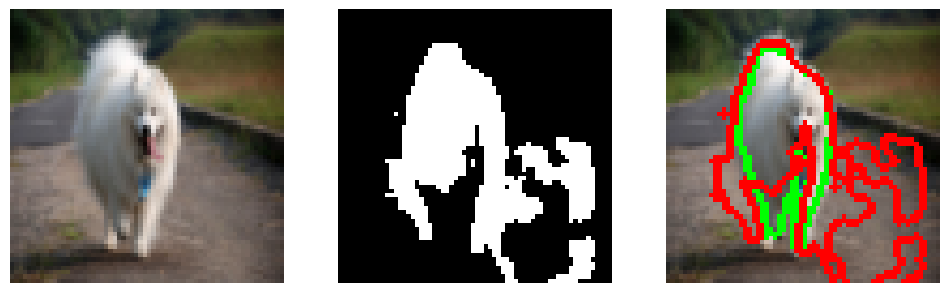

dice for samoyed-175 : 0.605


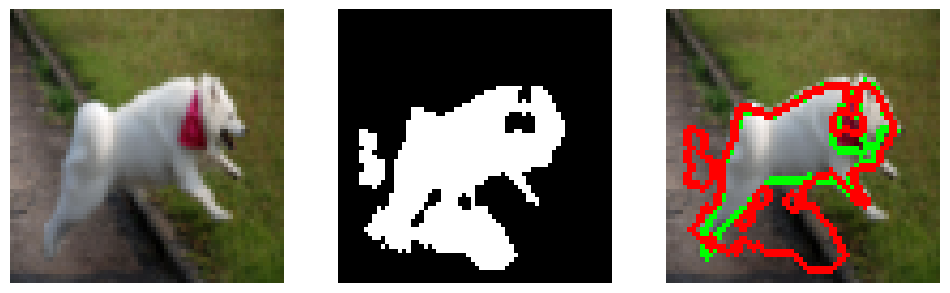

dice for samoyed-176 : 0.720


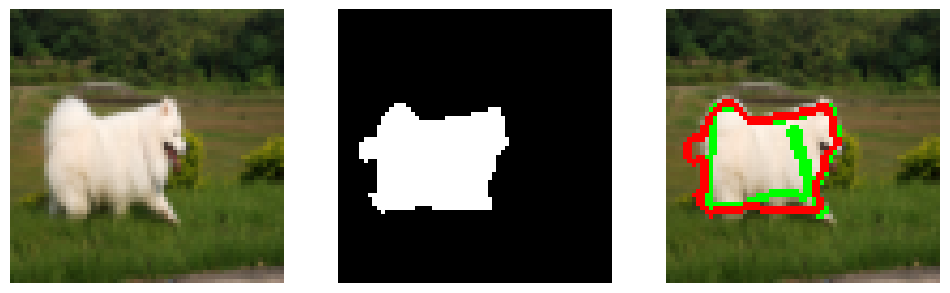

dice for samoyed-177 : 0.869


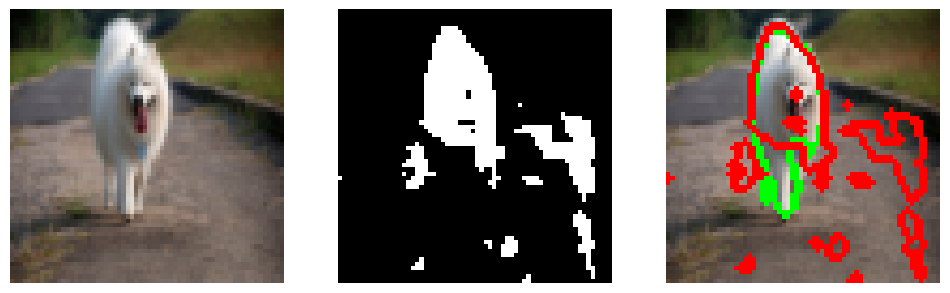

dice for samoyed-178 : 0.613


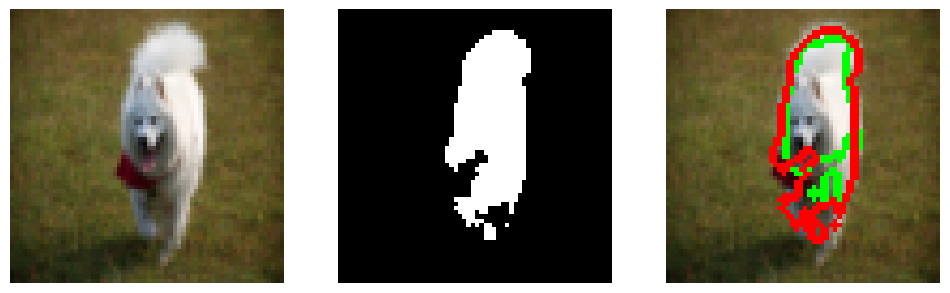

dice for samoyed-179 : 0.754


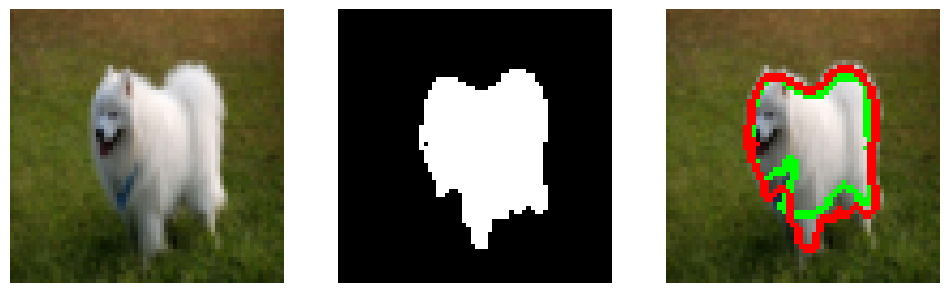

dice for samoyed-180 : 0.871


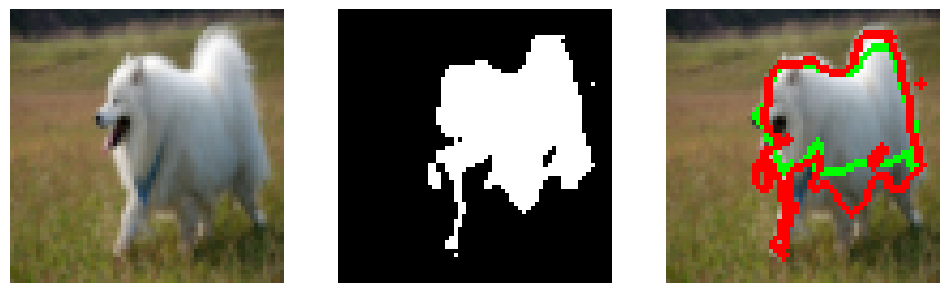

dice for samoyed-181 : 0.831


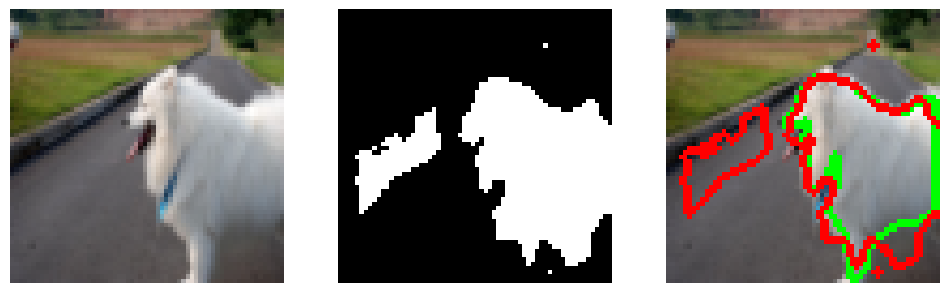

dice for samoyed-182 : 0.813


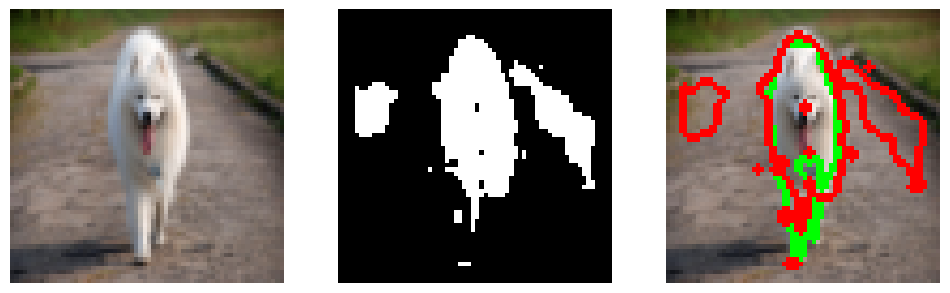

dice for samoyed-183 : 0.640


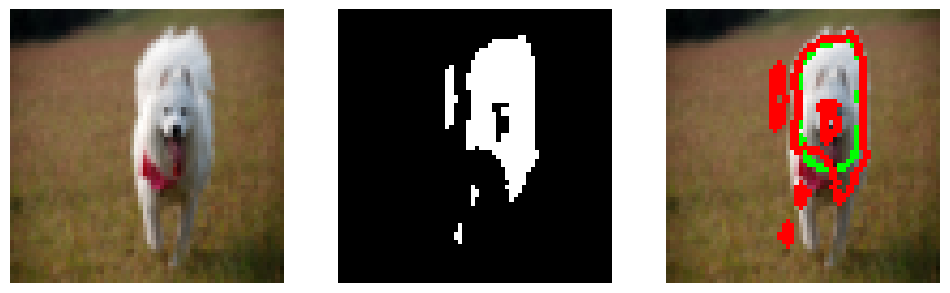

dice for samoyed-184 : 0.817


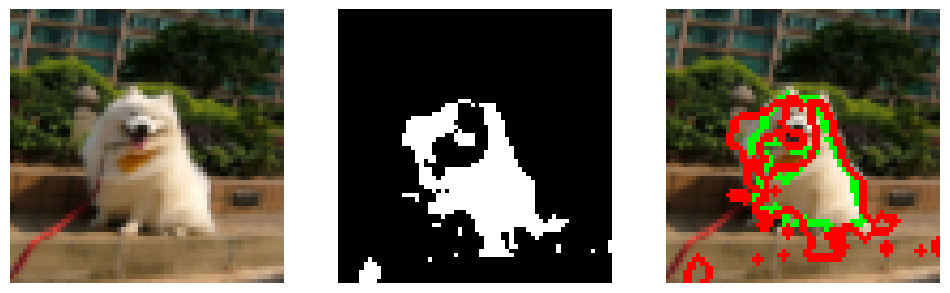

dice for samoyed-185 : 0.680


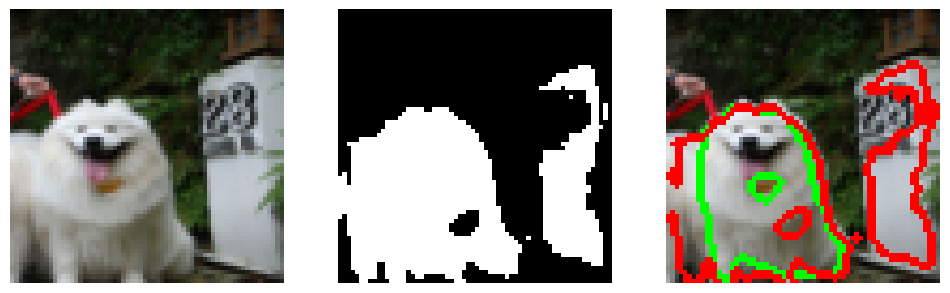

dice for samoyed-186 : 0.682


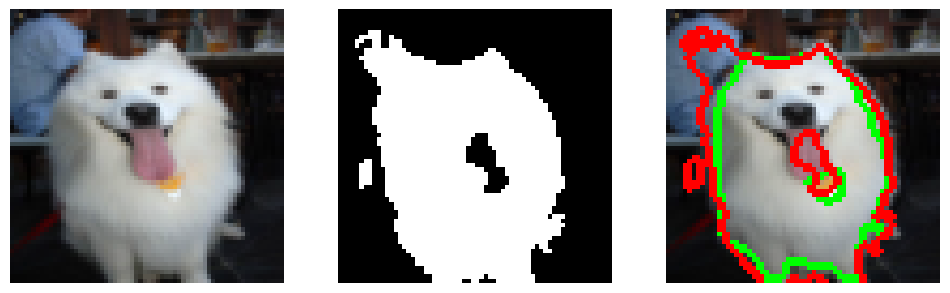

dice for samoyed-187 : 0.878


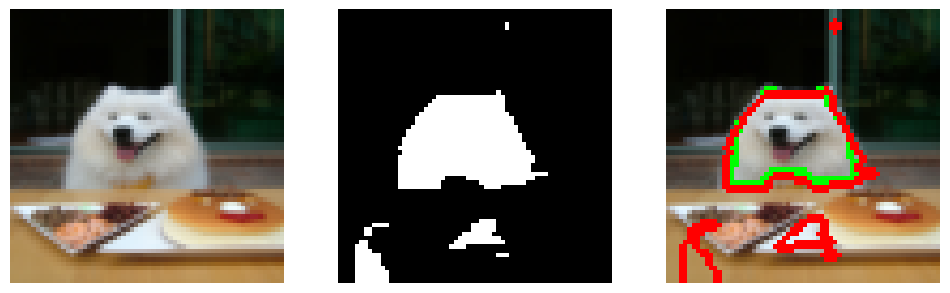

dice for samoyed-188 : 0.823


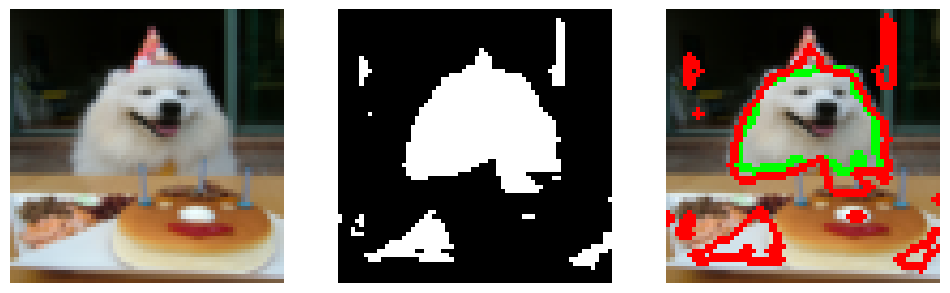

dice for samoyed-189 : 0.748


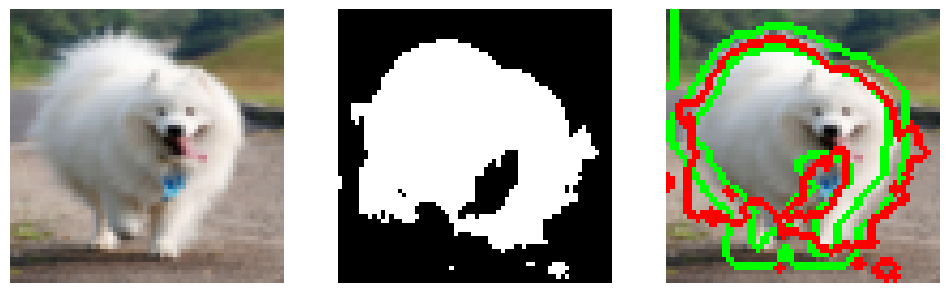

dice for samoyed-190 : 0.568


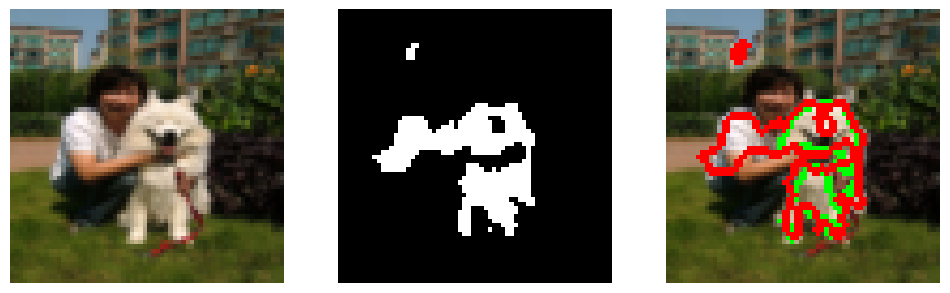

dice for samoyed-191 : 0.620


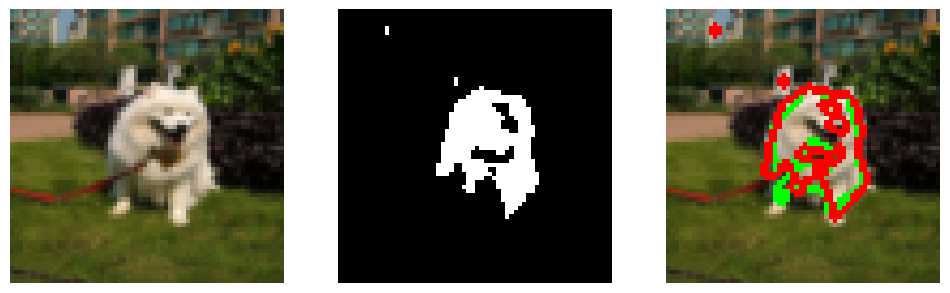

dice for samoyed-192 : 0.810


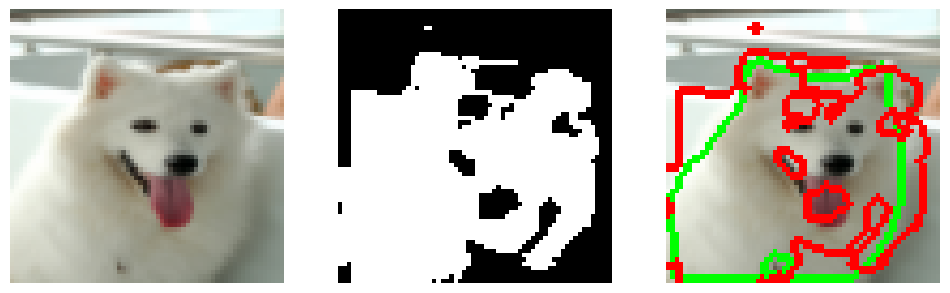

dice for samoyed-193 : 0.804


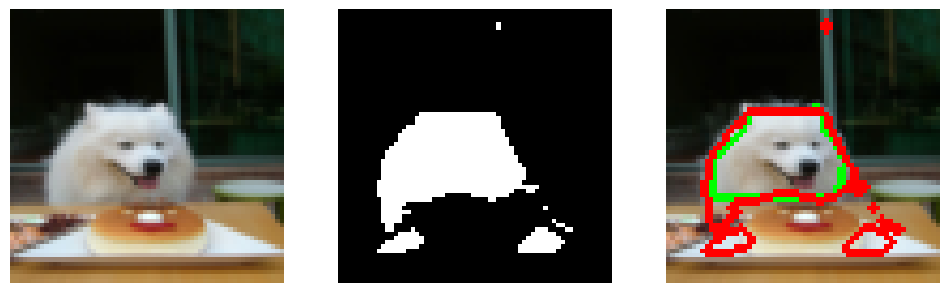

dice for samoyed-194 : 0.830


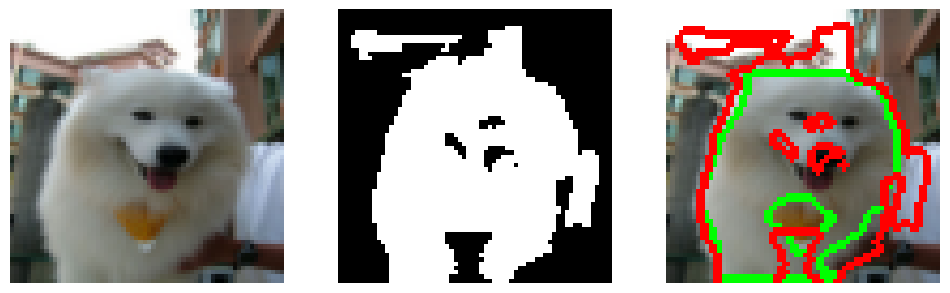

dice for samoyed-195 : 0.799


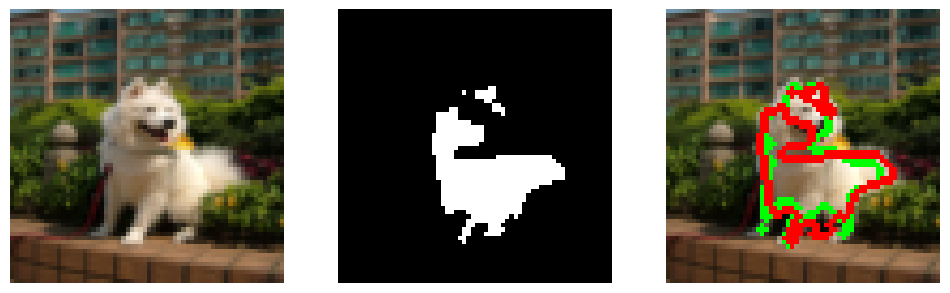

dice for samoyed-196 : 0.770


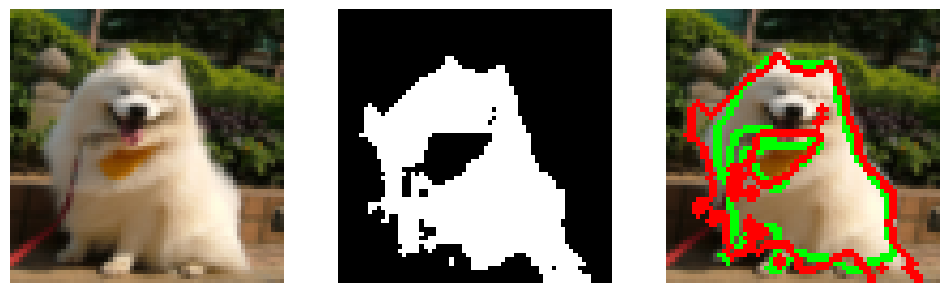

dice for samoyed-197 : 0.823


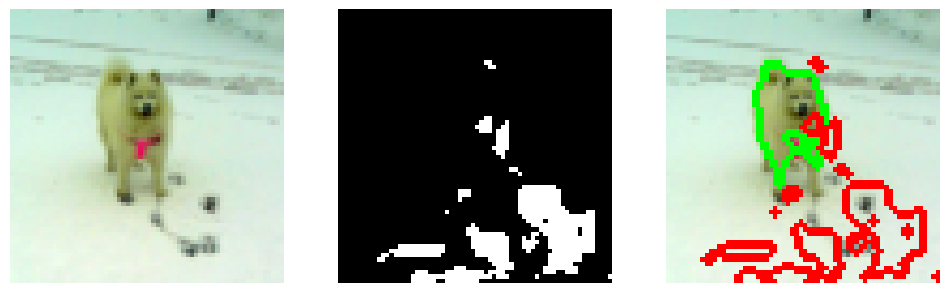

dice for samoyed-198 : 0.033


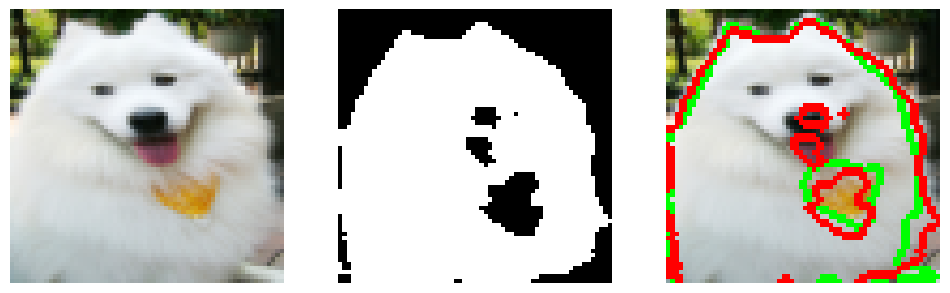

dice for samoyed-199 : 0.928


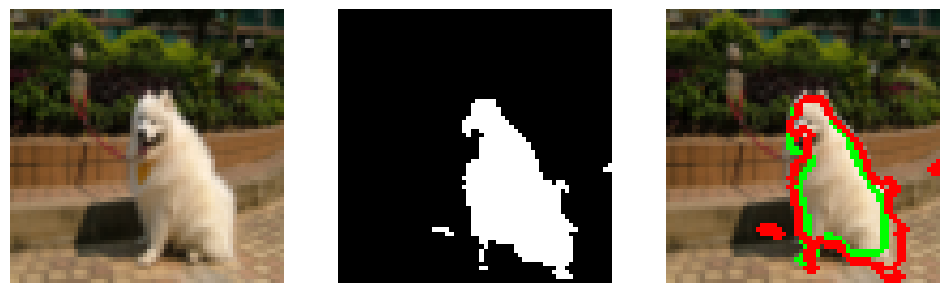

dice for samoyed-200 : 0.825
average dice: 0.717


In [73]:
dices_1 = make_prediction(model_1, test_idxs, test_imgs, test_segs)
print('average dice: %02.3f'%(np.mean(dices_1)))

Better deep learning networks can be reached using some **downsampling** and **upsampling** operations to obtain what we call a **convolutional encoder-decoder** (CED).

**Question 7 -** Implement a new network consisting of patterns of `2` convolutional layers followed by a pooling (resp. upsampling) layer for encoding (decoding) branches using `MaxPooling2D` (`Conv2DTranspose`). Between encoding and decoding branches, `2` convolutional layers will be used (`conv3`). Convolutional layers will exploit `3x3` filters followed by ReLU activations. Spatial size will be reduced (increased) with `2×2` max pooling (upsampling) layers. The `2` first convolutional layer will generate `32` channels. This number will double after each pattern.

In [74]:
from tensorflow.keras.layers import MaxPooling2D, Conv2DTranspose

def get_model_2(img_rows, img_cols):

    inputs = Input((img_rows, img_cols, 3))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)

    up5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)

    conv6 = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=[inputs], outputs=[conv6])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

**Question 8 -** Run the training and use `make_prediction()` to provide predicted segmentation masks. What is the average dice score obtained for the test set?

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_36 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 64)        36928     
                                                           

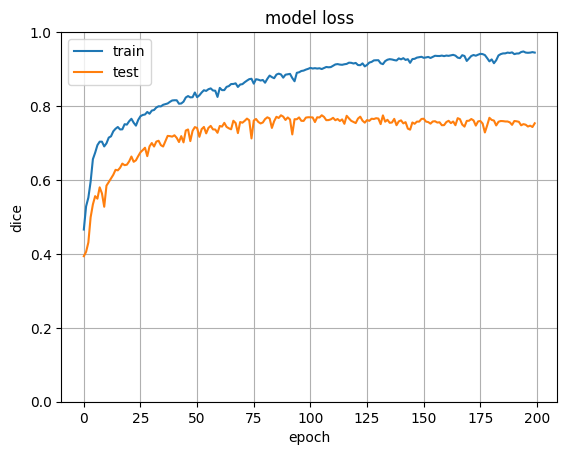

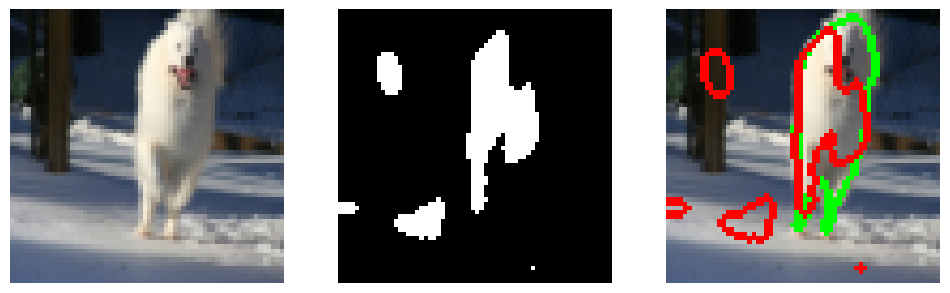

dice for samoyed-161 : 0.657


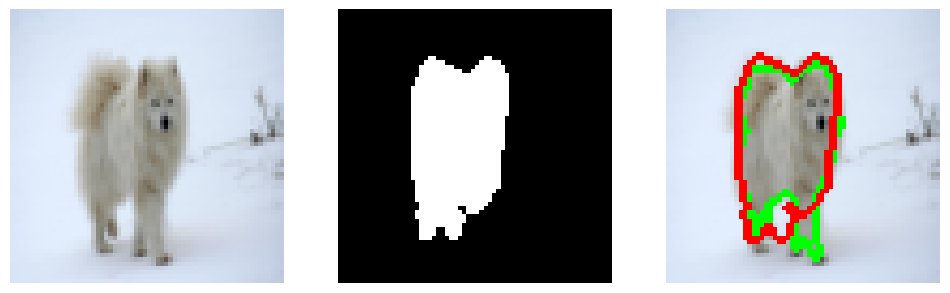

dice for samoyed-162 : 0.877


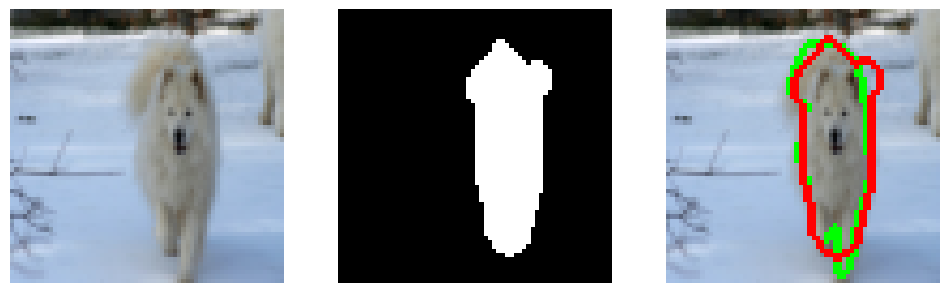

dice for samoyed-163 : 0.904


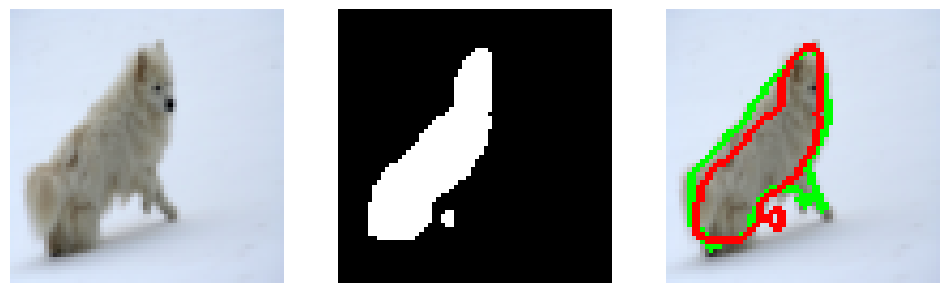

dice for samoyed-164 : 0.835


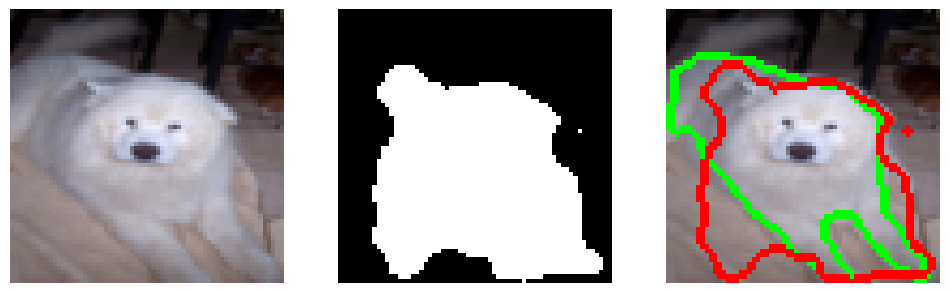

dice for samoyed-165 : 0.776


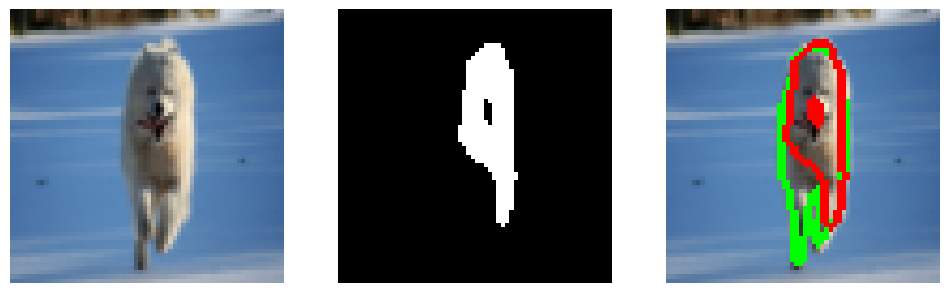

dice for samoyed-166 : 0.772


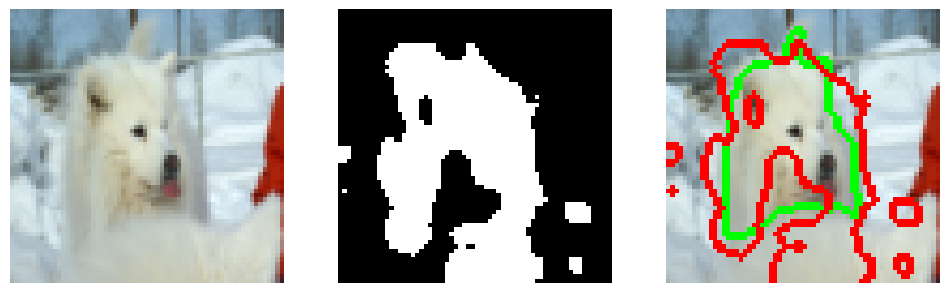

dice for samoyed-167 : 0.641


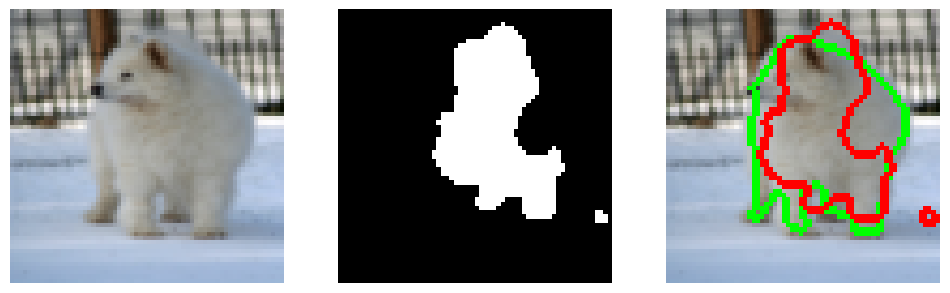

dice for samoyed-168 : 0.745


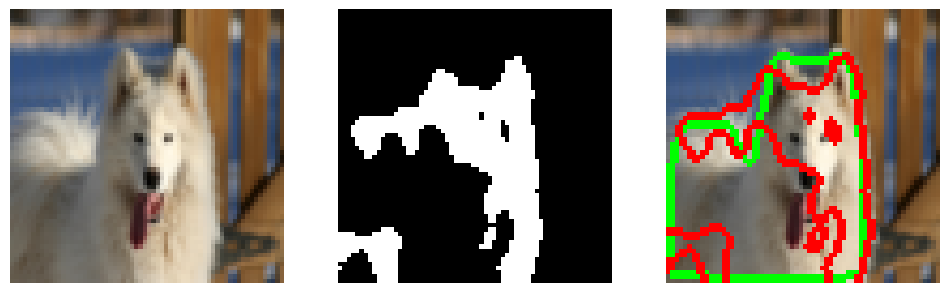

dice for samoyed-169 : 0.575


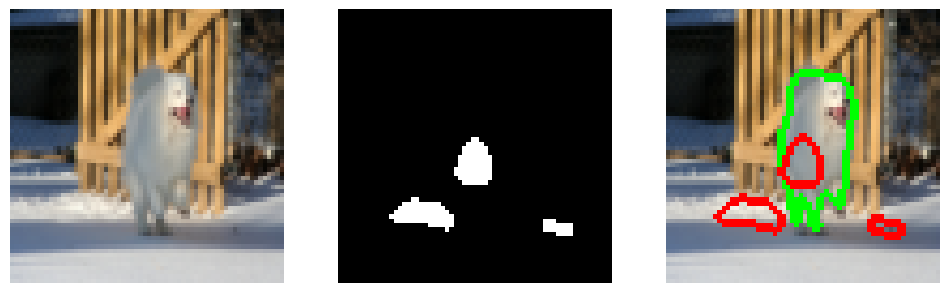

dice for samoyed-170 : 0.245


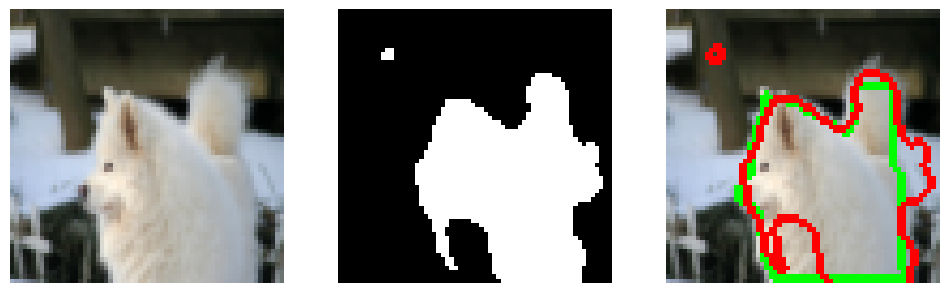

dice for samoyed-171 : 0.867


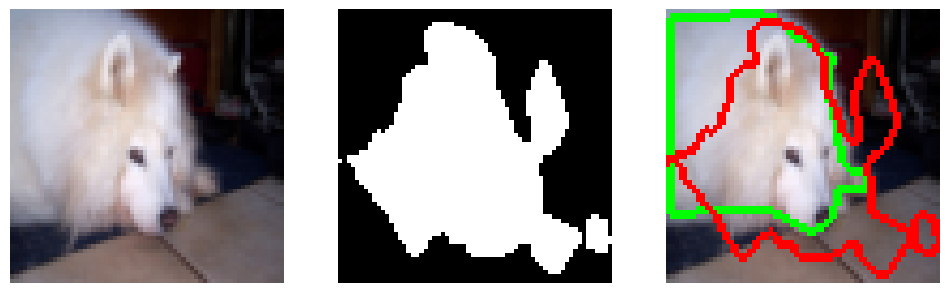

dice for samoyed-172 : 0.662


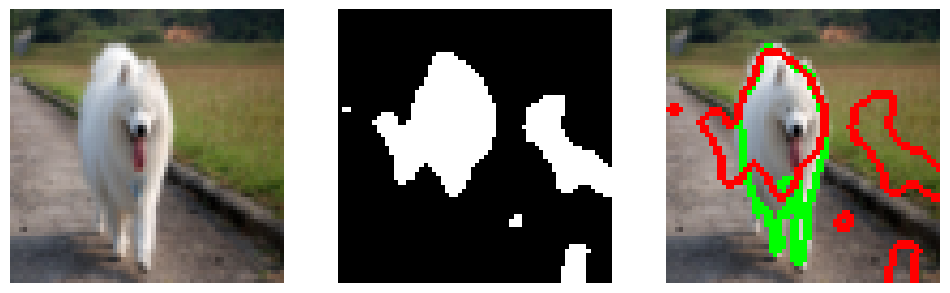

dice for samoyed-173 : 0.610


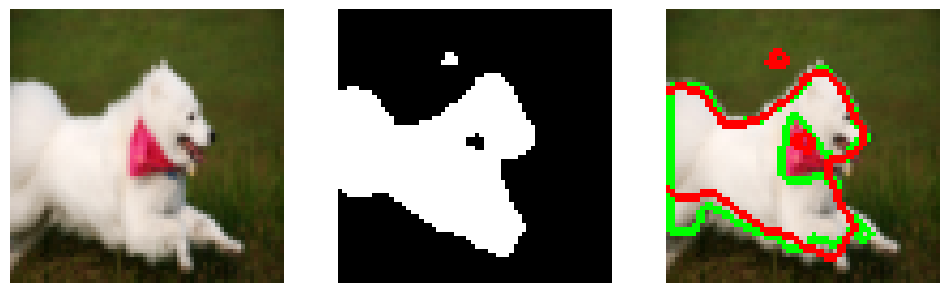

dice for samoyed-174 : 0.864


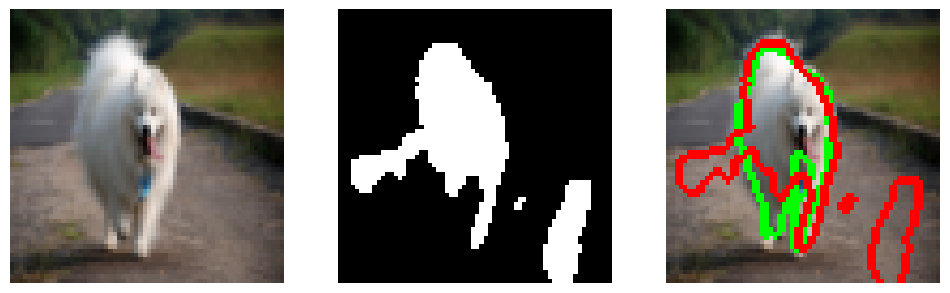

dice for samoyed-175 : 0.668


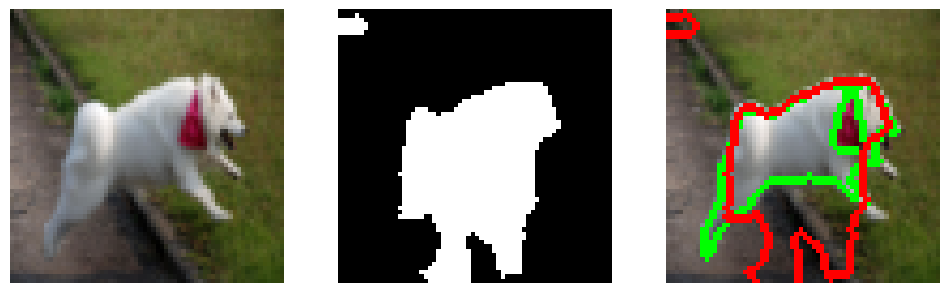

dice for samoyed-176 : 0.643


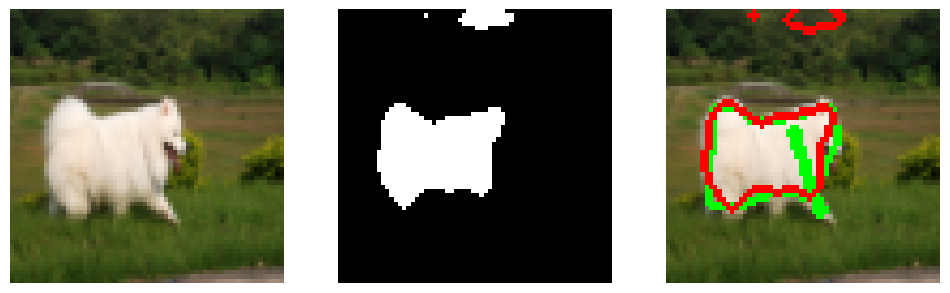

dice for samoyed-177 : 0.851


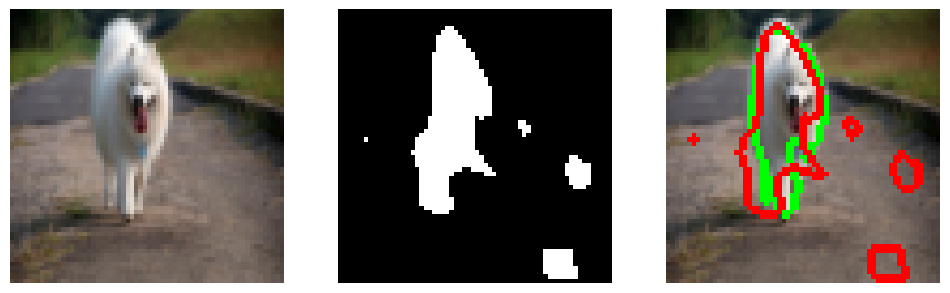

dice for samoyed-178 : 0.687


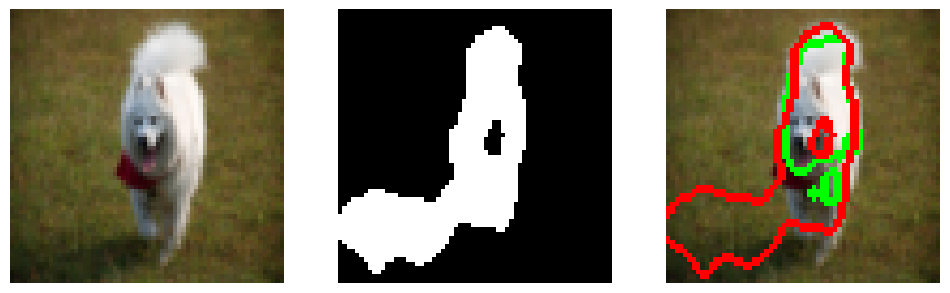

dice for samoyed-179 : 0.521


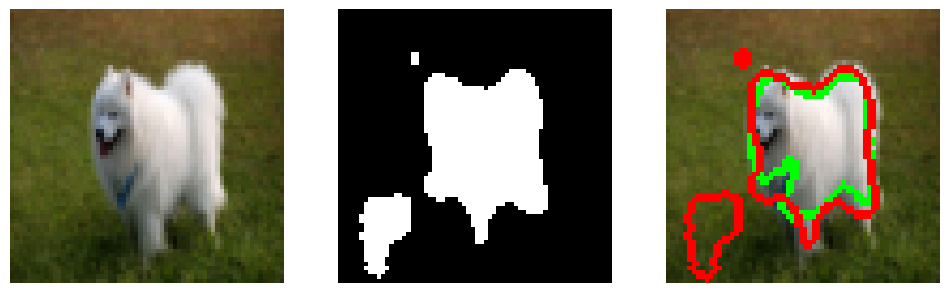

dice for samoyed-180 : 0.787


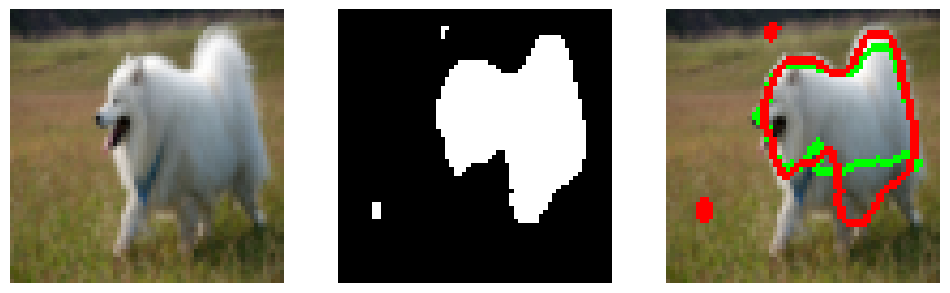

dice for samoyed-181 : 0.844


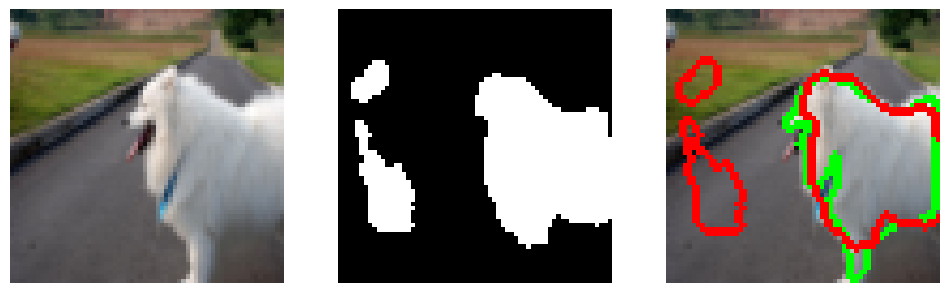

dice for samoyed-182 : 0.794


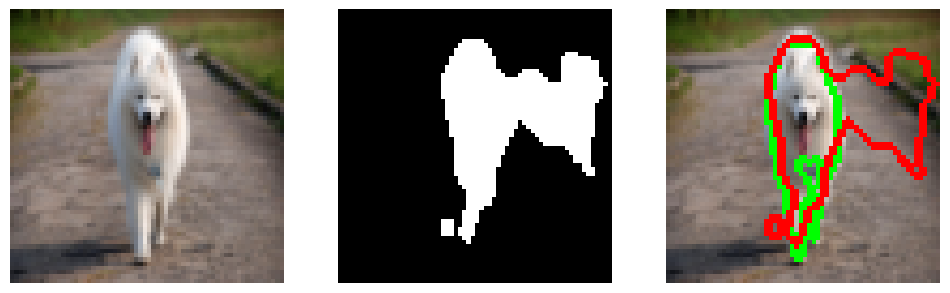

dice for samoyed-183 : 0.617


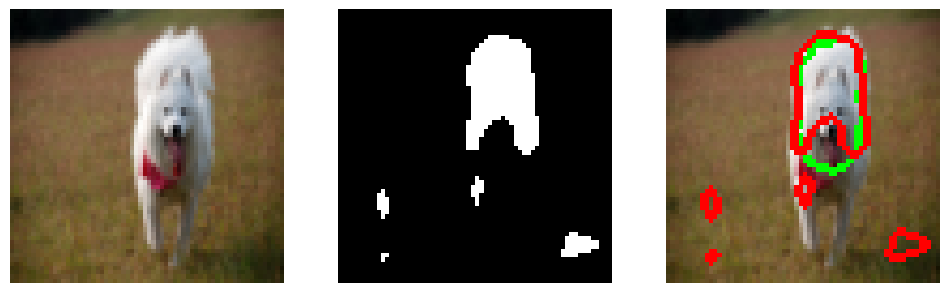

dice for samoyed-184 : 0.740


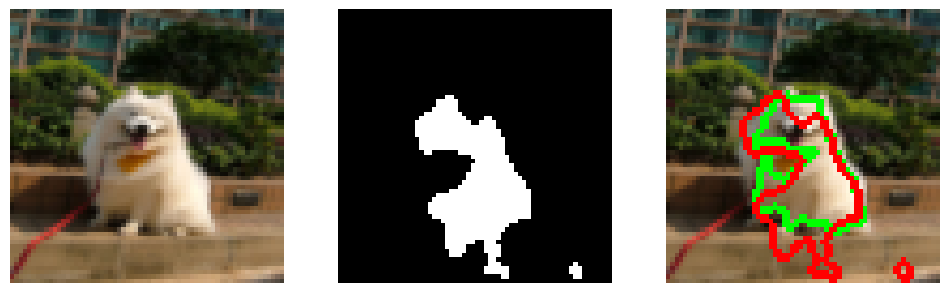

dice for samoyed-185 : 0.723


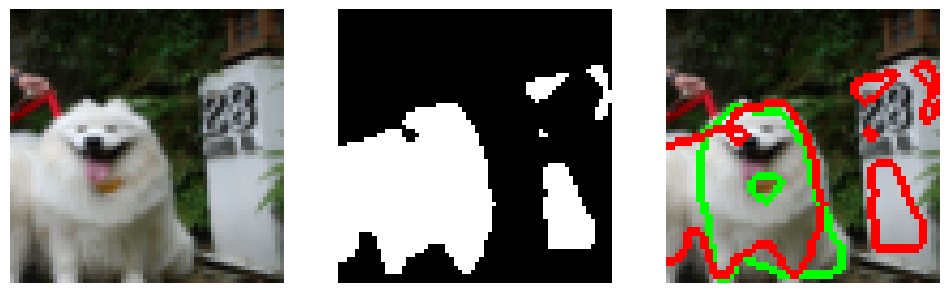

dice for samoyed-186 : 0.692


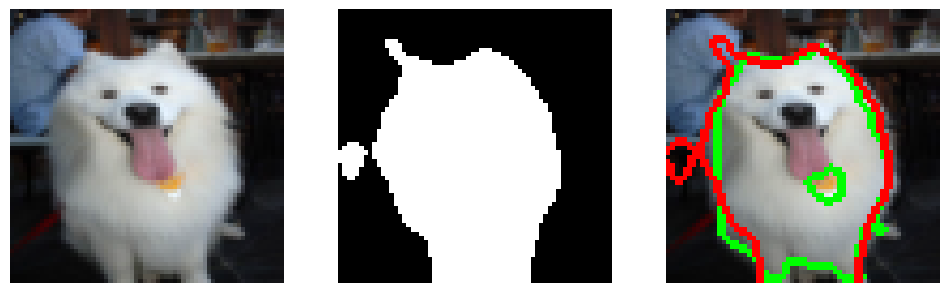

dice for samoyed-187 : 0.902


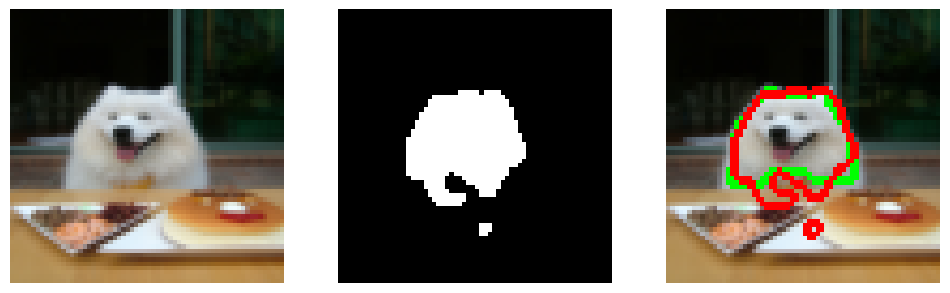

dice for samoyed-188 : 0.871


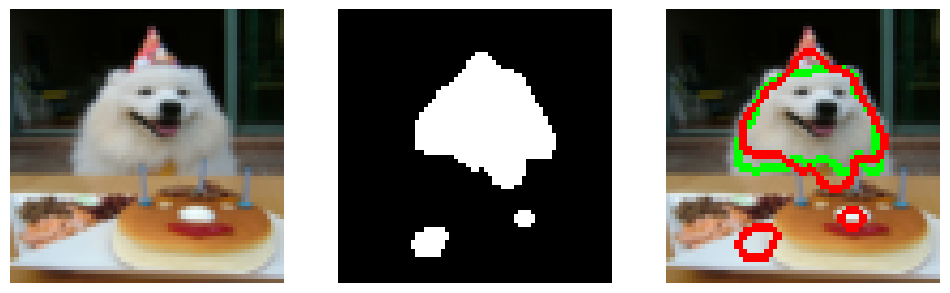

dice for samoyed-189 : 0.823


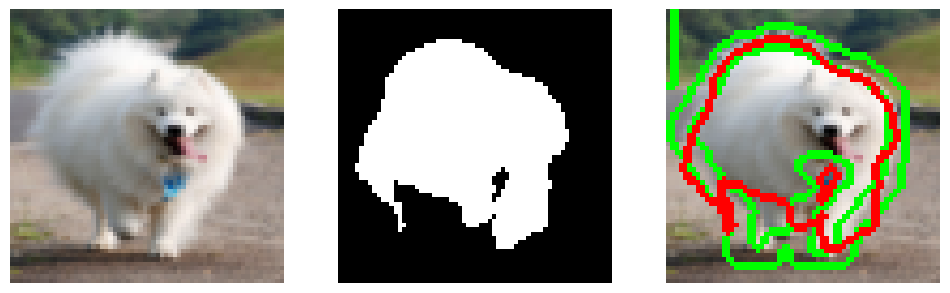

dice for samoyed-190 : 0.528


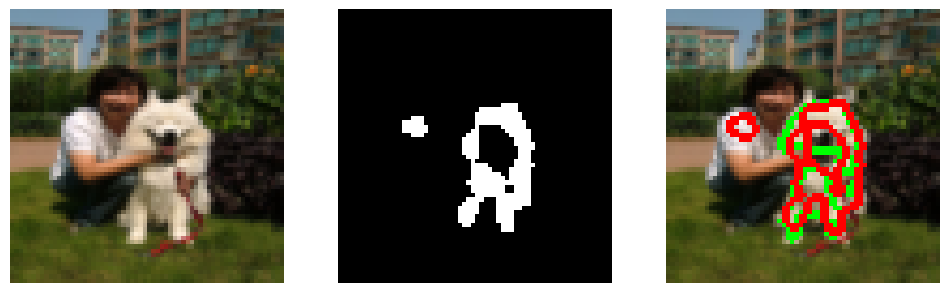

dice for samoyed-191 : 0.647


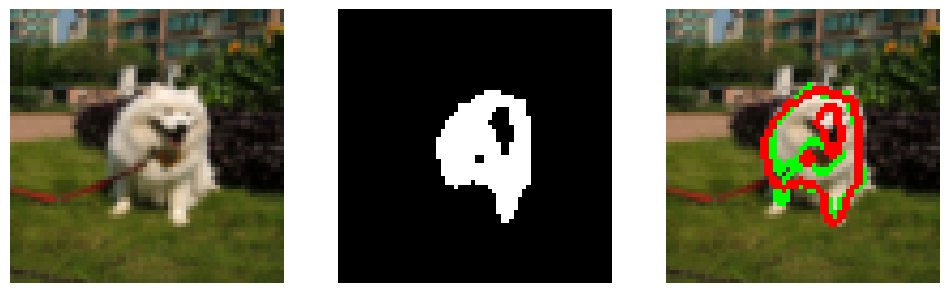

dice for samoyed-192 : 0.798


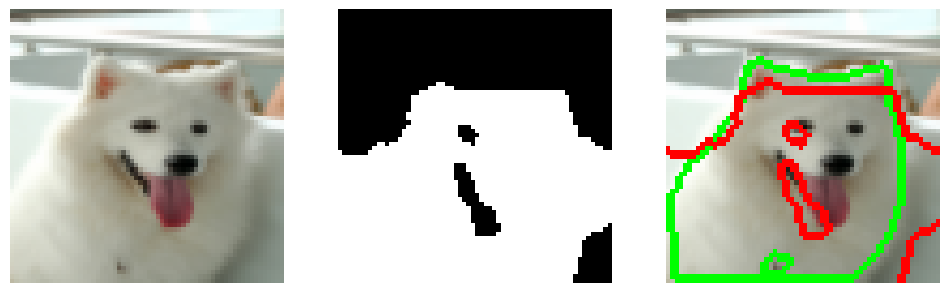

dice for samoyed-193 : 0.844


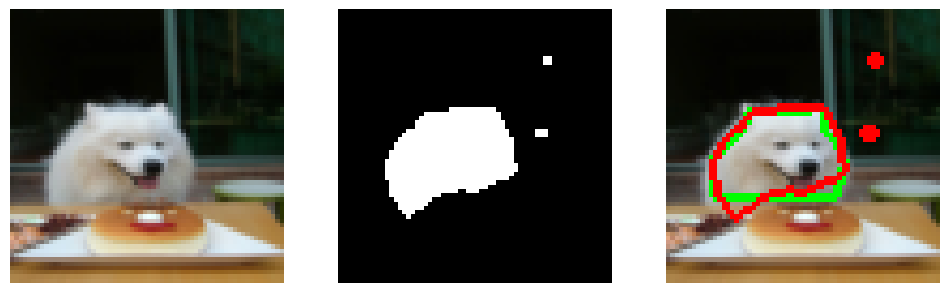

dice for samoyed-194 : 0.893


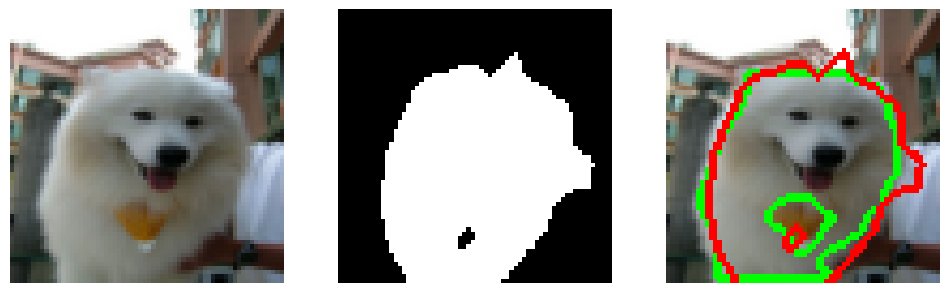

dice for samoyed-195 : 0.895


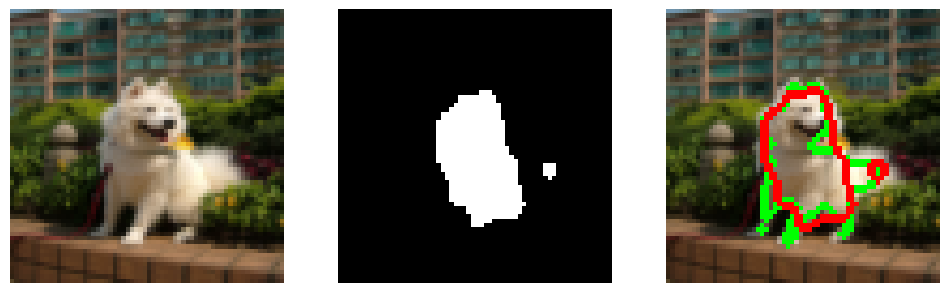

dice for samoyed-196 : 0.841


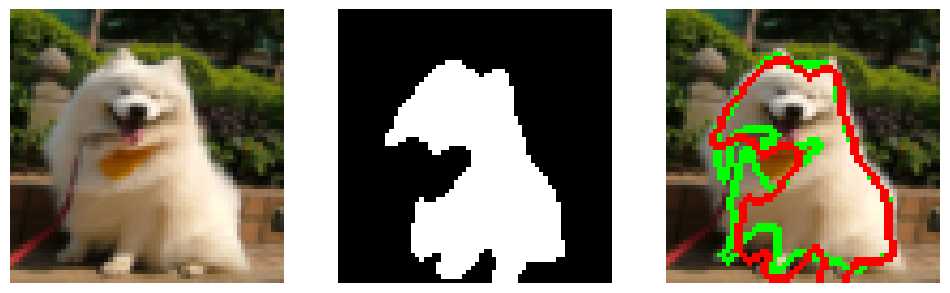

dice for samoyed-197 : 0.871


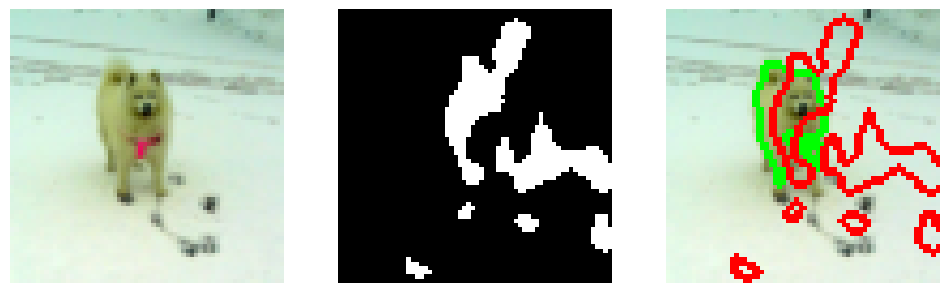

dice for samoyed-198 : 0.299


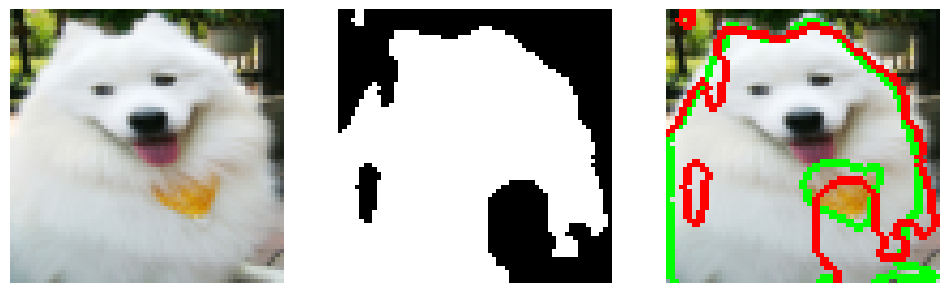

dice for samoyed-199 : 0.888


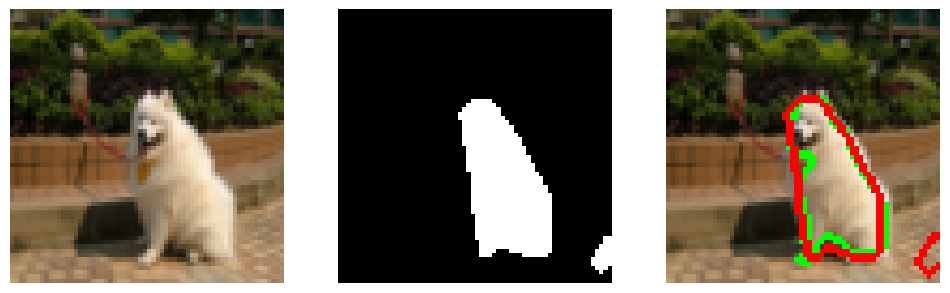

dice for samoyed-200 : 0.893
average dice: 0.740


In [75]:
model_2 = get_model_2(size_, size_)
model_2.summary()
hist_2 = model_2.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])
display_history(hist_2)
dices_2 = make_prediction(model_2, test_idxs, test_imgs, test_segs)
print('average dice: %02.3f'%(np.mean(dices_2)) )

**Question 9 -** Add **skip connections** (i.e. long-range shortcuts concatenating features from the encoder to the decoder) to the network implemented in question 7 using `concatenate`. Run the training, evaluate and comment on the reached segmentation accuracy (especially in comparison to `model_2`).

In [76]:
from tensorflow.keras.layers import concatenate

def get_model_3(img_rows, img_cols):

    inputs = Input((img_rows, img_cols, 3))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)

    up4 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)

    up5 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4), conv1], axis=3)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)

    conv6 = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=[inputs], outputs=[conv6])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_46 (Conv2D)          (None, 64, 64, 32)           896       ['input_7[0][0]']             
                                                                                                  
 conv2d_47 (Conv2D)          (None, 64, 64, 32)           9248      ['conv2d_46[0][0]']           
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)           0         ['conv2d_47[0][0]']           
 g2D)                                                                                       

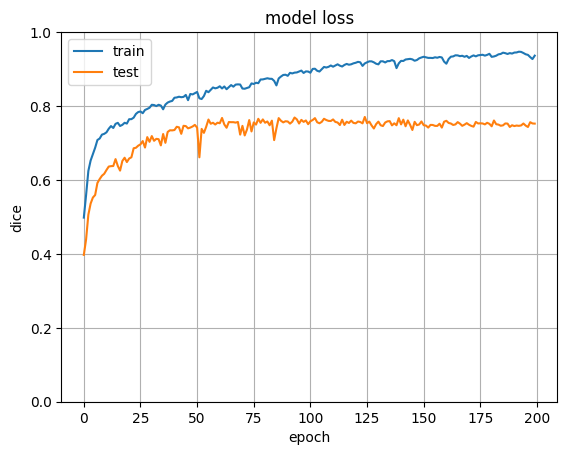

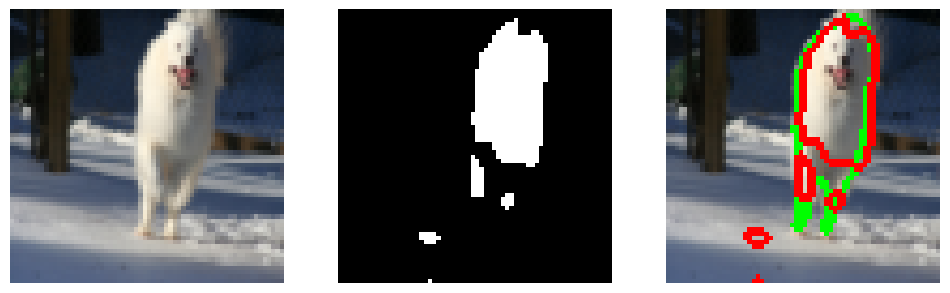

dice for samoyed-161 : 0.830


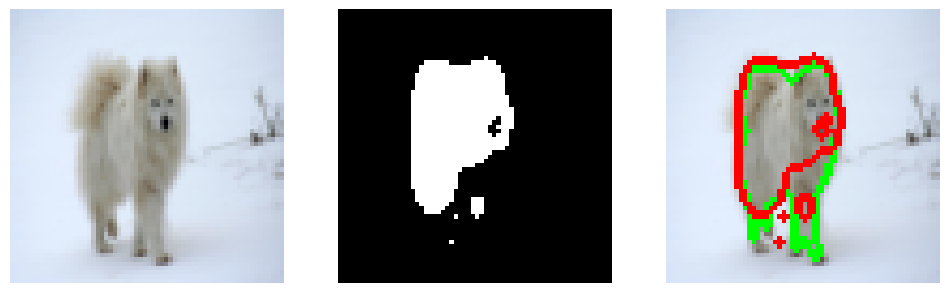

dice for samoyed-162 : 0.841


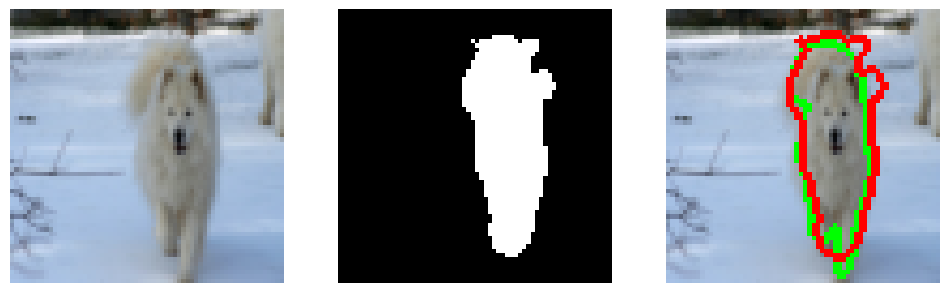

dice for samoyed-163 : 0.880


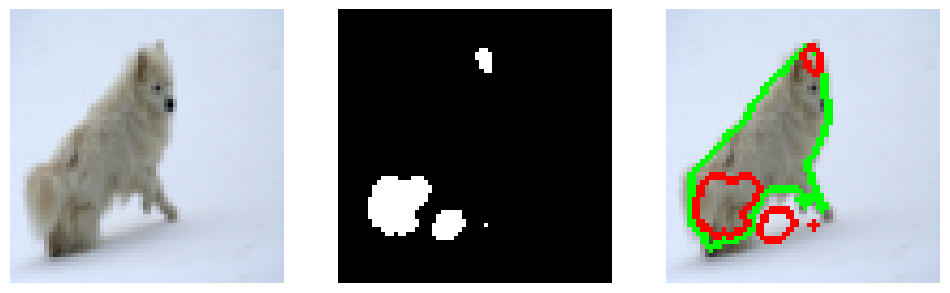

dice for samoyed-164 : 0.344


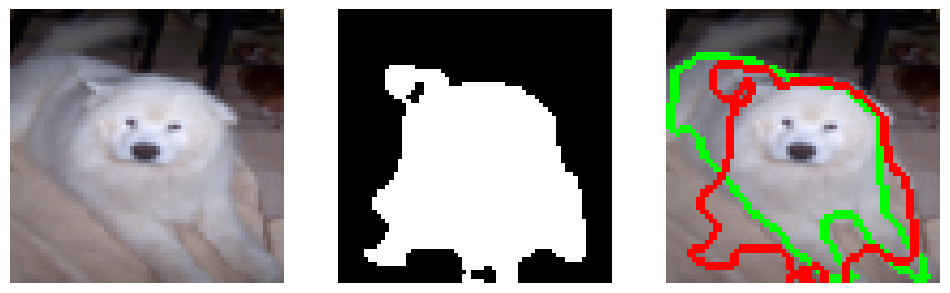

dice for samoyed-165 : 0.770


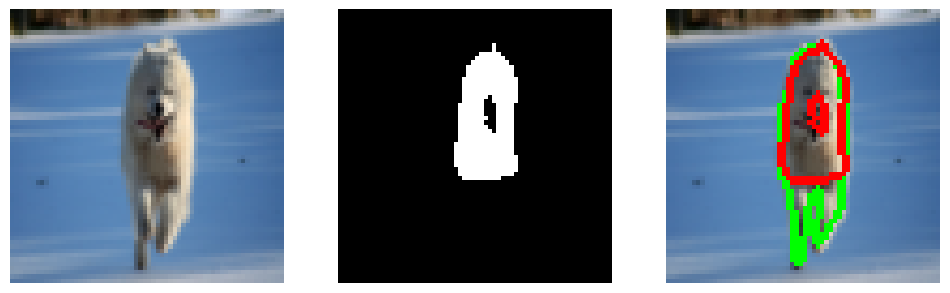

dice for samoyed-166 : 0.781


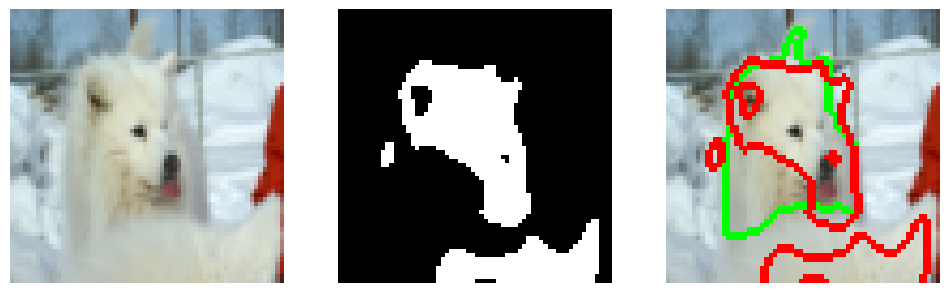

dice for samoyed-167 : 0.597


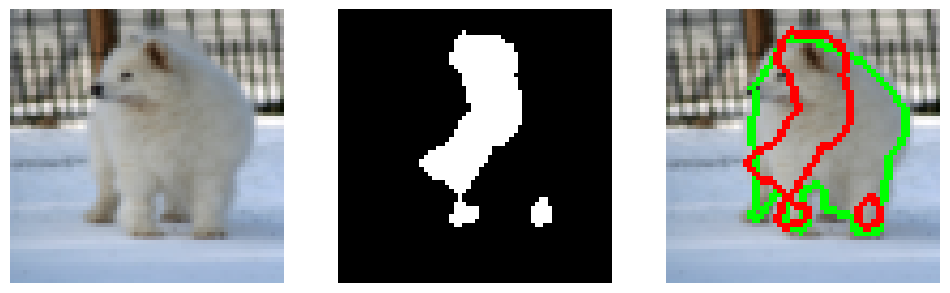

dice for samoyed-168 : 0.580


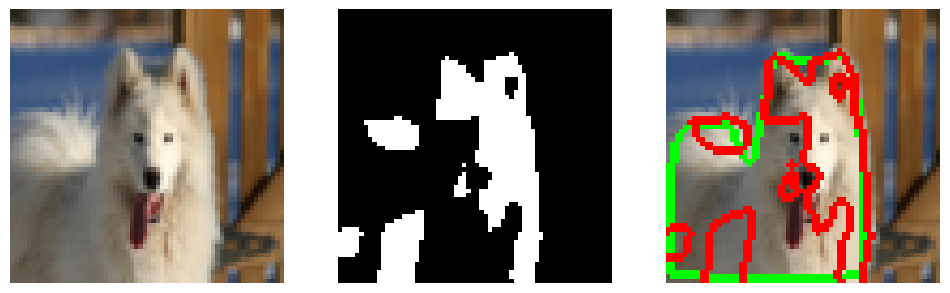

dice for samoyed-169 : 0.586


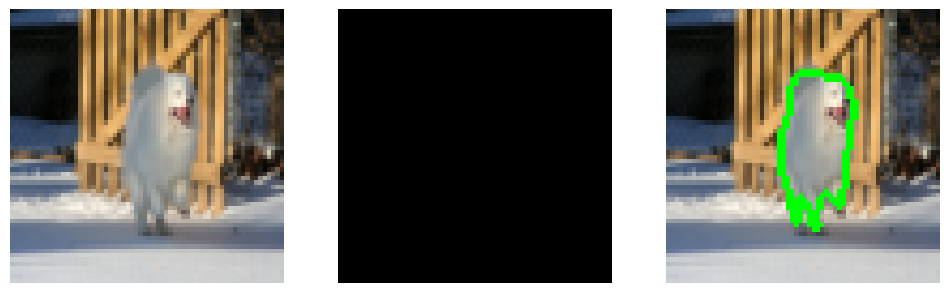

dice for samoyed-170 : 0.000


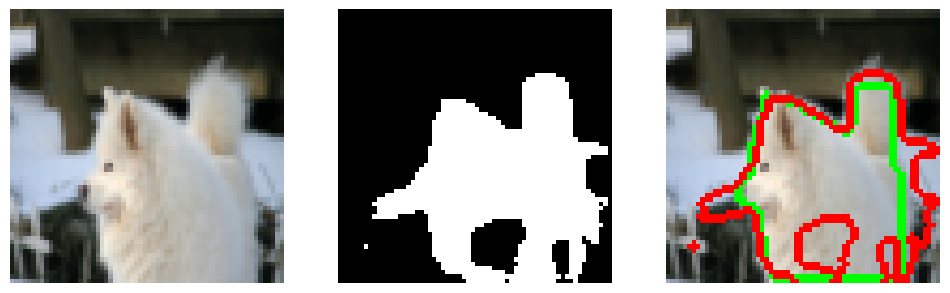

dice for samoyed-171 : 0.826


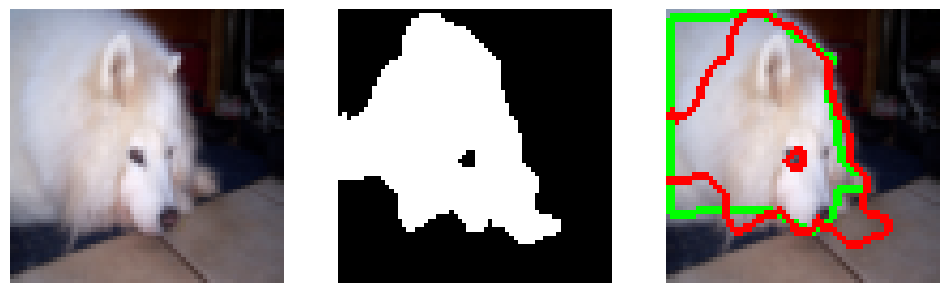

dice for samoyed-172 : 0.828


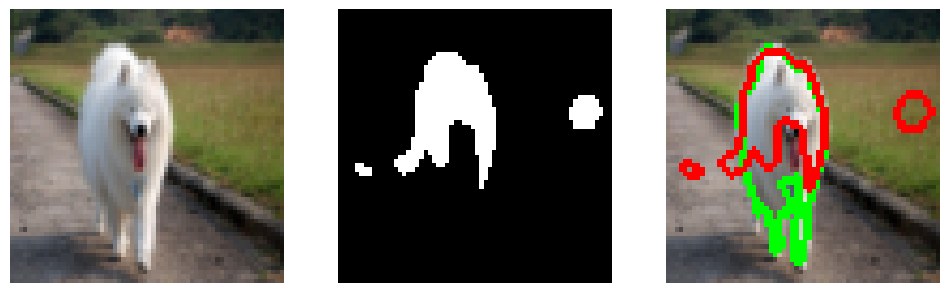

dice for samoyed-173 : 0.667


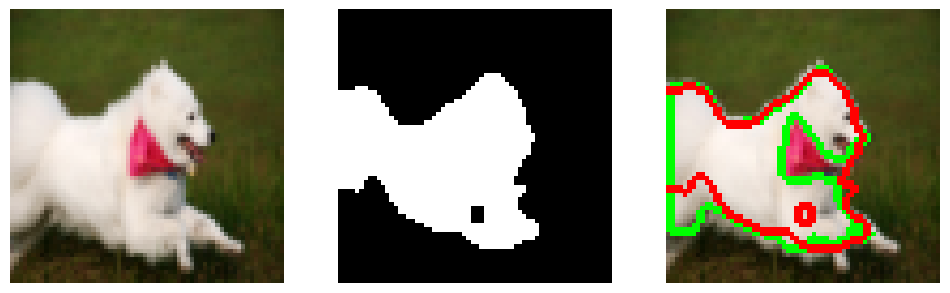

dice for samoyed-174 : 0.846


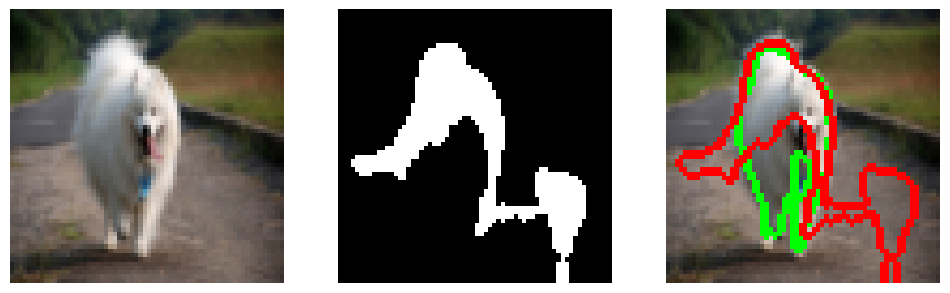

dice for samoyed-175 : 0.537


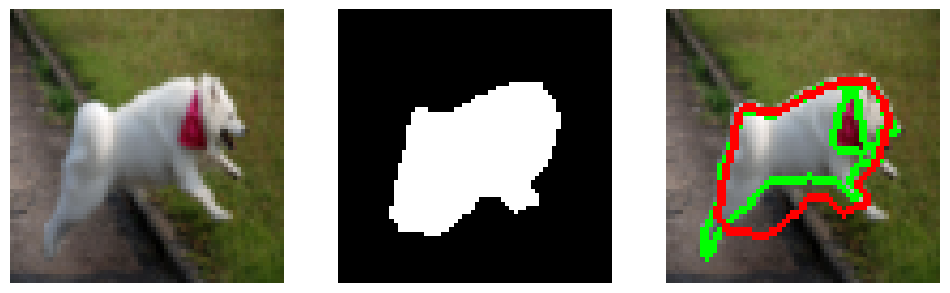

dice for samoyed-176 : 0.776


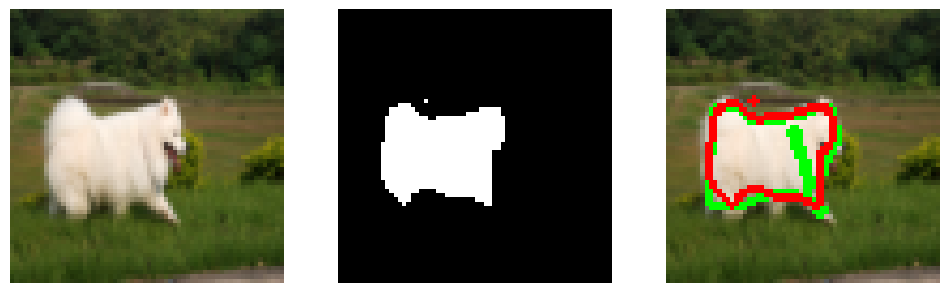

dice for samoyed-177 : 0.892


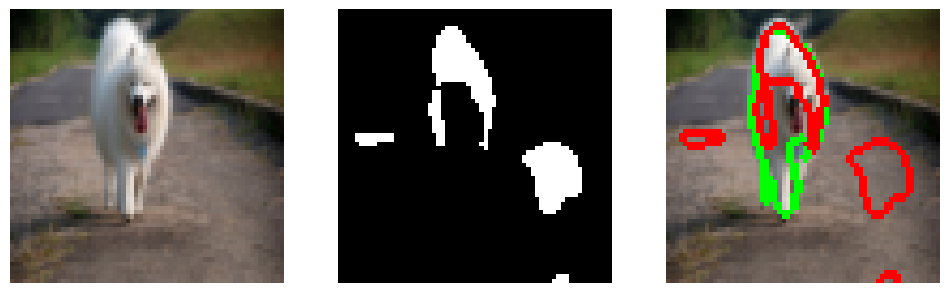

dice for samoyed-178 : 0.467


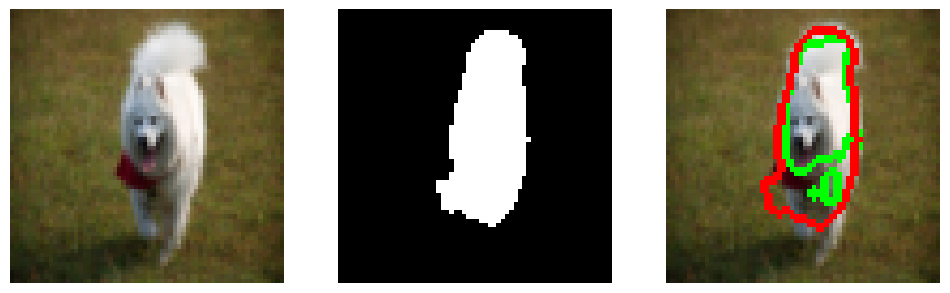

dice for samoyed-179 : 0.740


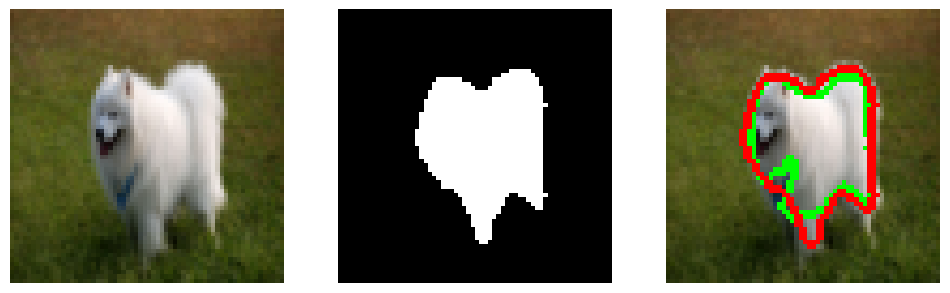

dice for samoyed-180 : 0.894


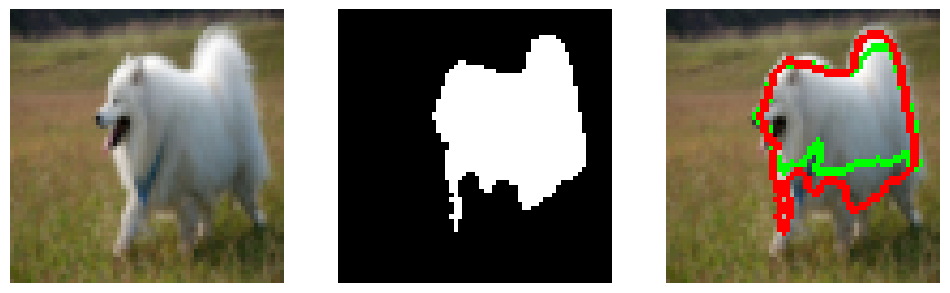

dice for samoyed-181 : 0.853


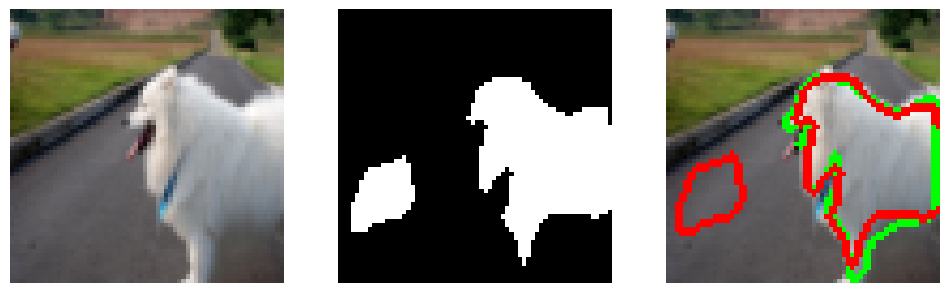

dice for samoyed-182 : 0.831


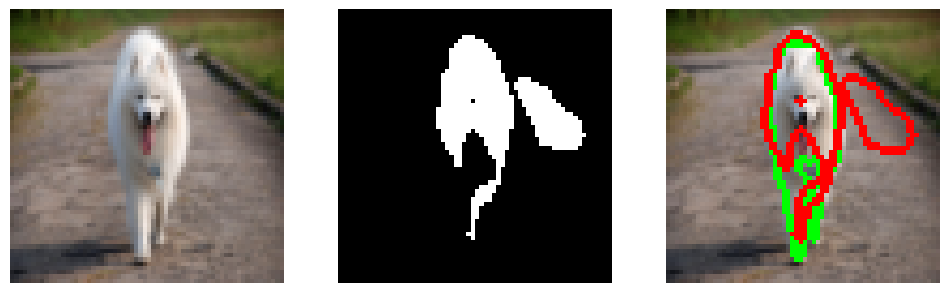

dice for samoyed-183 : 0.678


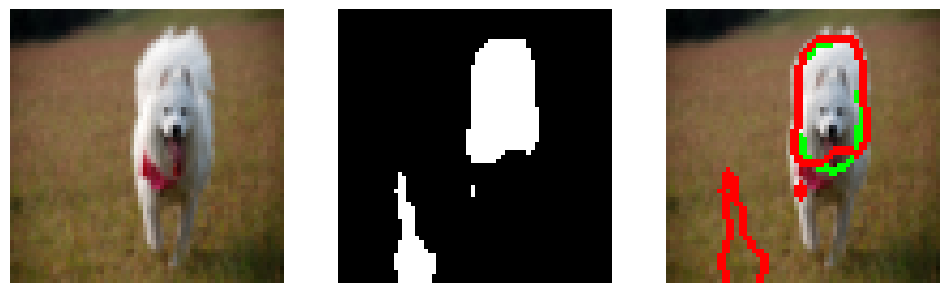

dice for samoyed-184 : 0.788


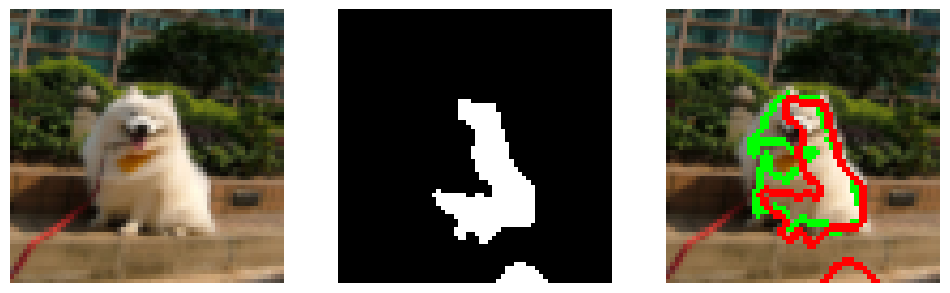

dice for samoyed-185 : 0.700


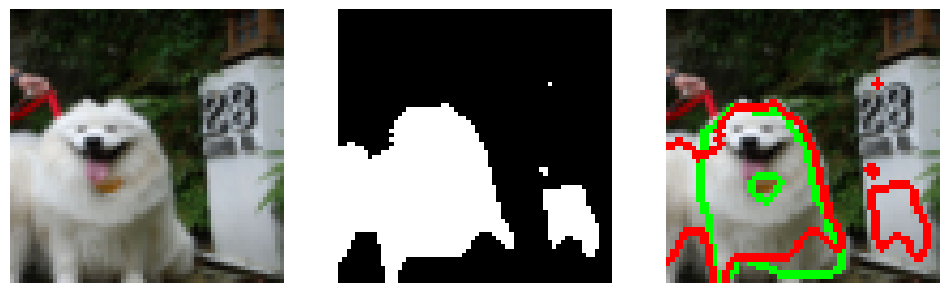

dice for samoyed-186 : 0.724


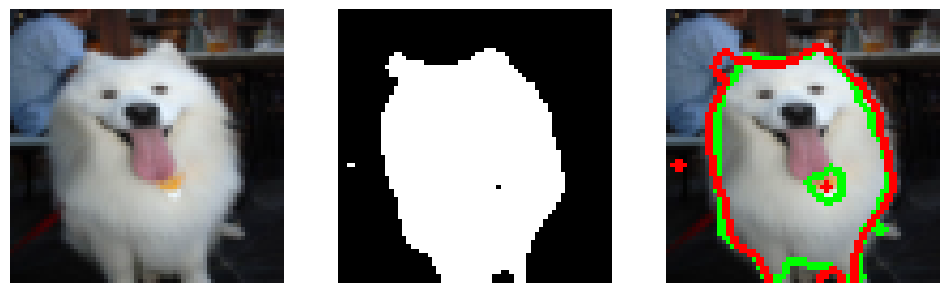

dice for samoyed-187 : 0.926


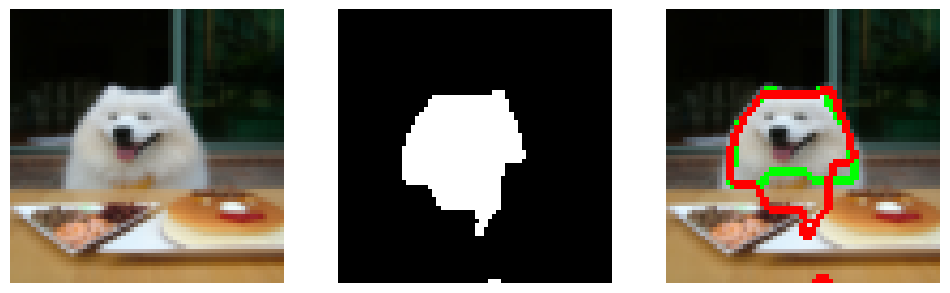

dice for samoyed-188 : 0.823


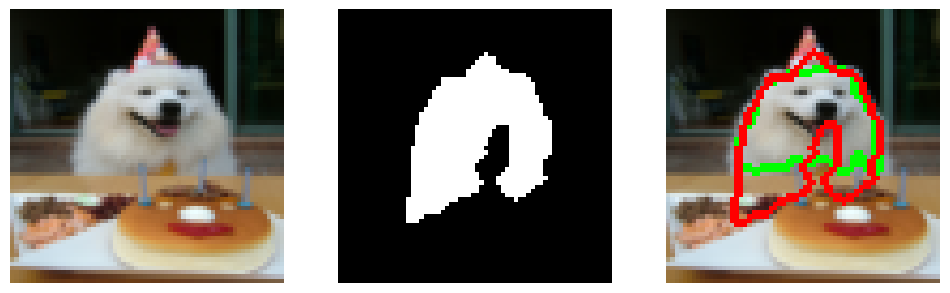

dice for samoyed-189 : 0.766


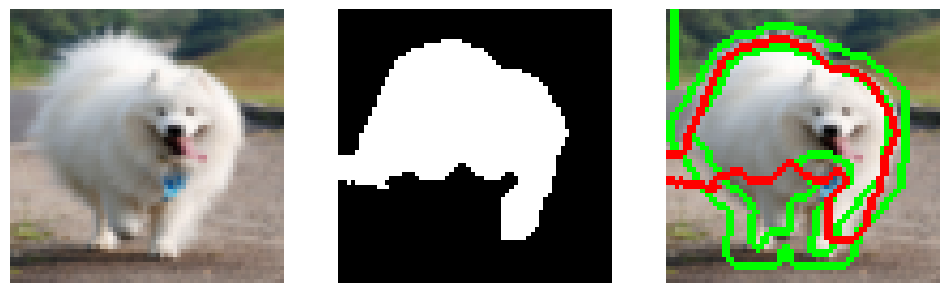

dice for samoyed-190 : 0.508


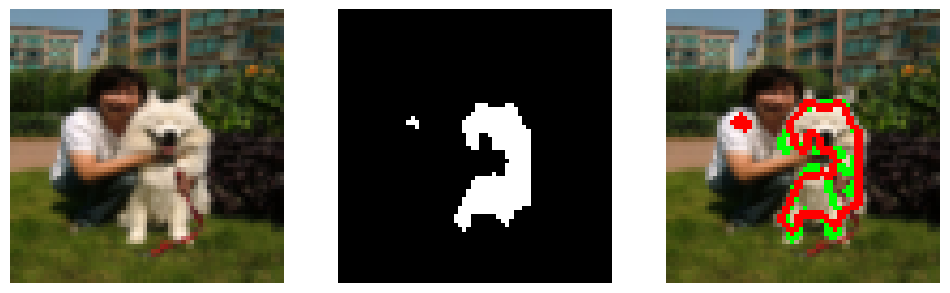

dice for samoyed-191 : 0.800


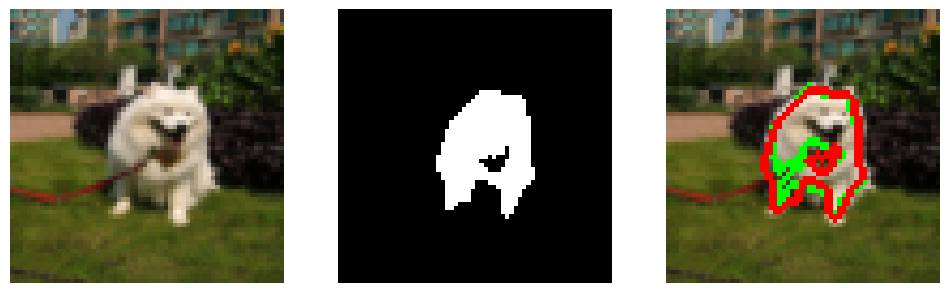

dice for samoyed-192 : 0.869


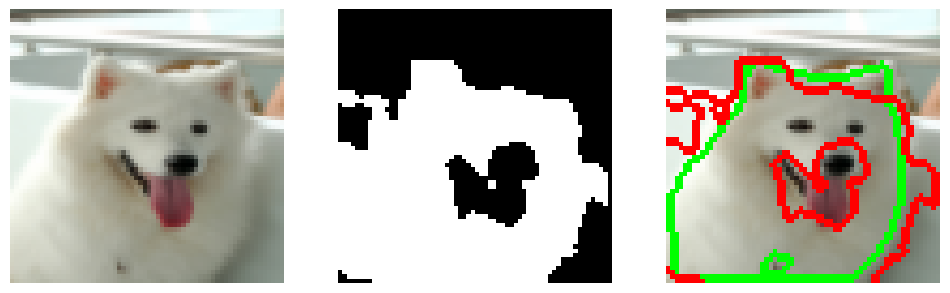

dice for samoyed-193 : 0.818


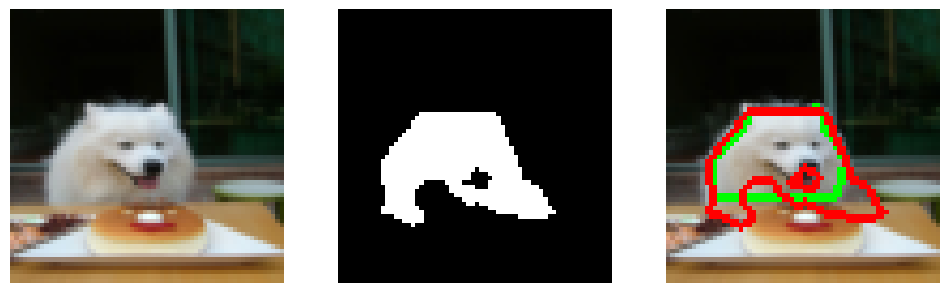

dice for samoyed-194 : 0.799


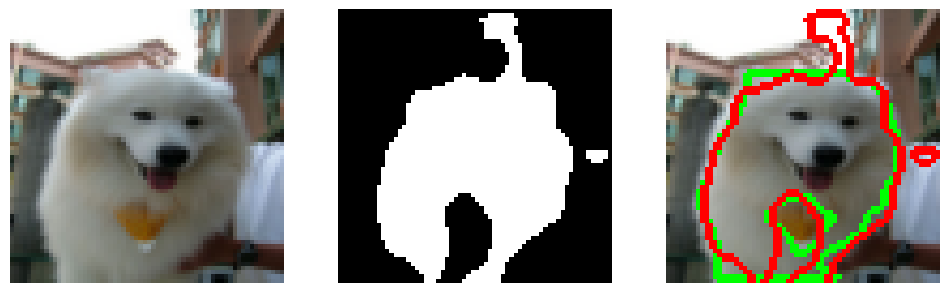

dice for samoyed-195 : 0.885


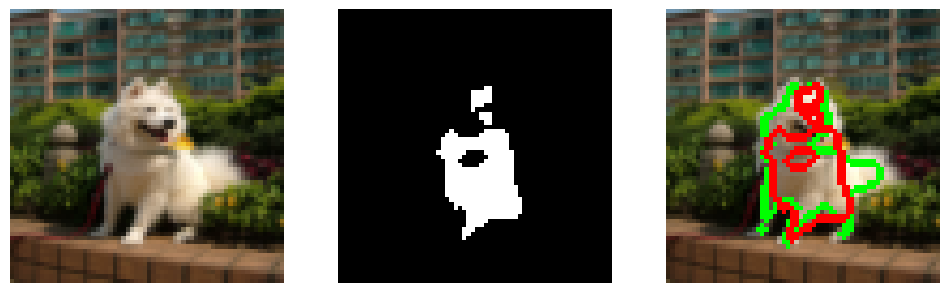

dice for samoyed-196 : 0.694


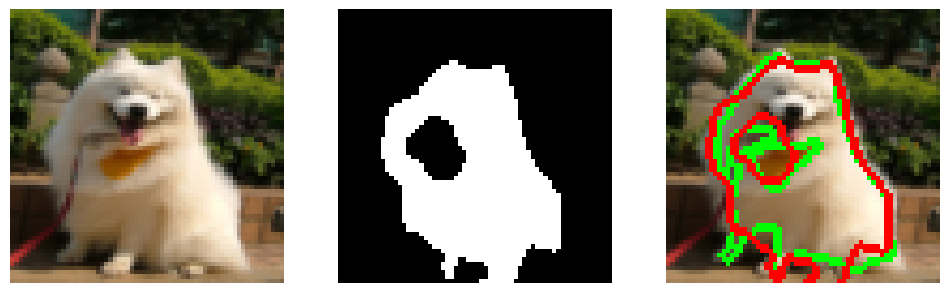

dice for samoyed-197 : 0.878


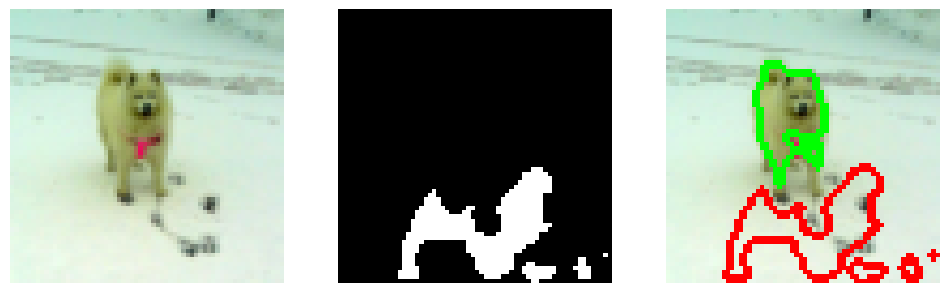

dice for samoyed-198 : 0.000


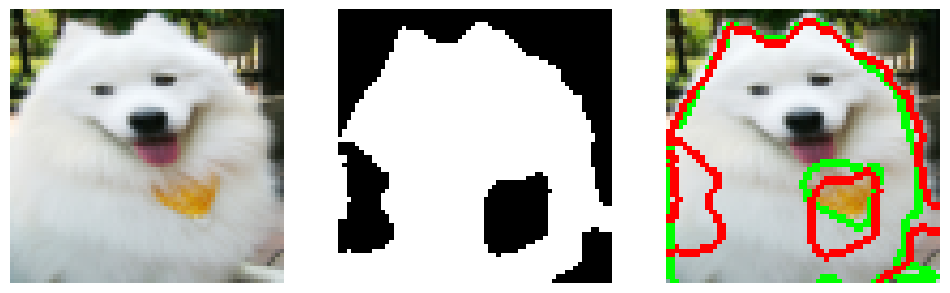

dice for samoyed-199 : 0.889


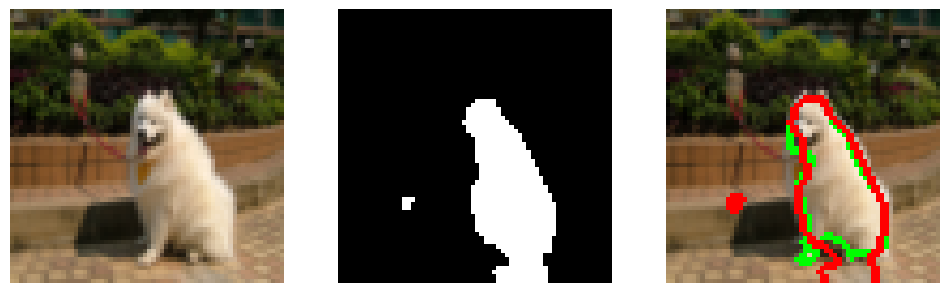

dice for samoyed-200 : 0.858
average dice: 0.719


In [77]:
model_3 = get_model_3(size_, size_)
model_3.summary()
hist_3 = model_3.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])
display_history(hist_3)
dices_3 = make_prediction(model_3, test_idxs, test_imgs, test_segs)
print('average dice: %02.3f'%(np.mean(dices_3)) )

**Question 10 -** The two following deep models (`model_4` and `model_5`) use the `VGG16` classification network without (`model_4`) and with (`model_5`) **pre-training** on the `ImageNet` dataset. Run the training for both networks (100 epochs for `model_4`, 50 for `model_5`) and (as previously) evaluate them.

In [78]:
def get_model_4(img_rows, img_cols):

    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 64, 64, 64)           1792      ['input_8[0][0]']             
                                                                                                  
 conv2d_58 (Conv2D)          (None, 64, 64, 64)           36928     ['conv2d_57[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 64)           0         ['conv2d_58[0][0]']           
 g2D)                                                                                       

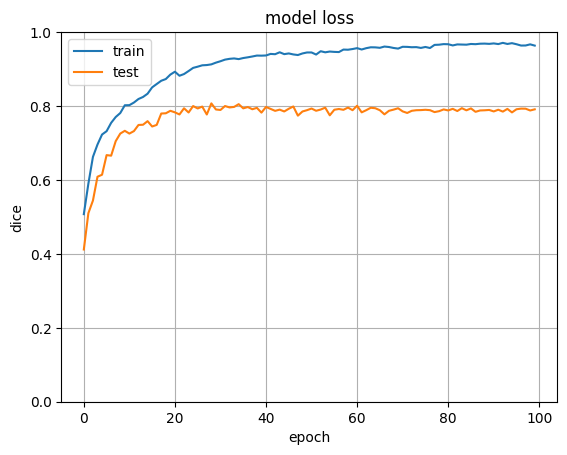

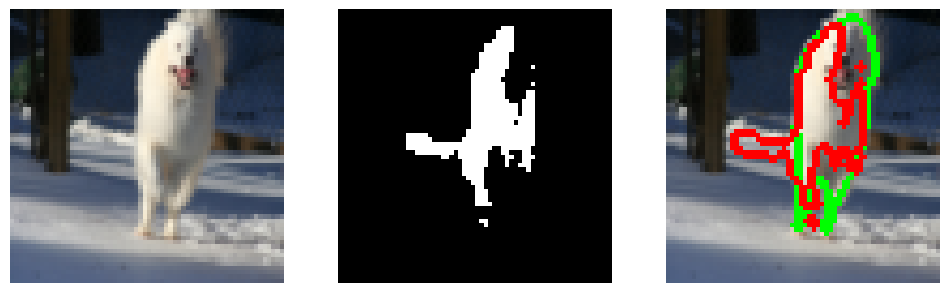

dice for samoyed-161 : 0.659


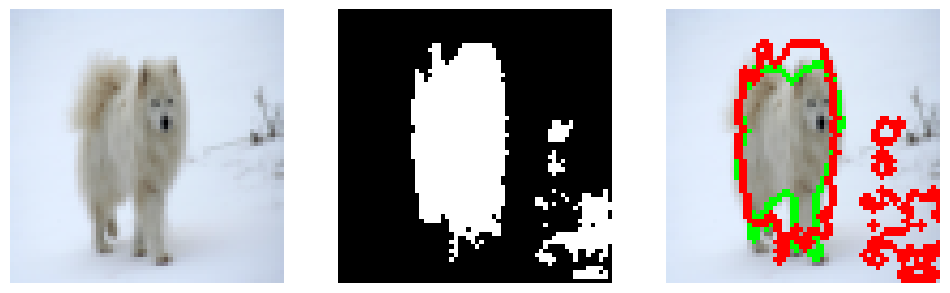

dice for samoyed-162 : 0.755


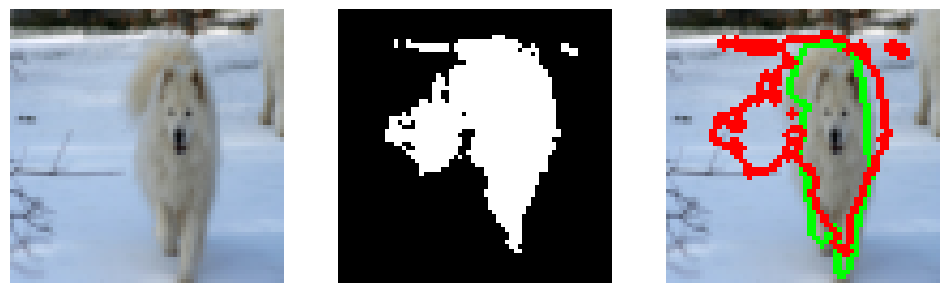

dice for samoyed-163 : 0.691


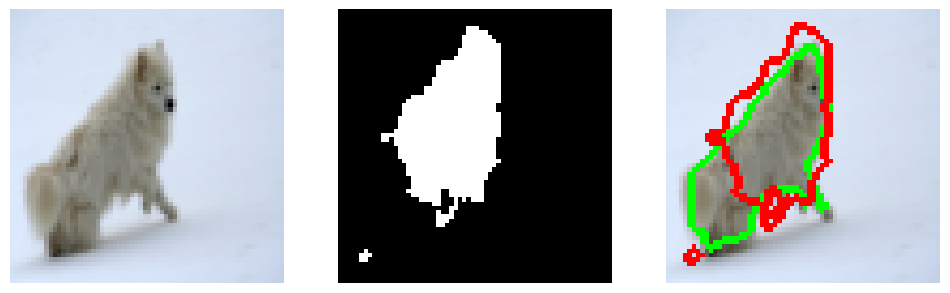

dice for samoyed-164 : 0.707


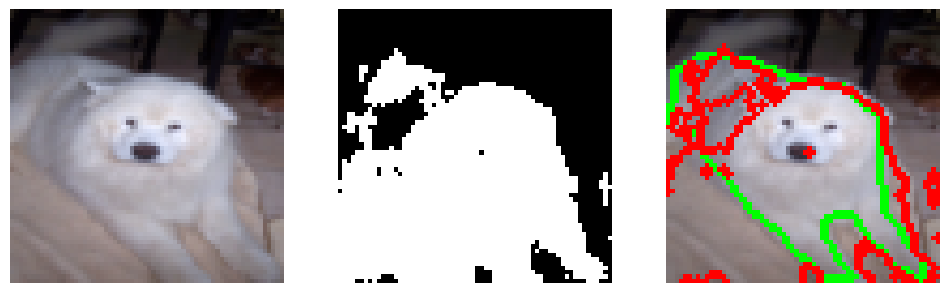

dice for samoyed-165 : 0.706


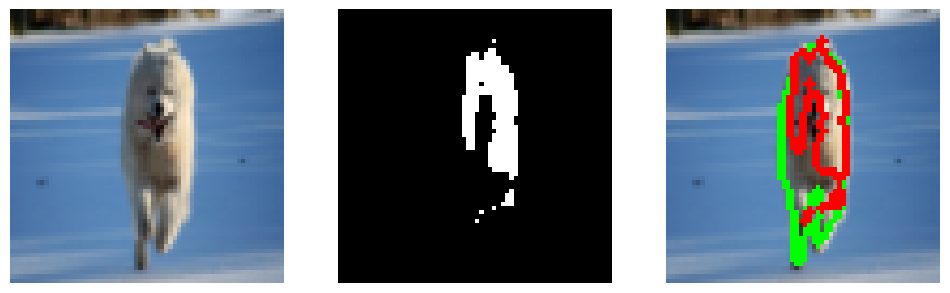

dice for samoyed-166 : 0.643


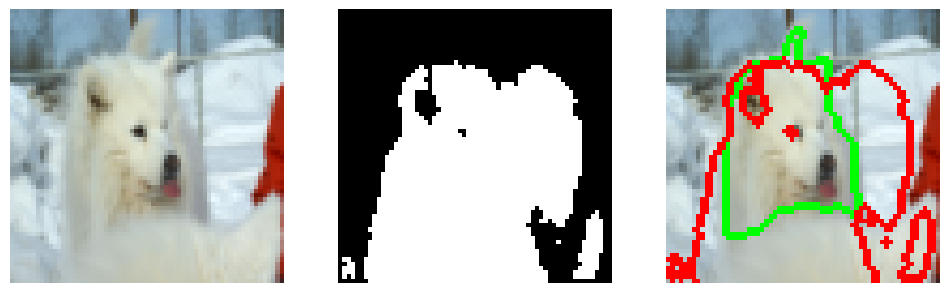

dice for samoyed-167 : 0.573


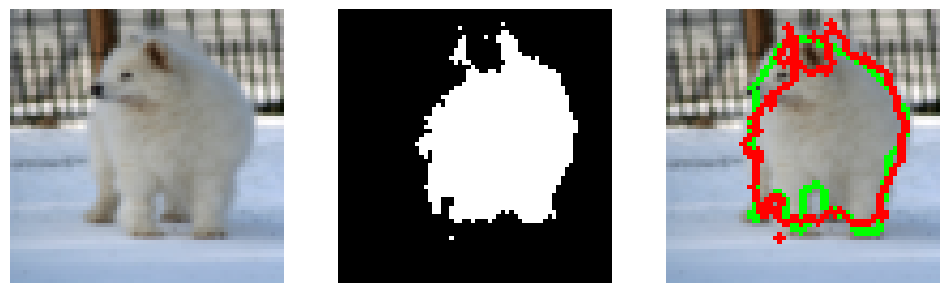

dice for samoyed-168 : 0.877


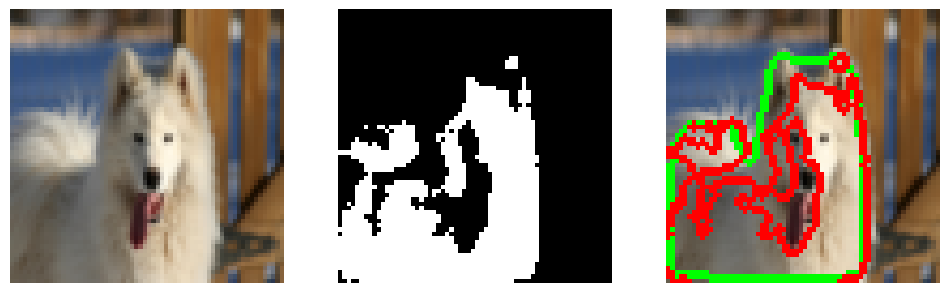

dice for samoyed-169 : 0.778


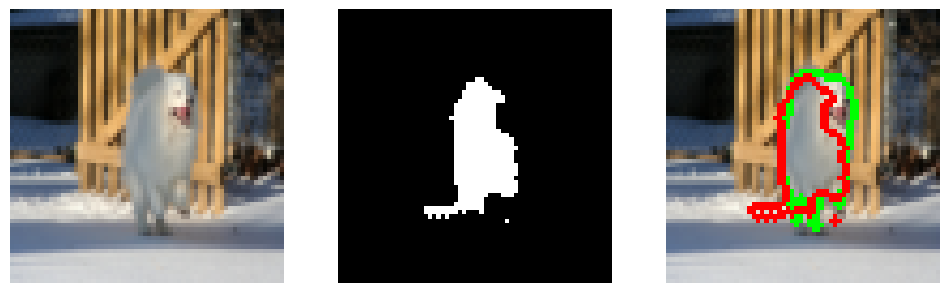

dice for samoyed-170 : 0.793


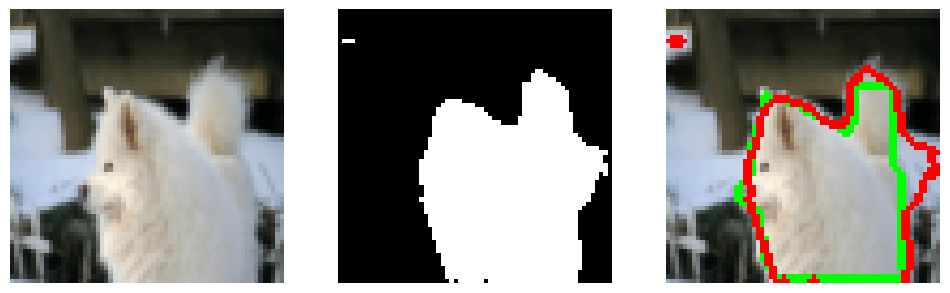

dice for samoyed-171 : 0.912


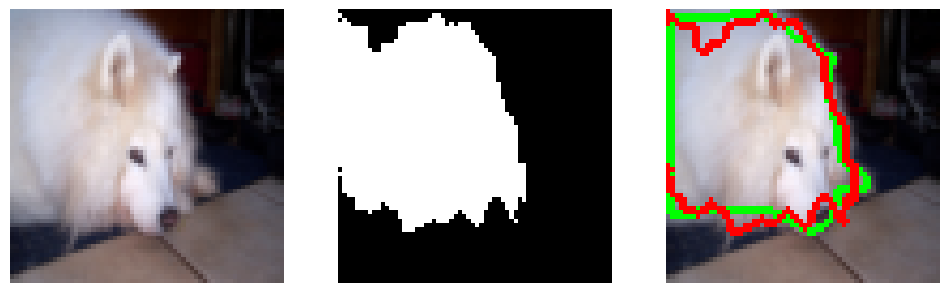

dice for samoyed-172 : 0.918


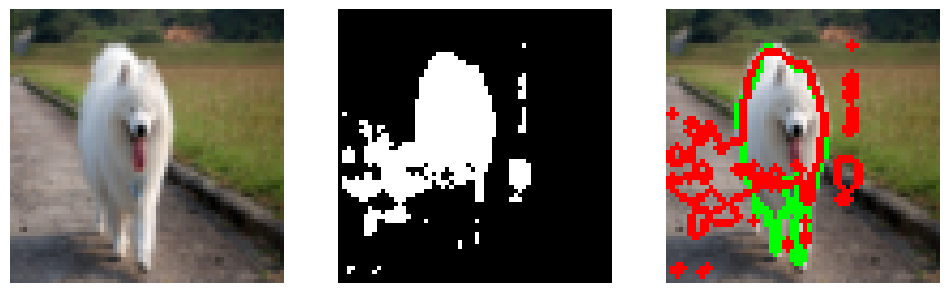

dice for samoyed-173 : 0.675


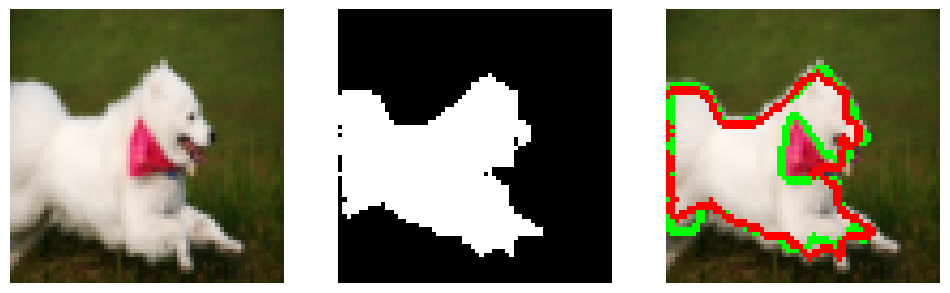

dice for samoyed-174 : 0.893


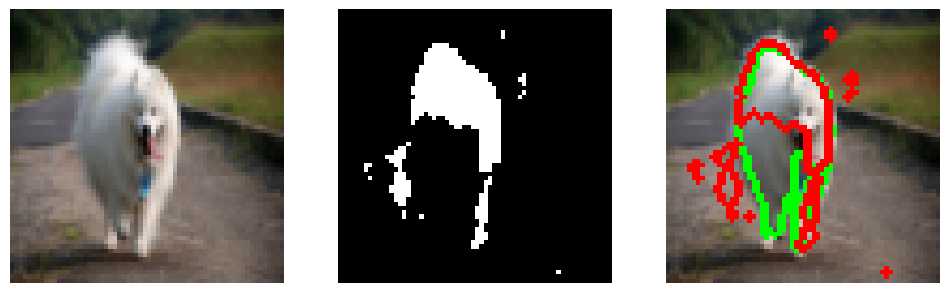

dice for samoyed-175 : 0.612


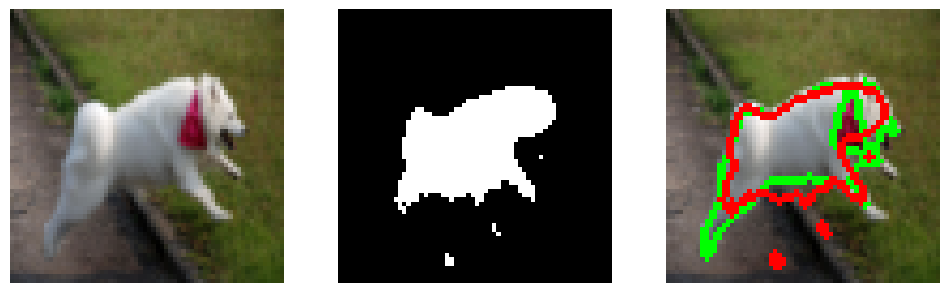

dice for samoyed-176 : 0.809


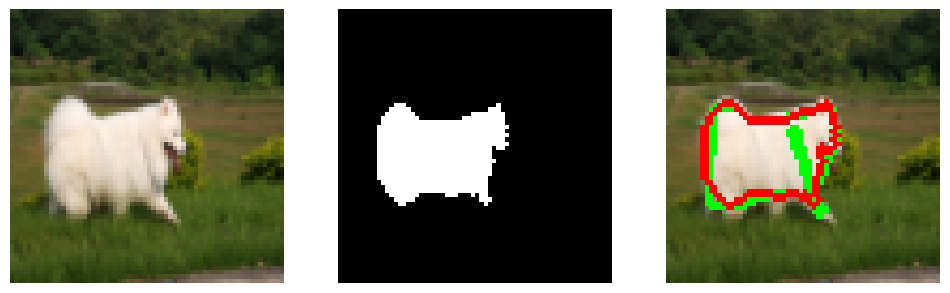

dice for samoyed-177 : 0.906


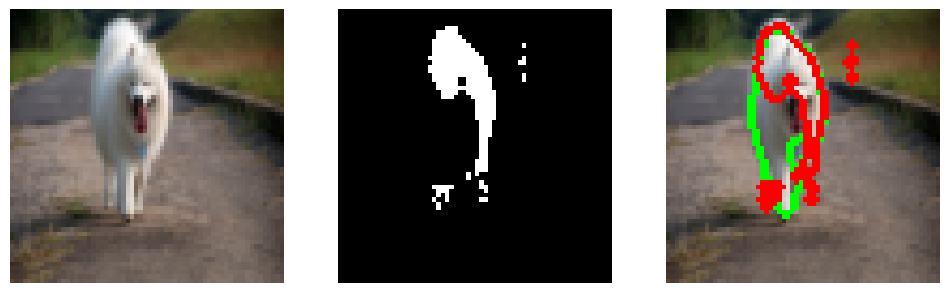

dice for samoyed-178 : 0.599


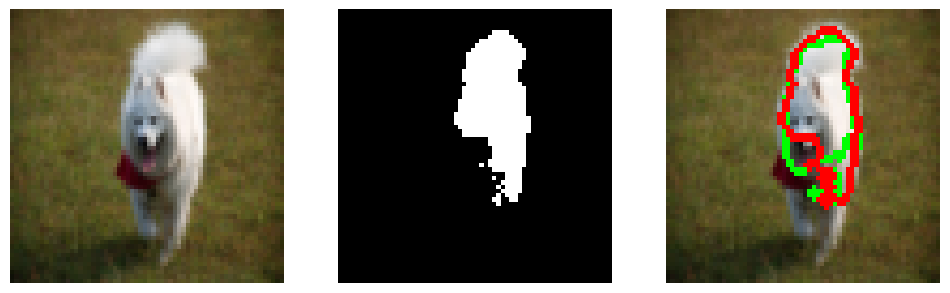

dice for samoyed-179 : 0.805


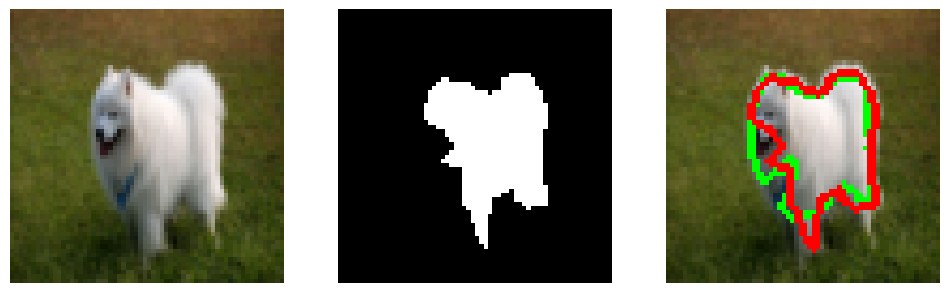

dice for samoyed-180 : 0.874


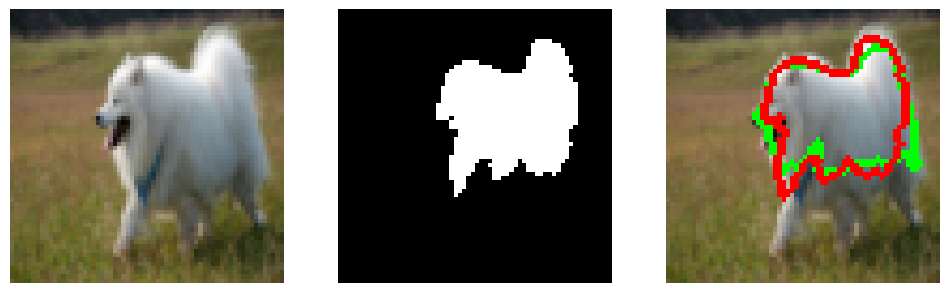

dice for samoyed-181 : 0.893


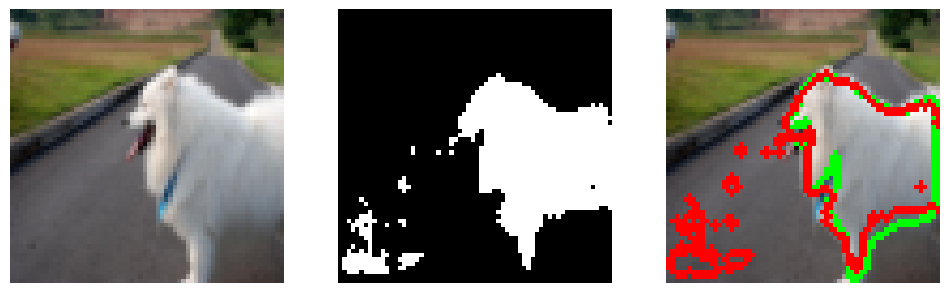

dice for samoyed-182 : 0.858


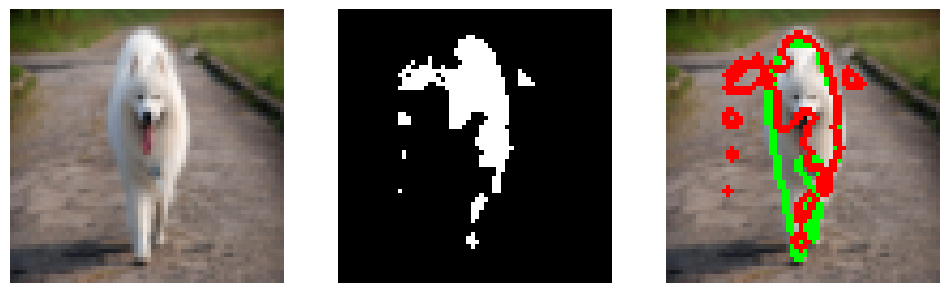

dice for samoyed-183 : 0.670


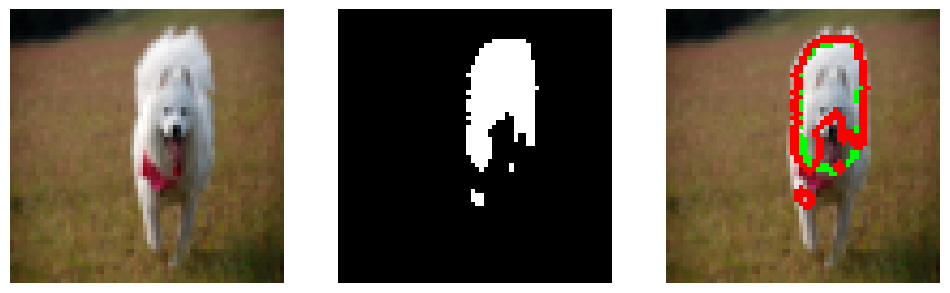

dice for samoyed-184 : 0.824


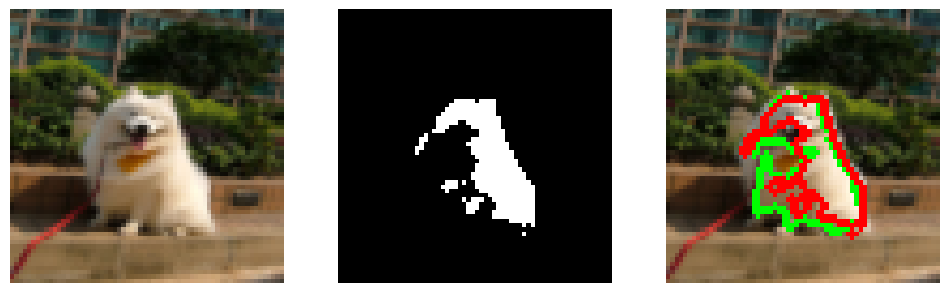

dice for samoyed-185 : 0.734


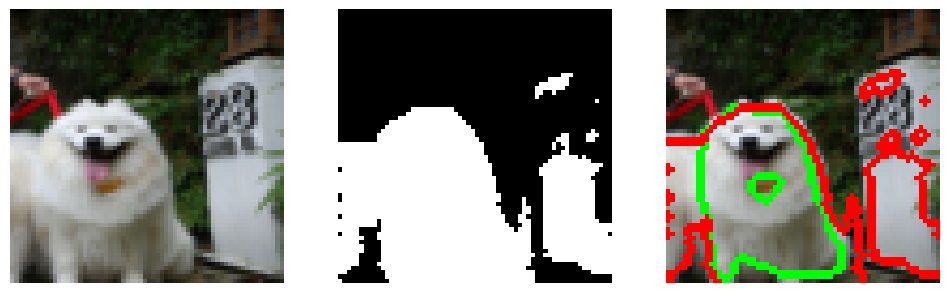

dice for samoyed-186 : 0.680


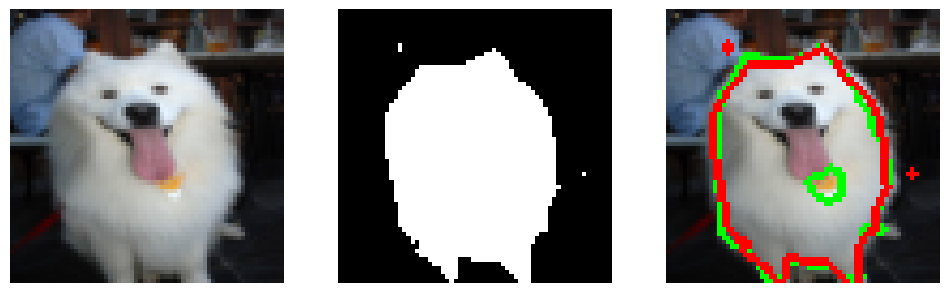

dice for samoyed-187 : 0.949


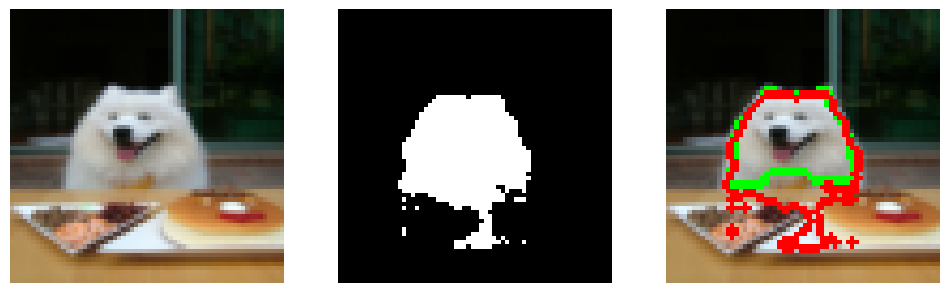

dice for samoyed-188 : 0.802


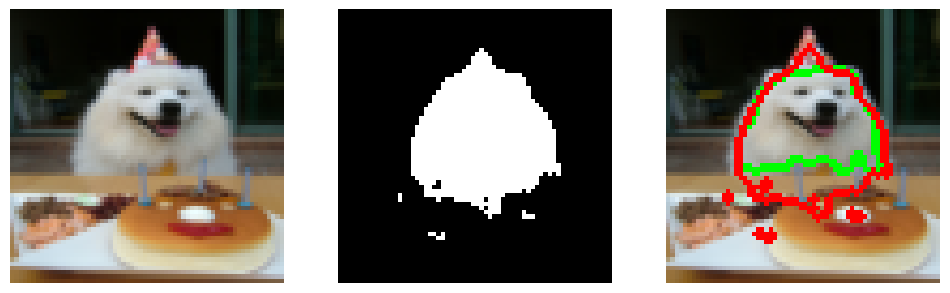

dice for samoyed-189 : 0.793


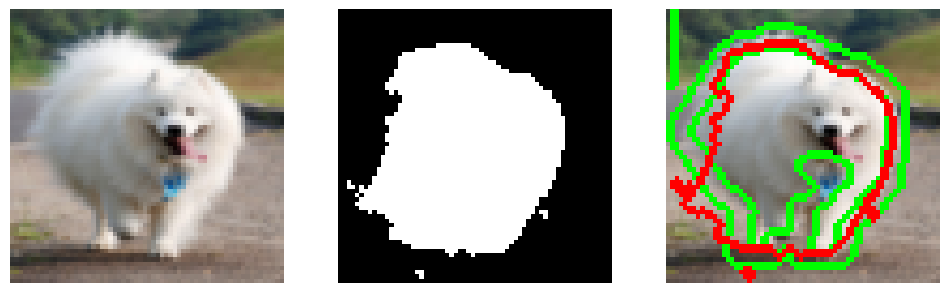

dice for samoyed-190 : 0.550


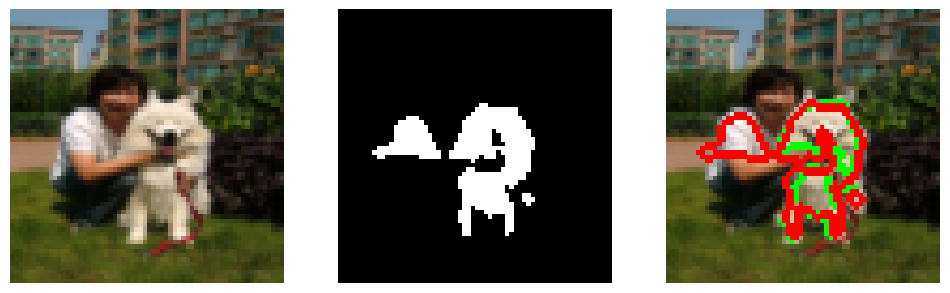

dice for samoyed-191 : 0.692


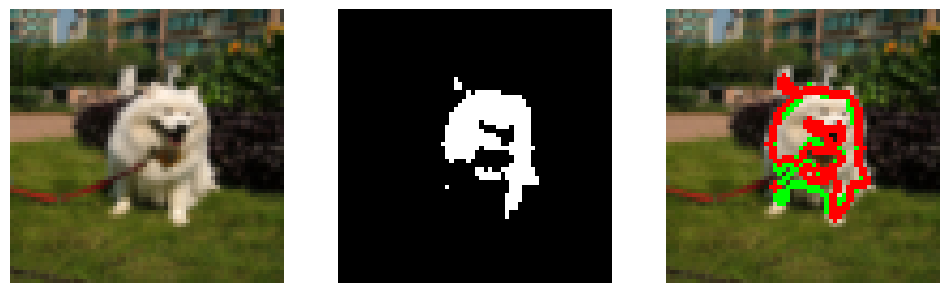

dice for samoyed-192 : 0.809


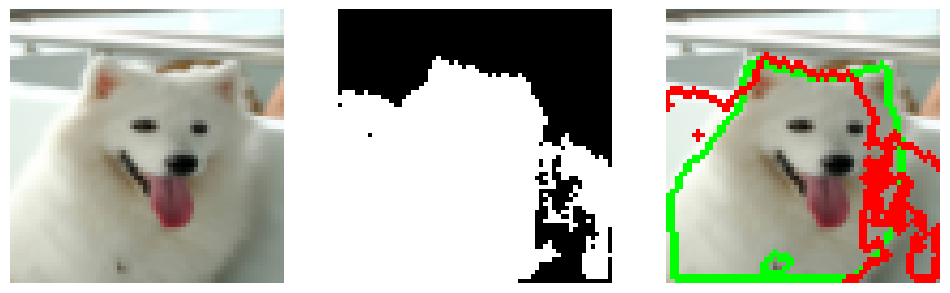

dice for samoyed-193 : 0.835


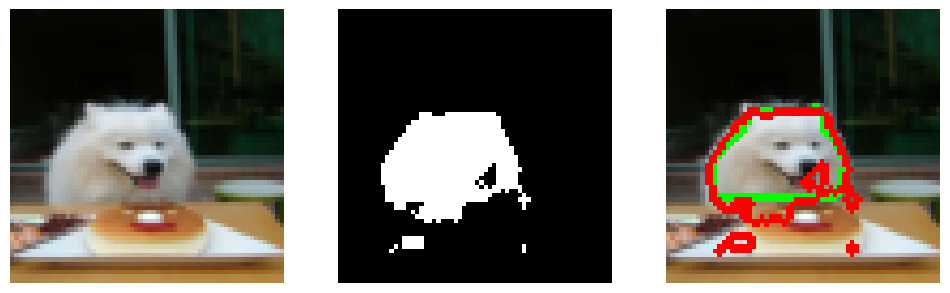

dice for samoyed-194 : 0.857


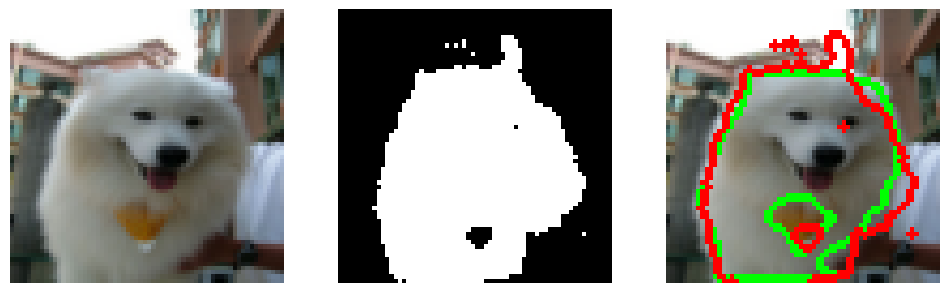

dice for samoyed-195 : 0.888


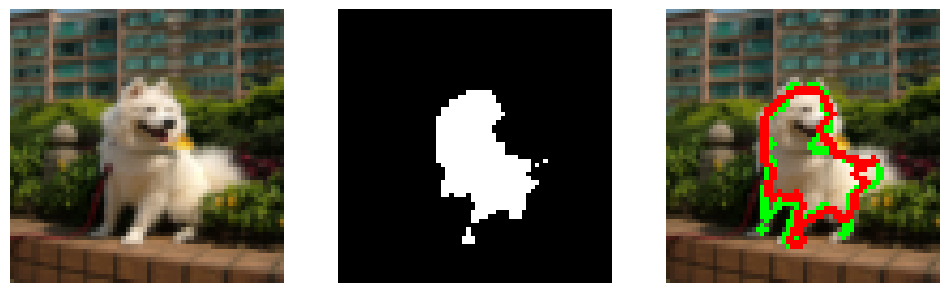

dice for samoyed-196 : 0.863


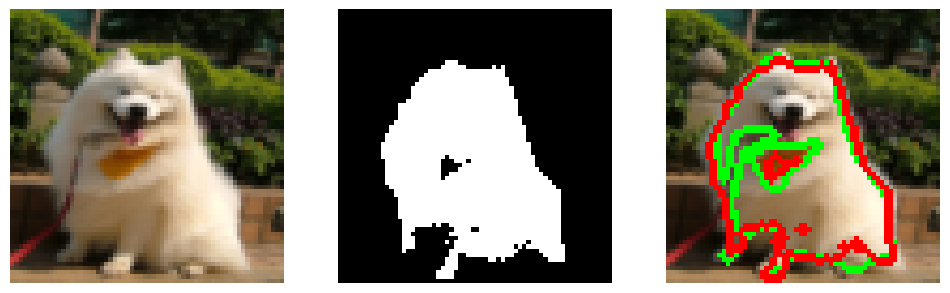

dice for samoyed-197 : 0.883


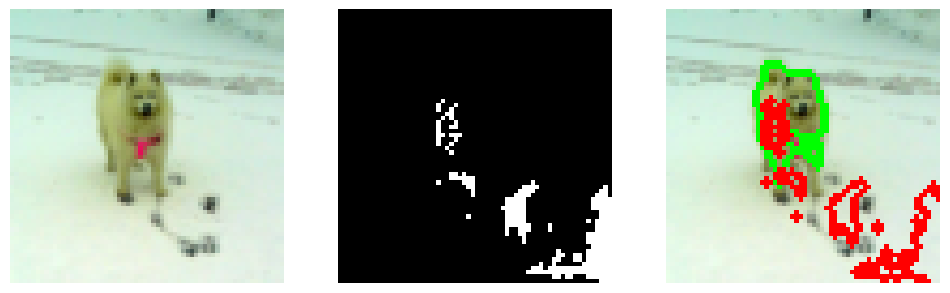

dice for samoyed-198 : 0.102


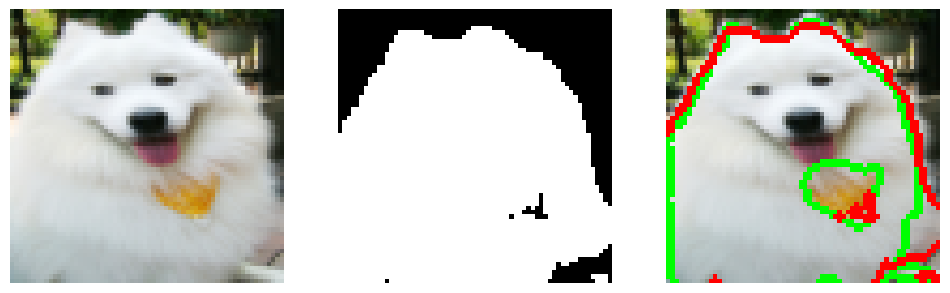

dice for samoyed-199 : 0.926


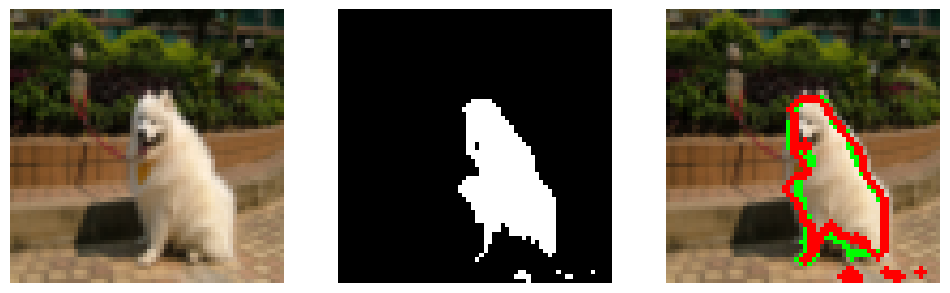

dice for samoyed-200 : 0.892
average dice: 0.767


In [79]:
epochs = 100
model_4 = get_model_4(size_, size_)
model_4.summary()
hist_4 = model_4.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])
display_history(hist_4)
dices_4 = make_prediction(model_4, test_idxs, test_imgs, test_segs)
print('average dice: %02.3f'%(np.mean(dices_4)) )

In [80]:
from tensorflow.keras.applications import vgg16

def get_model_5(img_rows, img_cols):

    vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_rows,img_cols,3), pooling=None, classes=1000)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(vgg16_model.get_layer('block5_conv3').output), vgg16_model.get_layer('block4_conv3').output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv6), vgg16_model.get_layer('block3_conv3').output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv7), vgg16_model.get_layer('block2_conv2').output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv8), vgg16_model.get_layer('block1_conv2').output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs=[vgg16_model.layers[0].output], outputs=[conv10])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

58889256/58889256 [==============================] - 2s 0us/step
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 64, 64, 64)           1792      ['input_9[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 64, 64, 64)           36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)           0         ['block1_conv2[0][0]']        
                           

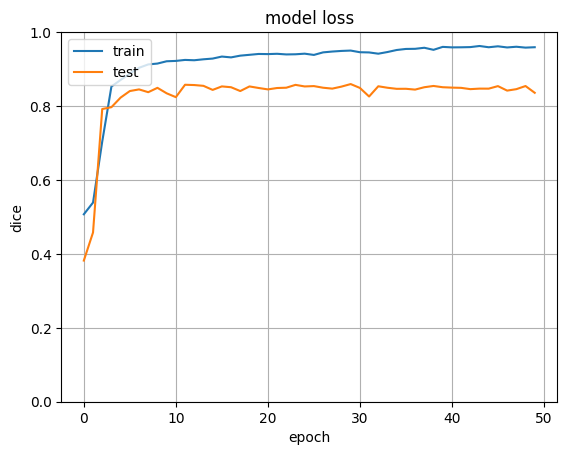

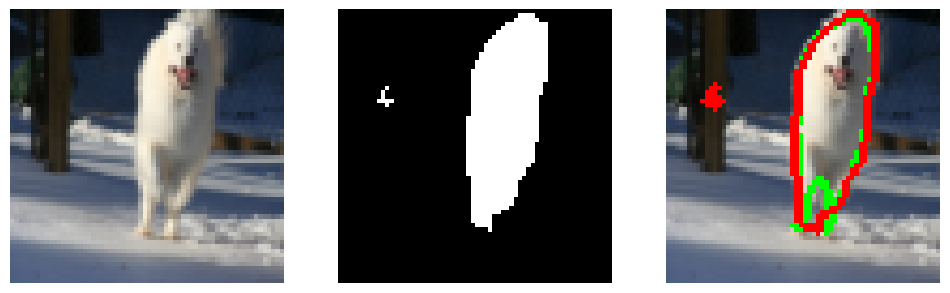

dice for samoyed-161 : 0.913


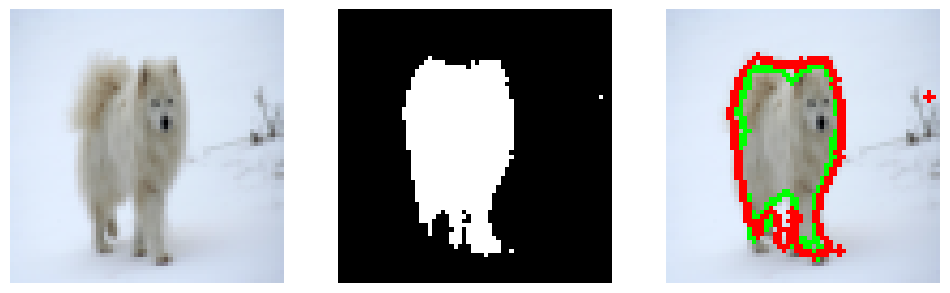

dice for samoyed-162 : 0.881


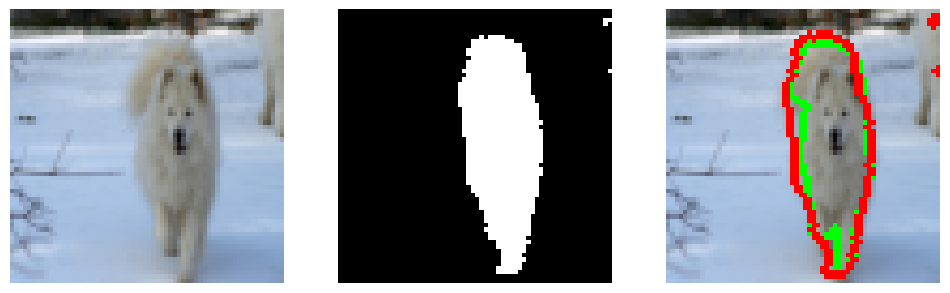

dice for samoyed-163 : 0.901


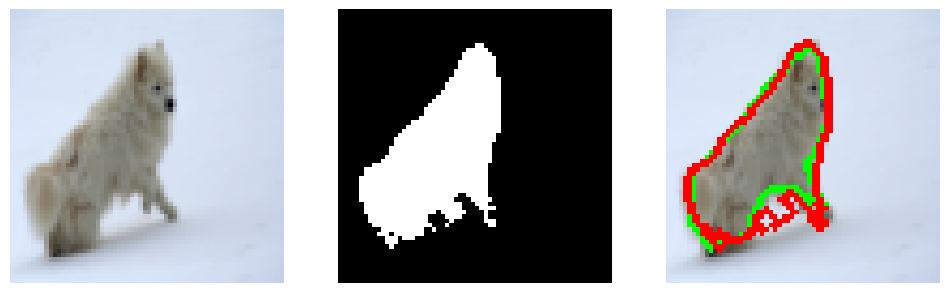

dice for samoyed-164 : 0.911


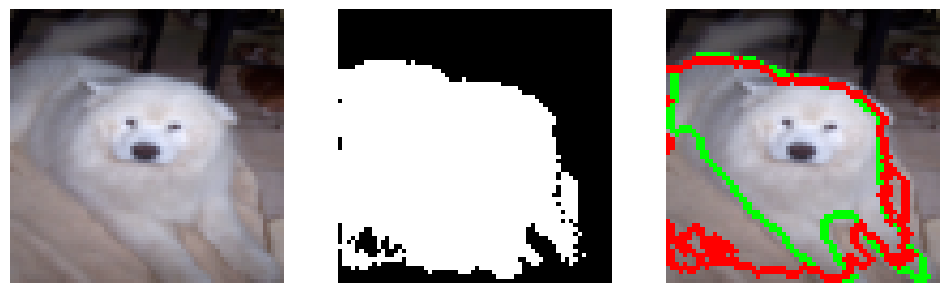

dice for samoyed-165 : 0.797


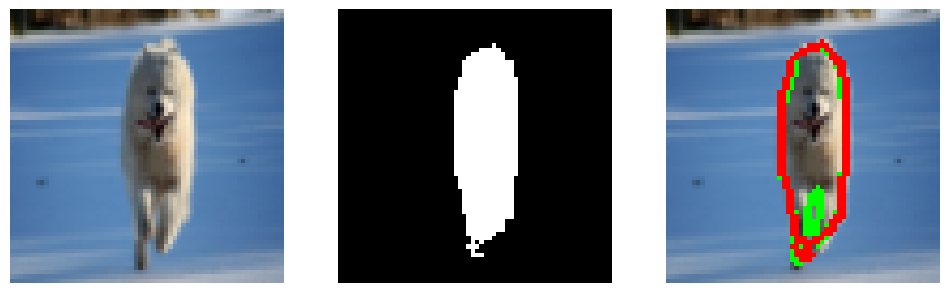

dice for samoyed-166 : 0.941


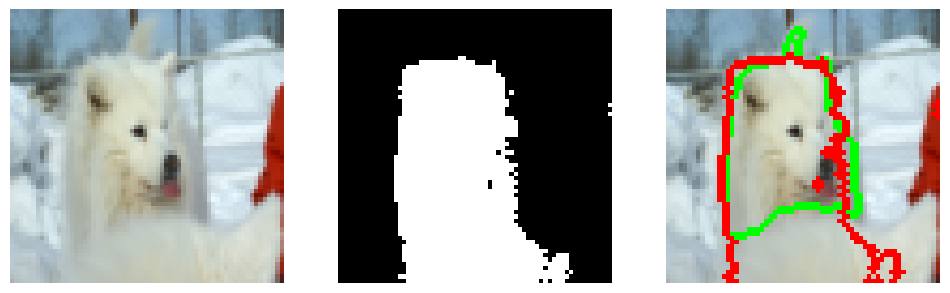

dice for samoyed-167 : 0.733


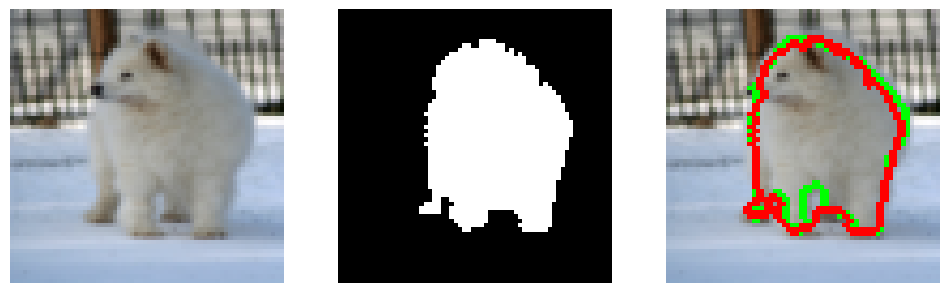

dice for samoyed-168 : 0.939


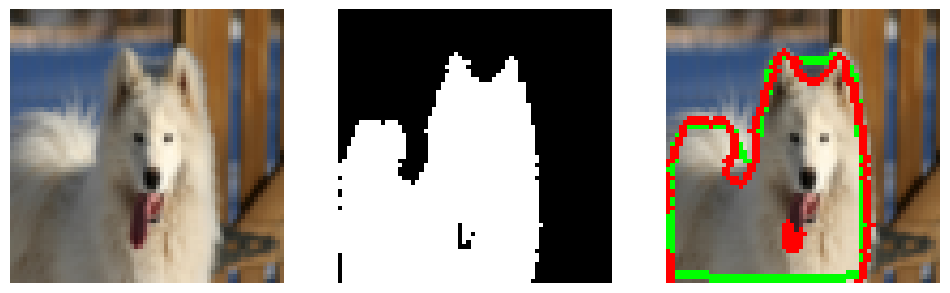

dice for samoyed-169 : 0.944


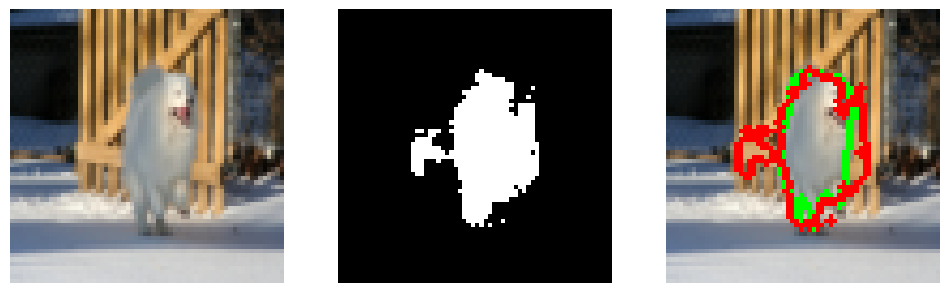

dice for samoyed-170 : 0.801


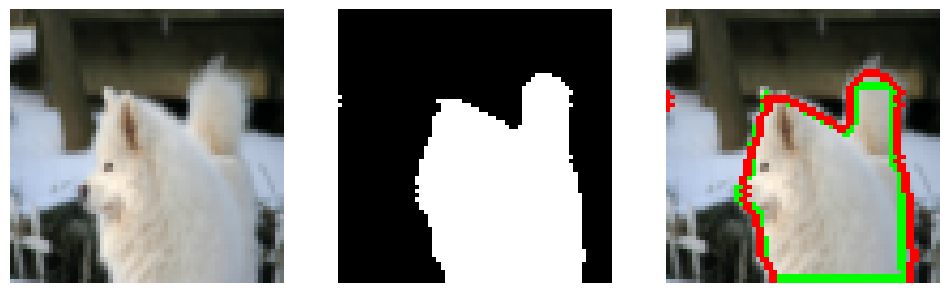

dice for samoyed-171 : 0.939


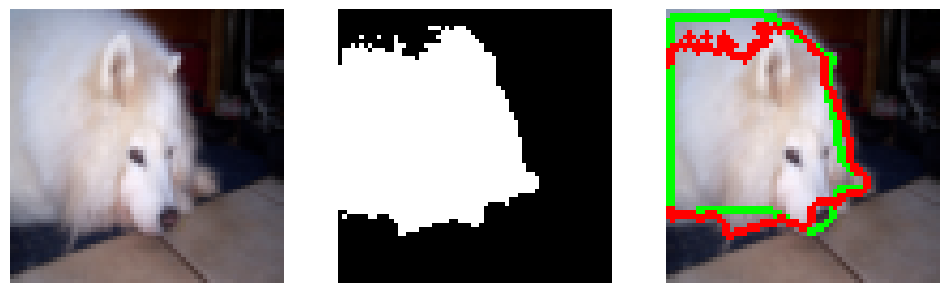

dice for samoyed-172 : 0.894


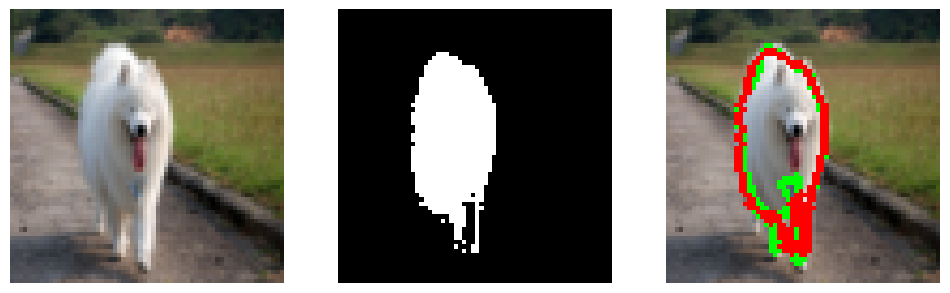

dice for samoyed-173 : 0.898


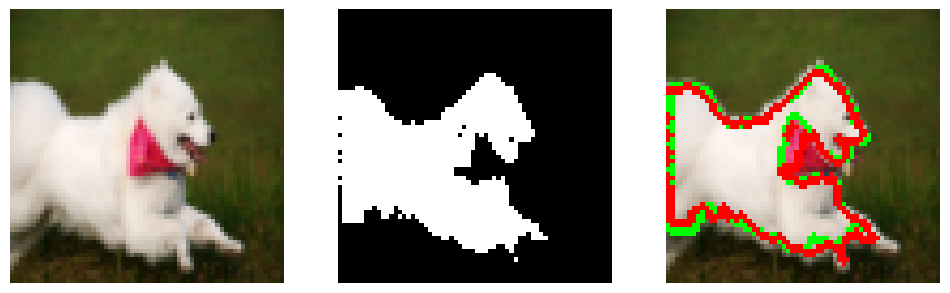

dice for samoyed-174 : 0.924


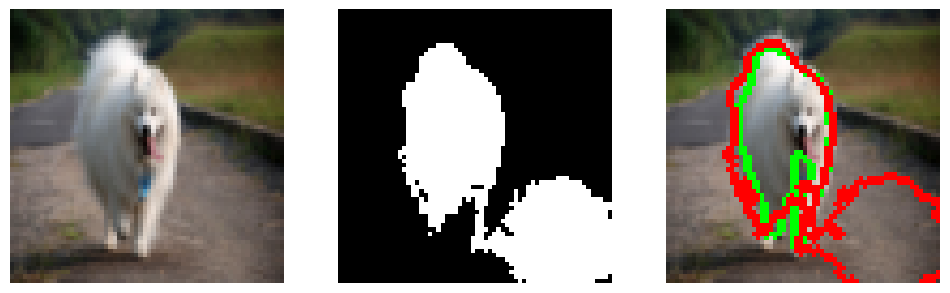

dice for samoyed-175 : 0.610


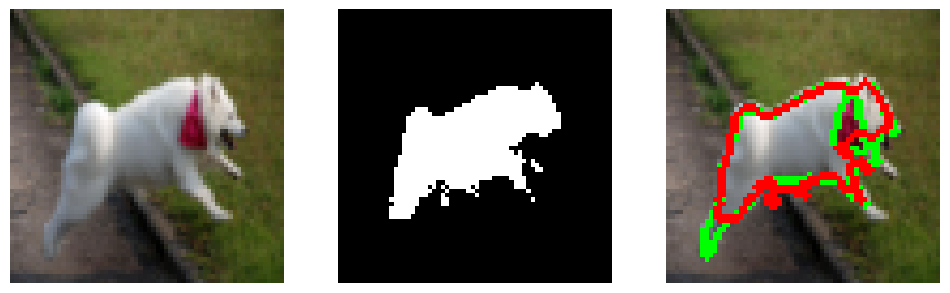

dice for samoyed-176 : 0.863


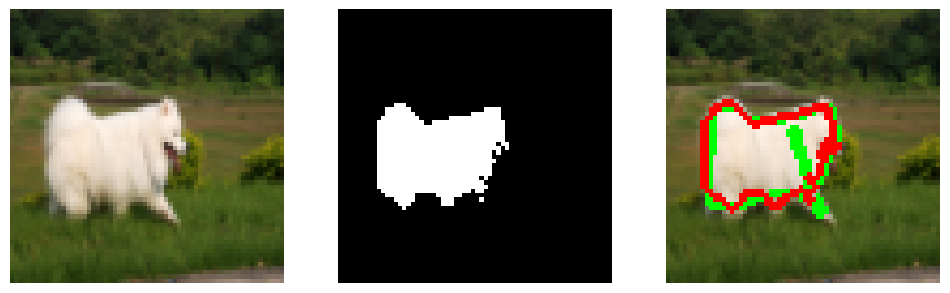

dice for samoyed-177 : 0.894


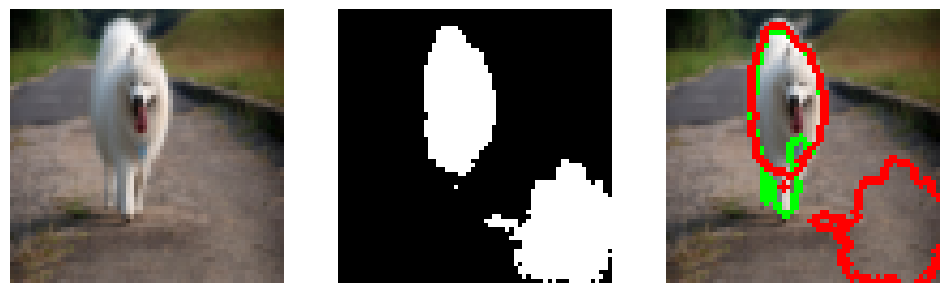

dice for samoyed-178 : 0.567


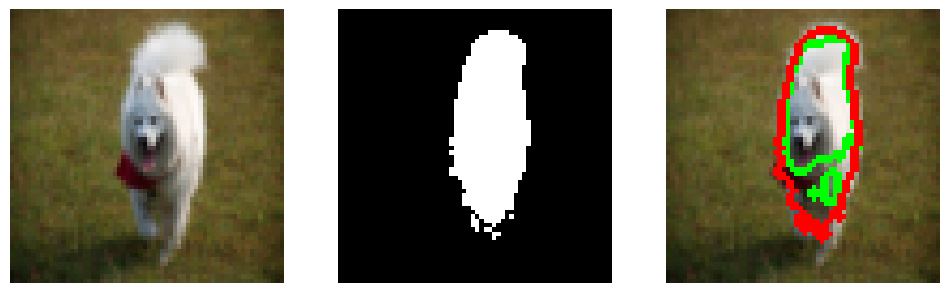

dice for samoyed-179 : 0.775


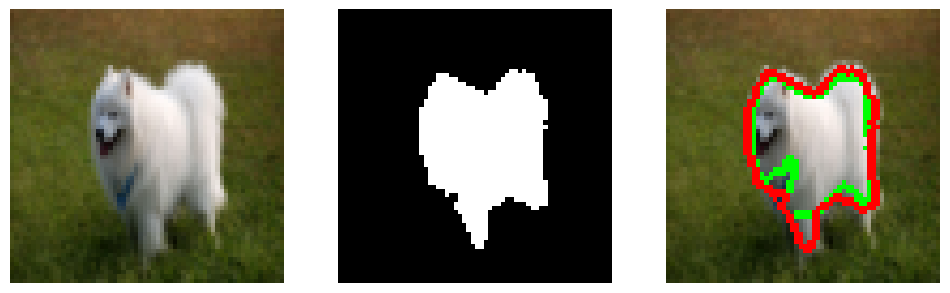

dice for samoyed-180 : 0.894


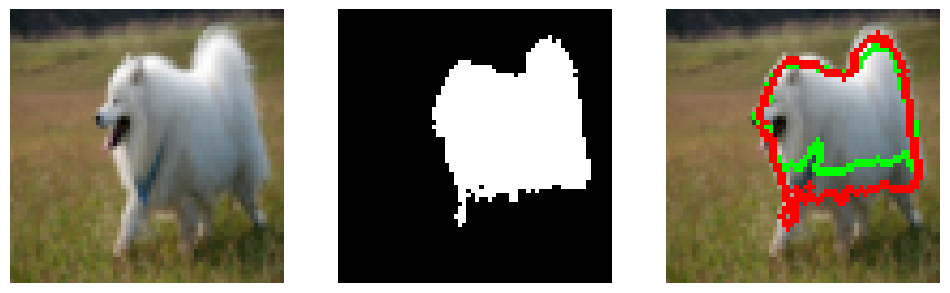

dice for samoyed-181 : 0.842


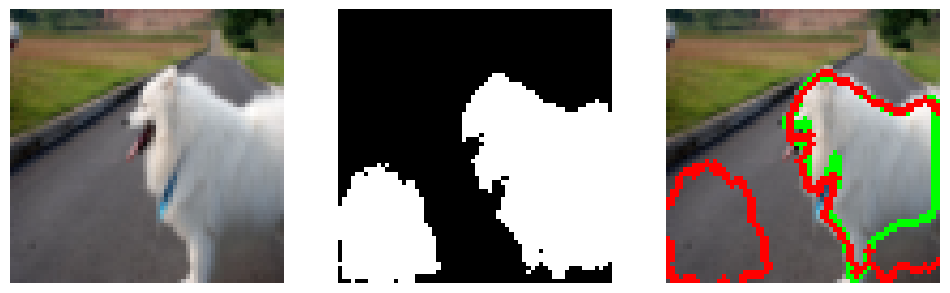

dice for samoyed-182 : 0.704


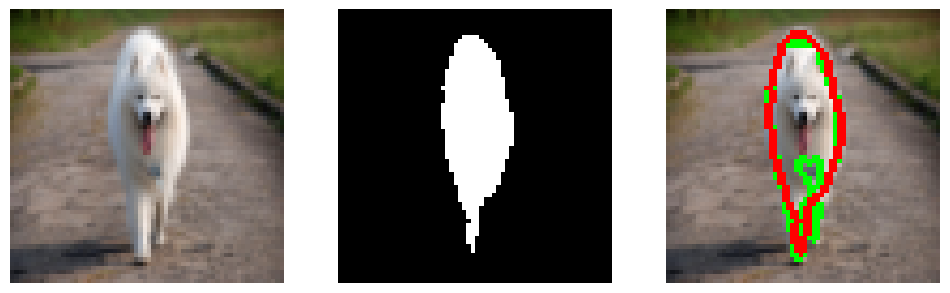

dice for samoyed-183 : 0.896


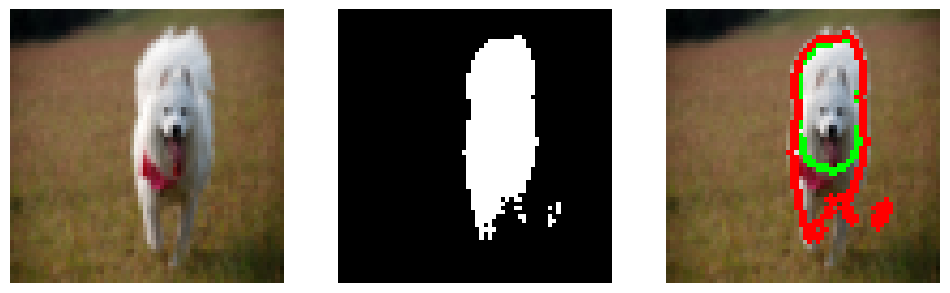

dice for samoyed-184 : 0.780


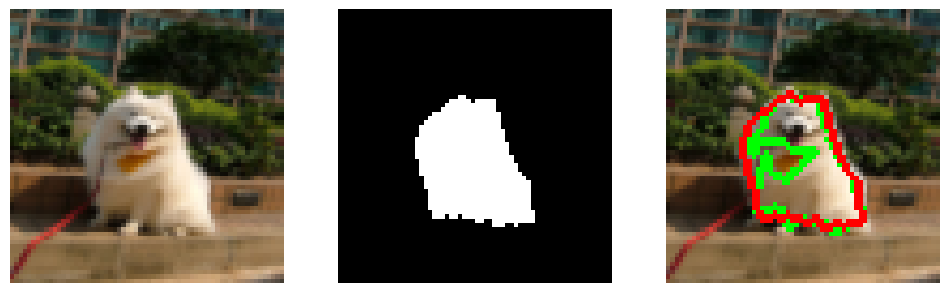

dice for samoyed-185 : 0.844


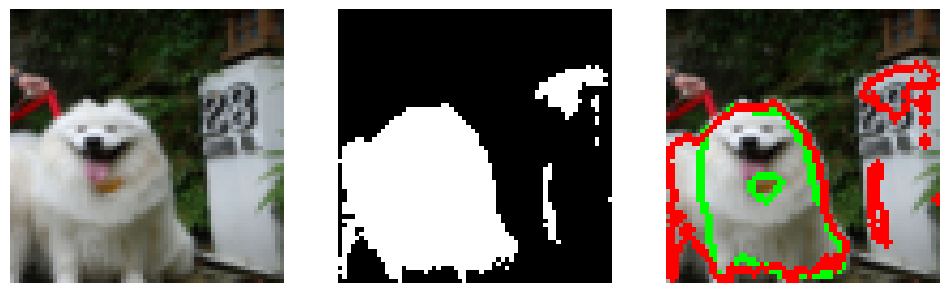

dice for samoyed-186 : 0.791


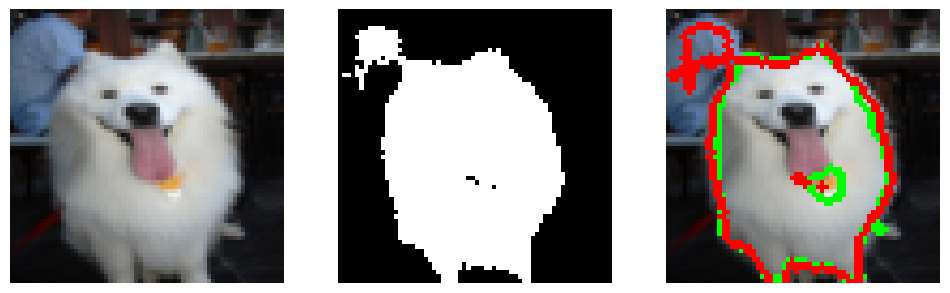

dice for samoyed-187 : 0.925


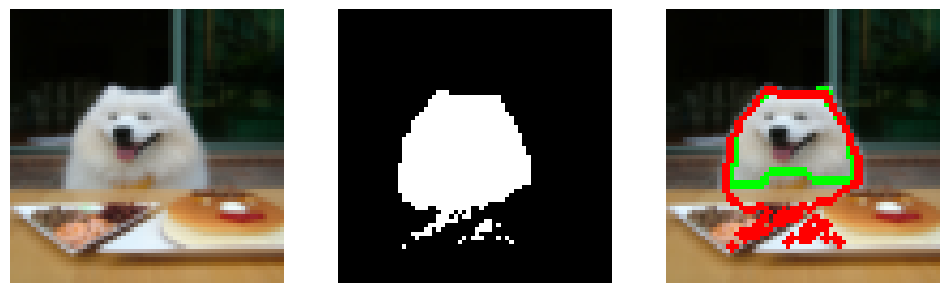

dice for samoyed-188 : 0.791


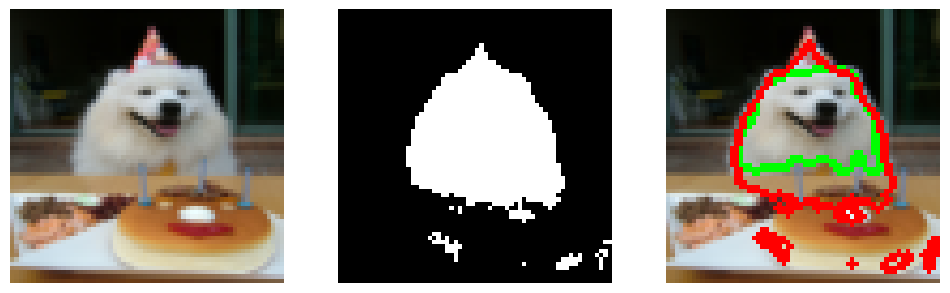

dice for samoyed-189 : 0.737


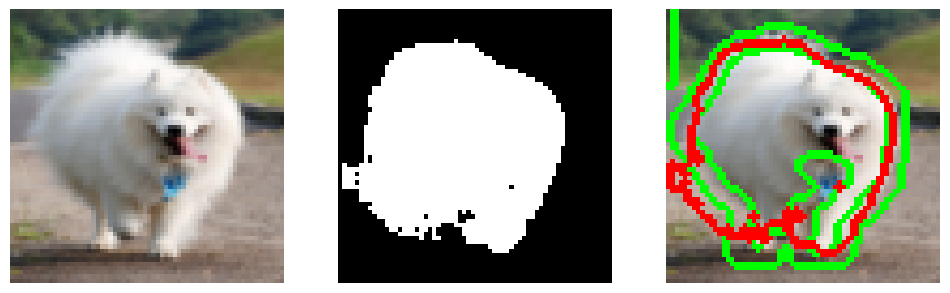

dice for samoyed-190 : 0.564


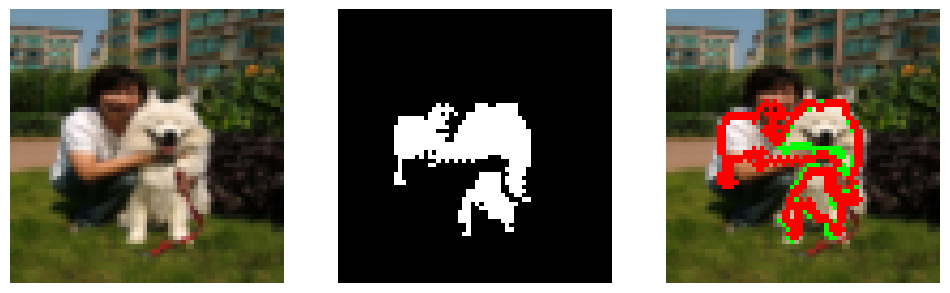

dice for samoyed-191 : 0.677


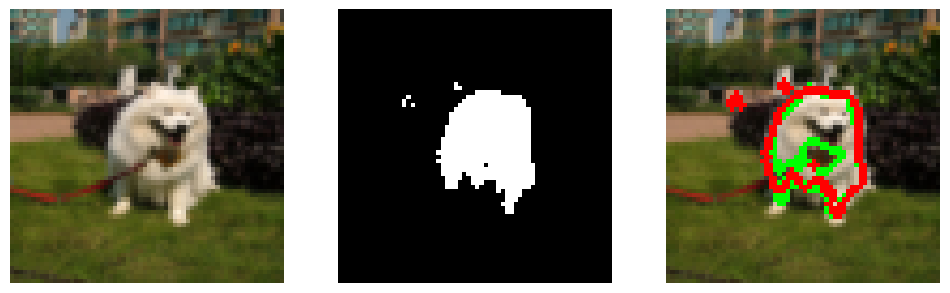

dice for samoyed-192 : 0.838


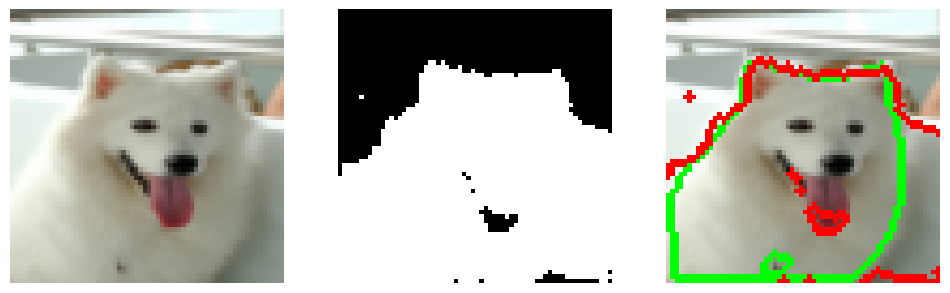

dice for samoyed-193 : 0.873


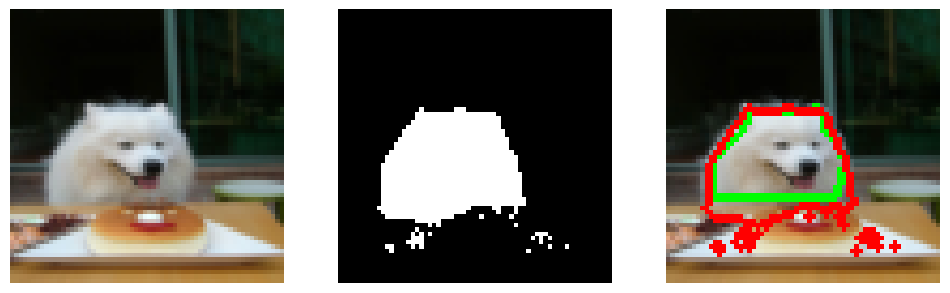

dice for samoyed-194 : 0.822


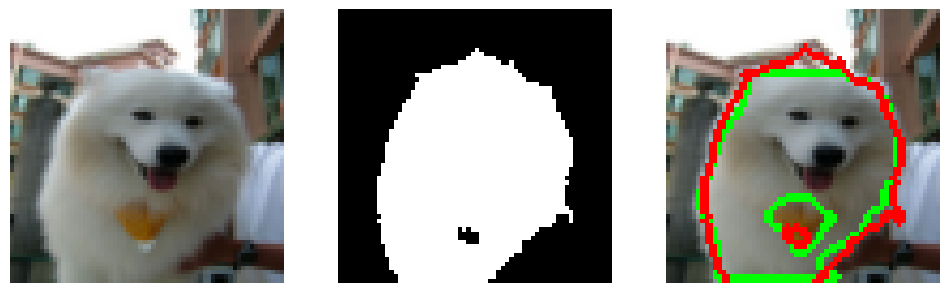

dice for samoyed-195 : 0.910


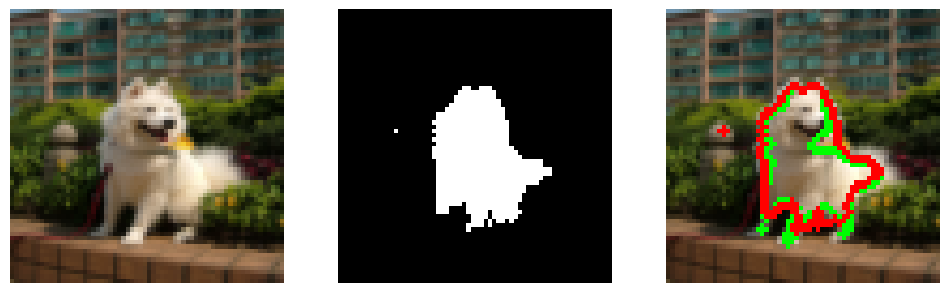

dice for samoyed-196 : 0.884


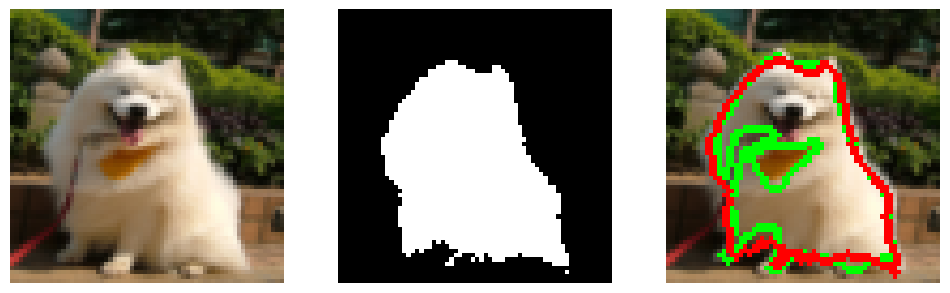

dice for samoyed-197 : 0.882


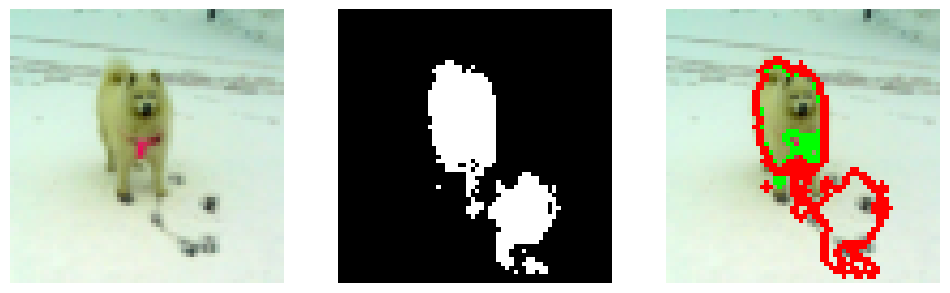

dice for samoyed-198 : 0.624


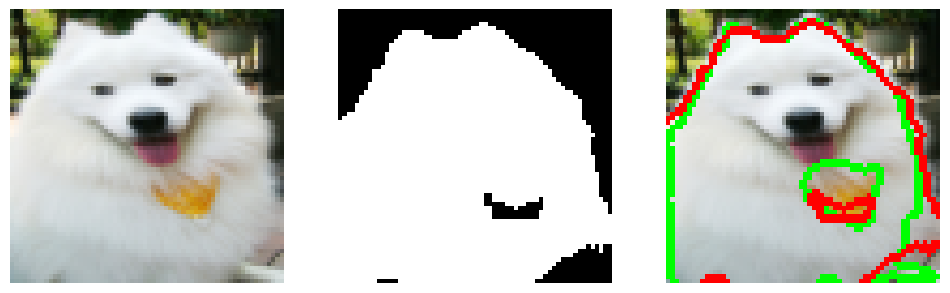

dice for samoyed-199 : 0.929


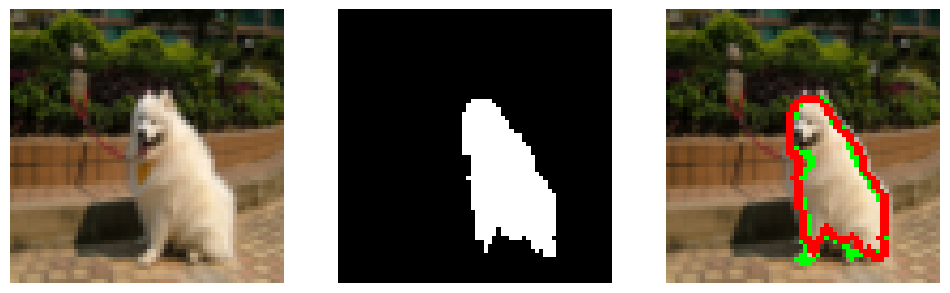

dice for samoyed-200 : 0.922
average dice: 0.831


In [81]:
epochs = 50
model_5 = get_model_5(size_, size_)
model_5.summary()
hist_5 = model_5.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])
display_history(hist_5)
dices_5 = make_prediction(model_5, test_idxs, test_imgs, test_segs)
print('average dice: %02.3f'%(np.mean(dices_5)) )

**Question 11 -** Based on the figure below and average dice scores, comment on the segmentation accuracy reached for the 5 models. What is the best model and why?

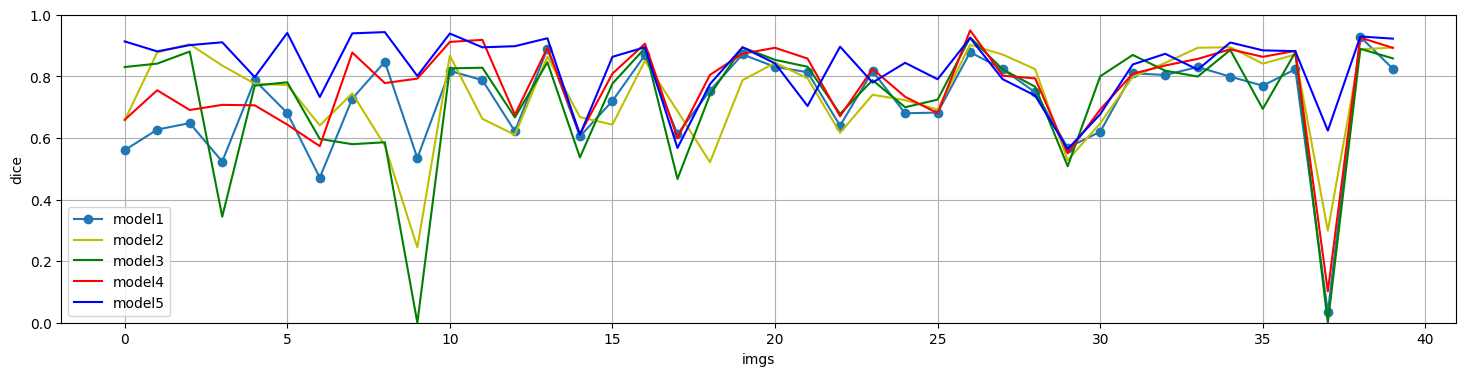

model 1: 0.717
model 2: 0.740
model 3: 0.719
model 4: 0.767
model 5: 0.831


In [82]:
plt.figure(figsize=(18, 4))
plt.plot(dices_1,'o-')
plt.plot(dices_2,'y-')
plt.plot(dices_3,'g-')
plt.plot(dices_4,'r-')
plt.plot(dices_5,'b-')
plt.grid()
plt.plot()
plt.ylabel('dice')
plt.ylim([0,1])
plt.xlabel('imgs')
plt.legend(['model1', 'model2','model3', 'model4','model5'], loc='lower left')
plt.show()

print('model 1: %02.3f'%(np.mean(dices_1)))
print('model 2: %02.3f'%(np.mean(dices_2)))
print('model 3: %02.3f'%(np.mean(dices_3)))
print('model 4: %02.3f'%(np.mean(dices_4)))
print('model 5: %02.3f'%(np.mean(dices_5)))

> **Answer** : On the segmentation accuracy graph, we can see that on some images it's quite difficult to make the segmentation of the object (imgs 9 ad 37). The best model is the model_5 because it has the best average dice score. Thurmore, it tends to correct the outliers images that causes bad performance on the other models. I think that they is a overfitting on the other models because masks on same images are very different from the ground truth masks.

***

## II - Object detection

The goal of Sect.II is to create an automatic **face detection model** with deep learning able to accurately localize *samoyed* heads in each image by mean of a bounding box.

In [83]:
import xml.etree.ElementTree as ET

def xml2coordinates(xmlpath):
    tree = ET.parse(xmlpath)
    height = int(tree.findtext("./size/height"))
    width = int(tree.findtext("./size/width"))
    xmin = int(tree.findtext("./object/bndbox/xmin"))
    xmax = int(tree.findtext("./object/bndbox/xmax"))
    ymin = int(tree.findtext("./object/bndbox/ymin"))
    ymax = int(tree.findtext("./object/bndbox/ymax"))
    return height, width, xmin, xmax, ymin, ymax

Groundtruth bounding box coordinates are provided in XML files for 98 images (from `samoyed-11` to `samoyed-18` and from `samoyed-100` to `samoyed-189`).

In [84]:
xml_ids = list(range(11,19))+list(range(100,190))
print(xml_ids)

[11, 12, 13, 14, 15, 16, 17, 18, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189]


Let us rebuild our dataset with associated bounding box coordinates (extracted from `.xml` files).

In [85]:
idxs = []

imgs = np.ndarray((len(xml_ids), size_, size_, 3), dtype=np.float32)
xmins = np.ndarray(len(xml_ids), dtype=np.uint8)
xmaxs = np.ndarray(len(xml_ids), dtype=np.uint8)
ymins = np.ndarray(len(xml_ids), dtype=np.uint8)
ymaxs = np.ndarray(len(xml_ids), dtype=np.uint8)

for idx, id_ in enumerate(xml_ids):
    name = 'samoyed-'+str(id_)
    img = io.imread(name+'.jpg')
    height, width, xmin, xmax, ymin, ymax = xml2coordinates(name+'.xml')
    imgs[idx,...] = resize(img,output_shape=(size_,size_))
    xmins[idx] = int(np.floor(size_*ymin/height))
    xmaxs[idx] = int(np.floor(size_*ymax/height))
    ymins[idx] = int(np.floor(size_*xmin/width))
    ymaxs[idx] = int(np.floor(size_*xmax/width))
    idxs.append(name)

**Question 12 -** Normalize the dataset using `normalization()` and use the `visualize_predicted_box()` function to visualize the first eight images with super-imposed bounding boxes.

In [86]:
imgs = normalization(imgs) # data normalization

In [87]:
def visualize_predicted_box(img, xmin, xmax, ymin, ymax):
    img = rescale_intensity(img, in_range=(np.min(img),np.max(img)), out_range=(0,1))
    mask = np.zeros(shape=img[:,:,0].shape, dtype=np.uint8)
    mask[xmin:xmax+1, ymin:ymax+1] = 1
    out = mark_boundaries(img, mask, color=(0, 1, 0))
    return out

In [93]:
print([(idx, id_) for idx, id_ in enumerate(idxs)])

[(0, 'samoyed-11'), (1, 'samoyed-12'), (2, 'samoyed-13'), (3, 'samoyed-14'), (4, 'samoyed-15'), (5, 'samoyed-16'), (6, 'samoyed-17'), (7, 'samoyed-18'), (8, 'samoyed-100'), (9, 'samoyed-101'), (10, 'samoyed-102'), (11, 'samoyed-103'), (12, 'samoyed-104'), (13, 'samoyed-105'), (14, 'samoyed-106'), (15, 'samoyed-107'), (16, 'samoyed-108'), (17, 'samoyed-109'), (18, 'samoyed-110'), (19, 'samoyed-111'), (20, 'samoyed-112'), (21, 'samoyed-113'), (22, 'samoyed-114'), (23, 'samoyed-115'), (24, 'samoyed-116'), (25, 'samoyed-117'), (26, 'samoyed-118'), (27, 'samoyed-119'), (28, 'samoyed-120'), (29, 'samoyed-121'), (30, 'samoyed-122'), (31, 'samoyed-123'), (32, 'samoyed-124'), (33, 'samoyed-125'), (34, 'samoyed-126'), (35, 'samoyed-127'), (36, 'samoyed-128'), (37, 'samoyed-129'), (38, 'samoyed-130'), (39, 'samoyed-131'), (40, 'samoyed-132'), (41, 'samoyed-133'), (42, 'samoyed-134'), (43, 'samoyed-135'), (44, 'samoyed-136'), (45, 'samoyed-137'), (46, 'samoyed-138'), (47, 'samoyed-139'), (48, 'sam

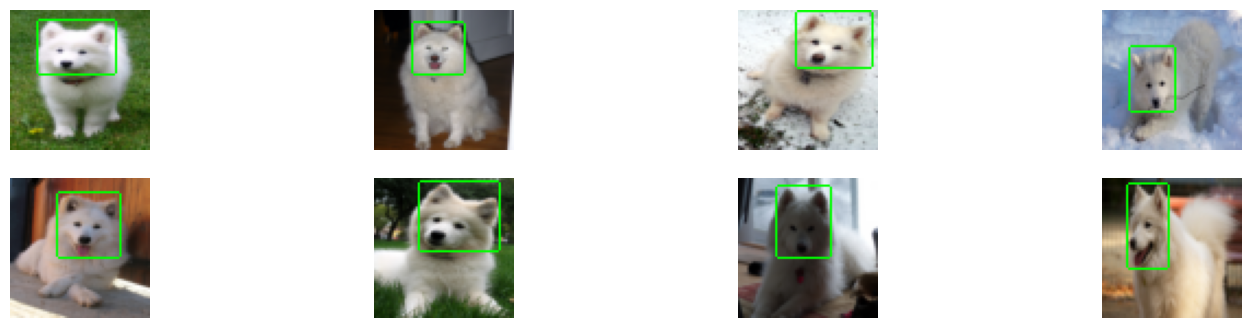

In [102]:
plt.figure(figsize=(18, 4))
for idx in range(8):
    plt.subplot(2,4,idx+1)
    plt.axis('off')
    plt.imshow(visualize_predicted_box(imgs[idx], xmins[idx], xmaxs[idx], ymins[idx], ymaxs[idx]))
plt.show()

**Question 13 -** Using pre-trained `VGG16` and fully-connected layers, build a deep regression model able to infer the `4` bounding box coordinates from a given intput image. The mean absolute error (`mean_absolute_error`) will be used as loss function.

In [105]:
from keras.layers import Dense, Flatten

def get_model_6(img_rows, img_cols):

    vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_rows,img_cols,3), pooling=None, classes=1000)

    flatten = Flatten()(vgg16_model.get_layer('block5_conv3').output)
    dense = Dense(256, activation='relu')(flatten)
    dense = Dense(128, activation='relu')(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = Dense(4, activation='linear')(dense)

    model = Model(inputs=[vgg16_model.layers[0].output], outputs=[dense])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_absolute_error', metrics=['mean_absolute_error'])

    return model

In [106]:
model_6 = get_model_6(size_, size_)
model_6.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

**Question 14 -** Divide the dataset into training and test subsets (with a ratio of `70%`), run the training and display how evolves the loss function during training for both subsets.

In [107]:
ratio = 0.7
split = int(len(imgs)*ratio)
print('dataset size =', len(imgs), '; first', split, 'images for training, remaining for test')
train_imgs = imgs[:split] # training images
test_imgs  = imgs[split:] # test images
train_xmins, train_xmaxs, train_ymins, train_ymaxs = xmins[:split], xmaxs[:split], ymins[:split], ymaxs[:split]
test_xmins, test_xmaxs, test_ymins, test_ymaxs = xmins[split:], xmaxs[split:], ymins[split:], ymaxs[split:]
train_idxs = idxs[:split] # training image ids
test_idxs  = idxs[split:] # test image ids

dataset size = 98 ; first 68 images for training, remaining for test


In [108]:
batch_size = 10
epochs = 100

model_checkpoint = ModelCheckpoint('./weights.hdf5', monitor='val_mean_absolute_error', verbose=0, save_best_only=False, save_weights_only=True, mode='max', save_freq='epoch')

In [109]:
train_coords = np.vstack([train_xmins,train_xmaxs,train_ymins,train_ymaxs]).T
test_coords = np.vstack([test_xmins,test_xmaxs,test_ymins,test_ymaxs]).T

hist_6 = model_6.fit(train_imgs, train_coords, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_coords), callbacks=[model_checkpoint])

Epoch 1/100
7/7 [==============================] - 10s 417ms/step - loss: 22.2268 - mean_absolute_error: 22.2268 - val_loss: 9.9943 - val_mean_absolute_error: 9.9943
Epoch 2/100
7/7 [==============================] - 1s 150ms/step - loss: 8.3702 - mean_absolute_error: 8.3702 - val_loss: 7.0536 - val_mean_absolute_error: 7.0536
Epoch 3/100
7/7 [==============================] - 0s 63ms/step - loss: 6.3345 - mean_absolute_error: 6.3345 - val_loss: 7.2362 - val_mean_absolute_error: 7.2362
Epoch 4/100
7/7 [==============================] - 2s 332ms/step - loss: 5.8231 - mean_absolute_error: 5.8231 - val_loss: 6.1431 - val_mean_absolute_error: 6.1431
Epoch 5/100
7/7 [==============================] - 1s 113ms/step - loss: 5.4929 - mean_absolute_error: 5.4929 - val_loss: 6.1069 - val_mean_absolute_error: 6.1069
Epoch 6/100
7/7 [==============================] - 0s 74ms/step - loss: 5.0063 - mean_absolute_error: 5.0063 - val_loss: 5.7313 - val_mean_absolute_error: 5.7313
Epoch 7/100
7/7 [====

In [110]:
def display_history_2(hist):
    plt.plot(hist.history['mean_absolute_error'])
    plt.plot(hist.history['val_mean_absolute_error'])
    plt.grid()
    plt.title('model loss')
    plt.ylabel('mean absolute error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

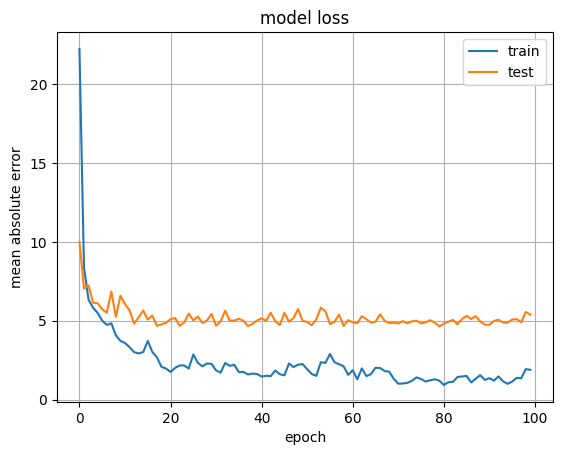

In [111]:
display_history_2(hist_6)

**Question 15 -** Use the `visualize_predicted_boxes()` function to display the prediction and groundtruth bounding boxes.

In [112]:
def visualize_predicted_boxes(img, xmin, xmax, ymin, ymax, GTxmin, GTxmax, GTymin, GTymax):
    img = rescale_intensity(img, in_range=(np.min(img),np.max(img)), out_range=(0,1))
    mask = np.zeros(shape=img[:,:,0].shape, dtype=np.uint8)
    mask[xmin:xmax+1, ymin:ymax+1] = 1
    out = mark_boundaries(img, mask, color=(1, 0, 0), background_label=2)
    mask = np.zeros(shape=img[:,:,0].shape, dtype=np.uint8)
    mask[GTxmin:GTxmax+1, GTymin:GTymax+1] = 1
    out = mark_boundaries(out, mask, color=(0, 1, 0), background_label=4)
    return out

samoyed-160


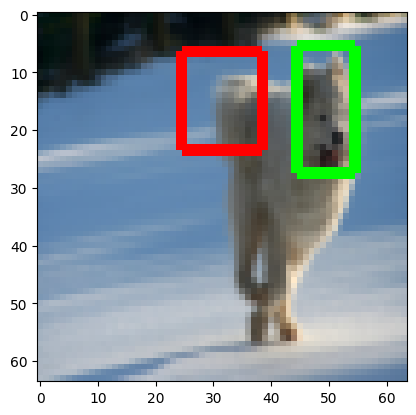

samoyed-161


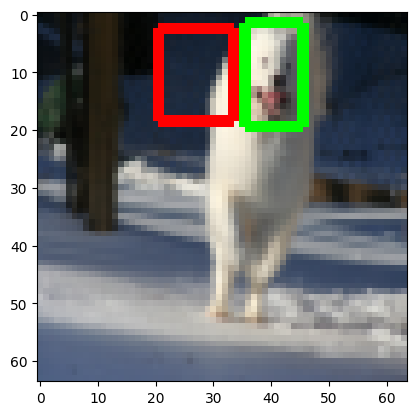

samoyed-162


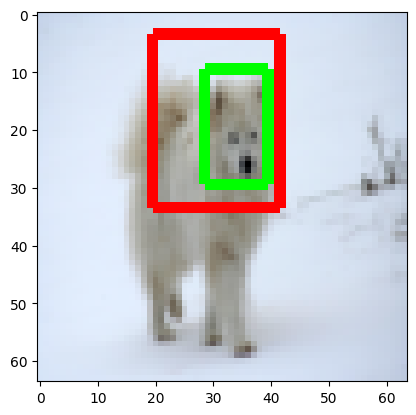

samoyed-163


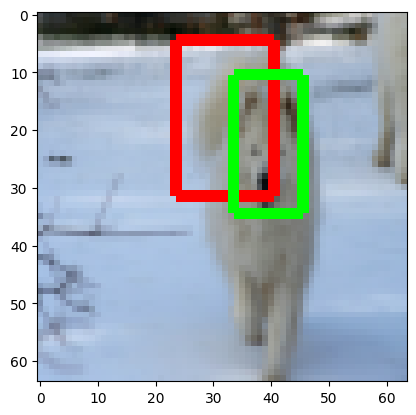

samoyed-164


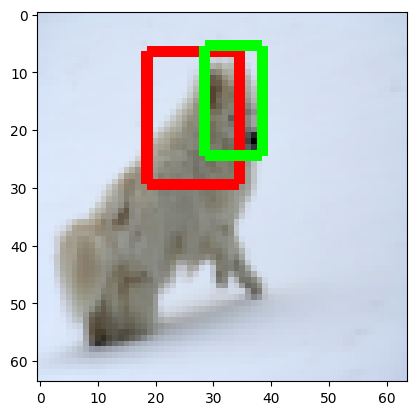

samoyed-165


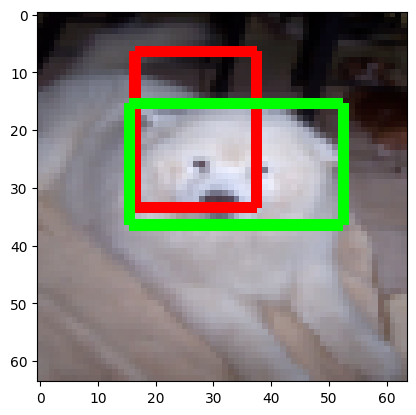

samoyed-166


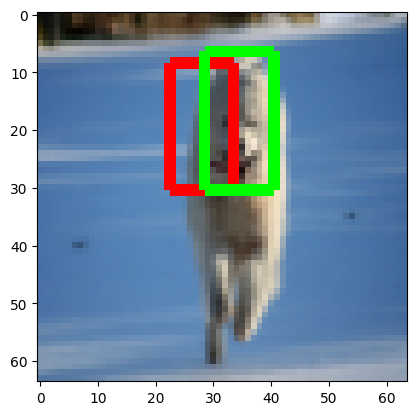

samoyed-167


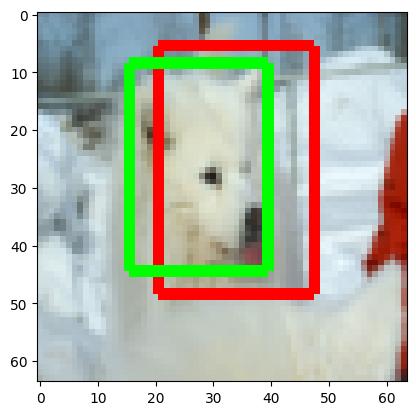

samoyed-168


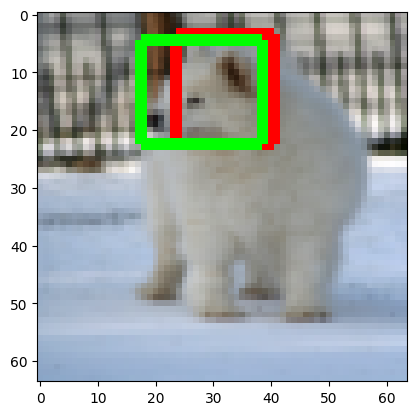

samoyed-169


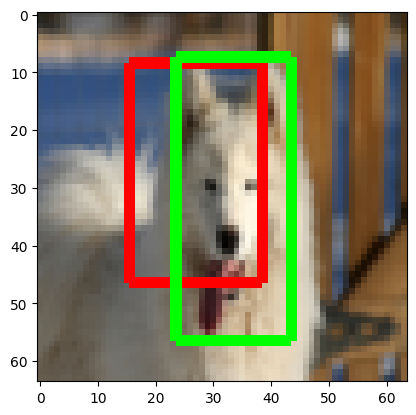

samoyed-170


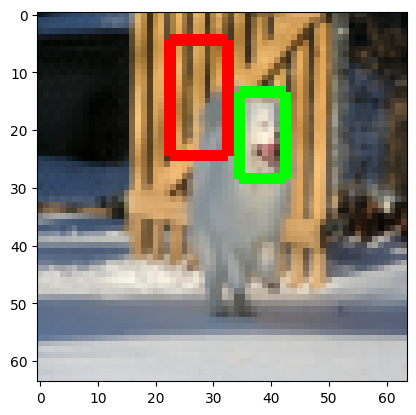

samoyed-171


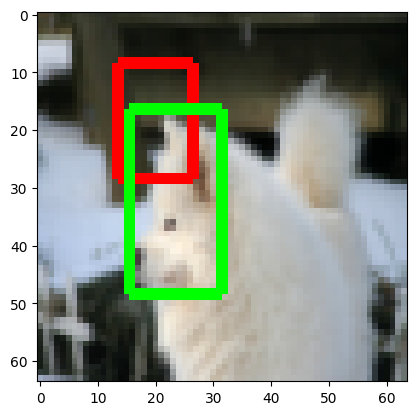

samoyed-172


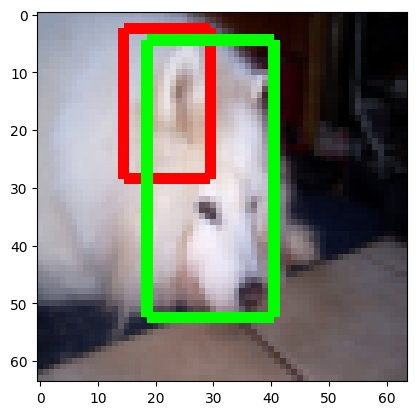

samoyed-173


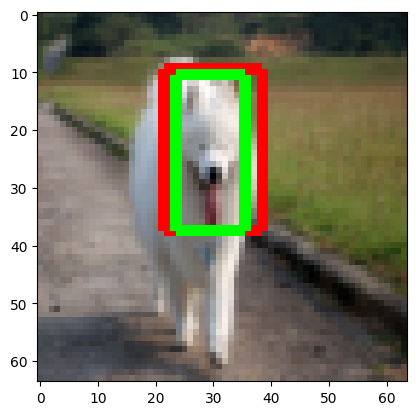

samoyed-174


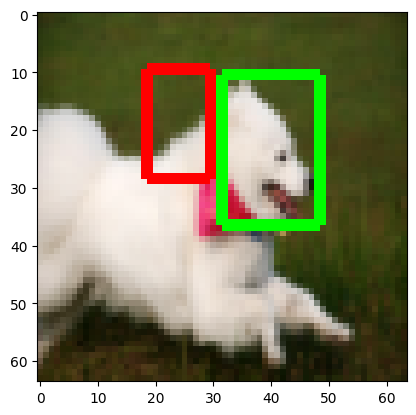

samoyed-175


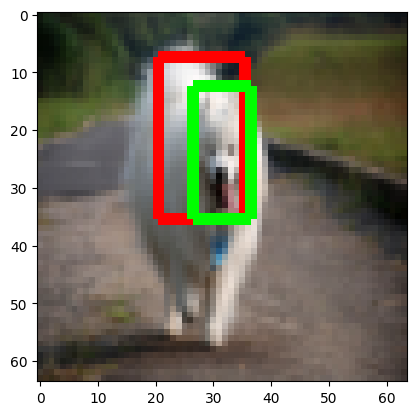

samoyed-176


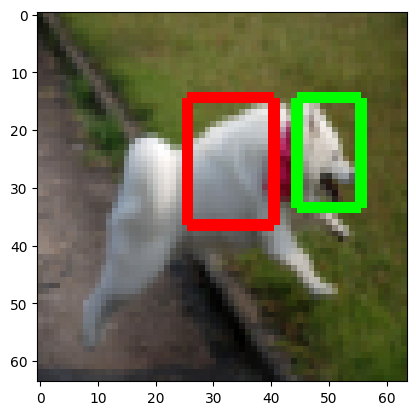

samoyed-177


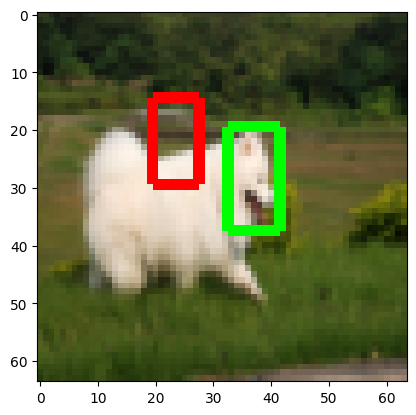

samoyed-178


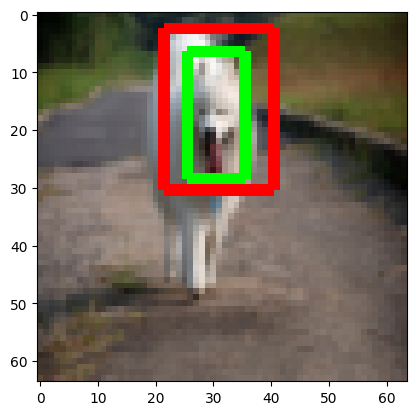

samoyed-179


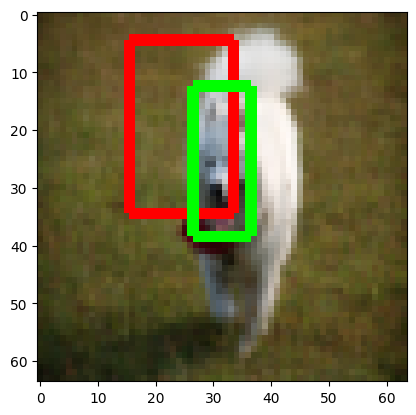

samoyed-180


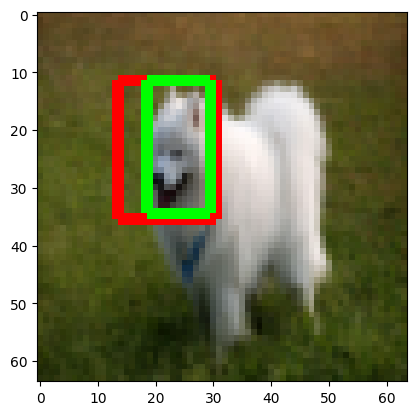

samoyed-181


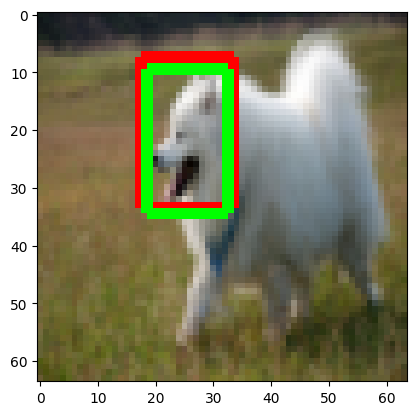

samoyed-182


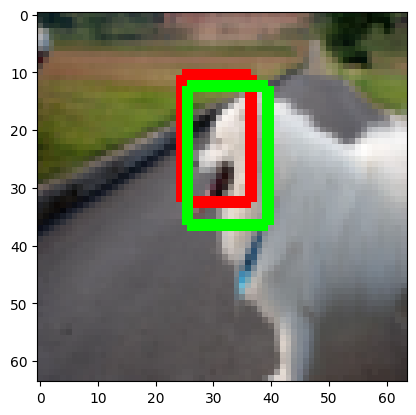

samoyed-183


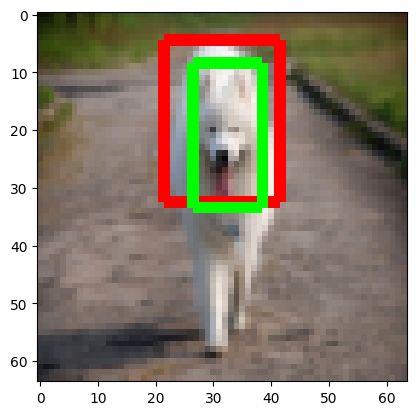

samoyed-184


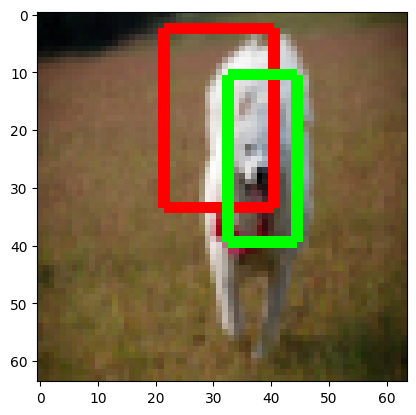

samoyed-185


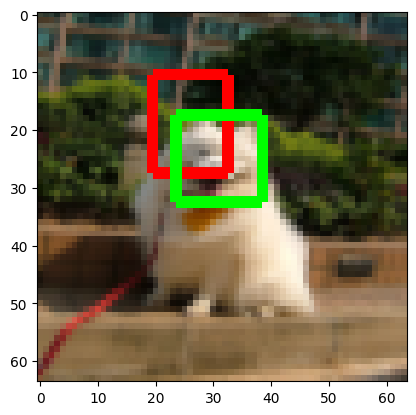

samoyed-186


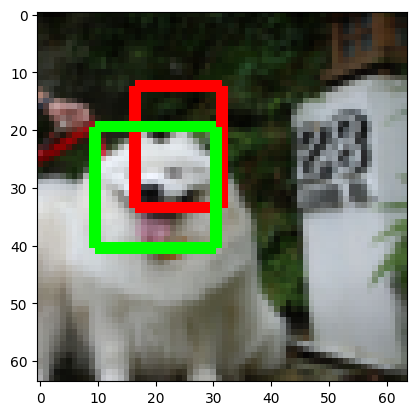

samoyed-187


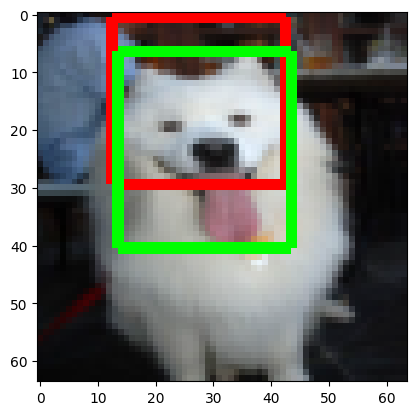

samoyed-188


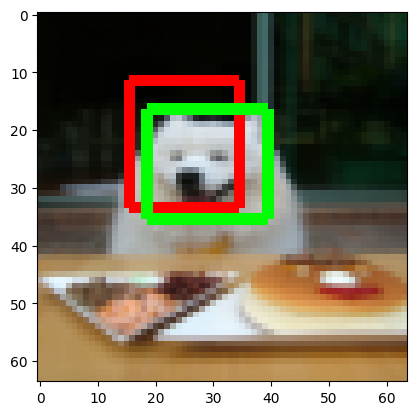

samoyed-189


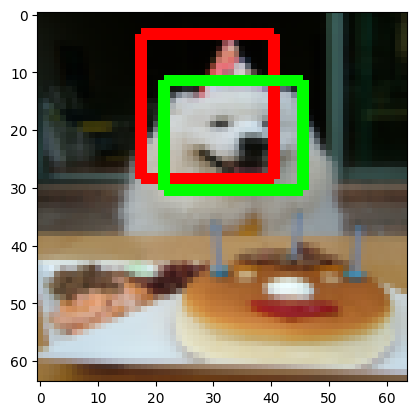

In [114]:
model_6.load_weights('./weights.hdf5')
for idx, id_ in enumerate(test_idxs):
    print(id_)
    xmin, xmax, ymin, ymax = model_6.predict(test_imgs[idx:idx+1], verbose=0)[0].astype(np.uint8)
    plt.imshow(visualize_predicted_boxes(test_imgs[idx], xmin, xmax, ymin, ymax, test_xmins[idx], test_xmaxs[idx], test_ymins[idx], test_ymaxs[idx]))
    plt.show()

***

Do not forget to upload your notebook on **Moodle**. Thank you !